In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

0


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=42

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitor_sma1', 'station_visitors_mean', 'all_count_y1', 'all_count_y5'])
len(lag_cols)

14

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['nb_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'nb_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstmnb", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('3002nb_lstm_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(14,) 0.00244472 2.91745


(829, 517, 14)


train/valid # (288405, 2) (72210, 2)


train/valid # (192578, 2) (49030, 2)
train/valid # (192578, 2) (49030, 2)


rand split across time
train has 192578 records out of 360615 records
valid has 49030 records out of 360615 records
train has 5803 records out of 5803 records
no valid set
1504
0
14 18 (1, 18)
(?, 42, 28)


{'loss': 'nb_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
433921


Epoch 1/100


   1/1504 [..............................] - ETA: 47:26 - loss: 27.8966 - total_loss: 27.8966 - reg_loss: 8.4040

   4/1504 [..............................] - ETA: 12:15 - loss: 9.4591 - total_loss: 9.4591 - reg_loss: 5.8247  

   6/1504 [..............................] - ETA: 8:22 - loss: 7.0434 - total_loss: 7.0434 - reg_loss: 4.5322 

   9/1504 [..............................] - ETA: 5:46 - loss: 5.3818 - total_loss: 5.3818 - reg_loss: 3.2863

  12/1504 [..............................] - ETA: 4:27 - loss: 4.5666 - total_loss: 4.5666 - reg_loss: 3.0032

  15/1504 [..............................] - ETA: 3:40 - loss: 4.0835 - total_loss: 4.0835 - reg_loss: 3.1720

  18/1504 [..............................] - ETA: 3:08 - loss: 3.7612 - total_loss: 3.7612 - reg_loss: 3.2662

  21/1504 [..............................] - ETA: 2:46 - loss: 3.5255 - total_loss: 3.5255 - reg_loss: 3.1459

  24/1504 [..............................] - ETA: 2:29 - loss: 3.3455 - total_loss: 3.3455 - reg_loss: 2.9333

  27/1504 [..............................] - ETA: 2:15 - loss: 3.2033 - total_loss: 3.2033 - reg_loss: 2.7006

  30/1504 [..............................] - ETA: 2:05 - loss: 3.0874 - total_loss: 3.0874 - reg_loss: 2.4970

  33/1504 [..............................] - ETA: 1:56 - loss: 2.9920 - total_loss: 2.9920 - reg_loss: 2.3342

  36/1504 [..............................] - ETA: 1:49 - loss: 2.9128 - total_loss: 2.9128 - reg_loss: 2.1833

  39/1504 [..............................] - ETA: 1:43 - loss: 2.8479 - total_loss: 2.8479 - reg_loss: 2.0971

  42/1504 [..............................] - ETA: 1:38 - loss: 2.7904 - total_loss: 2.7904 - reg_loss: 1.9854

  45/1504 [..............................] - ETA: 1:33 - loss: 2.7391 - total_loss: 2.7391 - reg_loss: 1.8834

  48/1504 [..............................] - ETA: 1:29 - loss: 2.6960 - total_loss: 2.6960 - reg_loss: 1.7914

  51/1504 [>.............................] - ETA: 1:26 - loss: 2.6578 - total_loss: 2.6578 - reg_loss: 1.7180

  54/1504 [>.............................] - ETA: 1:23 - loss: 2.6233 - total_loss: 2.6233 - reg_loss: 1.6471

  57/1504 [>.............................] - ETA: 1:20 - loss: 2.5924 - total_loss: 2.5924 - reg_loss: 1.5837

  60/1504 [>.............................] - ETA: 1:17 - loss: 2.5649 - total_loss: 2.5649 - reg_loss: 1.5273

  63/1504 [>.............................] - ETA: 1:15 - loss: 2.5396 - total_loss: 2.5396 - reg_loss: 1.4781

  66/1504 [>.............................] - ETA: 1:13 - loss: 2.5175 - total_loss: 2.5175 - reg_loss: 1.4304

  69/1504 [>.............................] - ETA: 1:11 - loss: 2.4967 - total_loss: 2.4967 - reg_loss: 1.3861

  72/1504 [>.............................] - ETA: 1:09 - loss: 2.4775 - total_loss: 2.4775 - reg_loss: 1.3474

  75/1504 [>.............................] - ETA: 1:07 - loss: 2.4593 - total_loss: 2.4593 - reg_loss: 1.3114

  78/1504 [>.............................] - ETA: 1:06 - loss: 2.4430 - total_loss: 2.4430 - reg_loss: 1.2795

  81/1504 [>.............................] - ETA: 1:04 - loss: 2.4282 - total_loss: 2.4282 - reg_loss: 1.2474

  84/1504 [>.............................] - ETA: 1:03 - loss: 2.4145 - total_loss: 2.4145 - reg_loss: 1.2175

  87/1504 [>.............................] - ETA: 1:02 - loss: 2.4013 - total_loss: 2.4013 - reg_loss: 1.1894

  90/1504 [>.............................] - ETA: 1:00 - loss: 2.3892 - total_loss: 2.3892 - reg_loss: 1.1622

  93/1504 [>.............................] - ETA: 59s - loss: 2.3783 - total_loss: 2.3783 - reg_loss: 1.1376 

  96/1504 [>.............................] - ETA: 58s - loss: 2.3680 - total_loss: 2.3680 - reg_loss: 1.1161

  99/1504 [>.............................] - ETA: 57s - loss: 2.3576 - total_loss: 2.3576 - reg_loss: 1.0961

 102/1504 [=>............................] - ETA: 57s - loss: 2.3485 - total_loss: 2.3485 - reg_loss: 1.0748

 105/1504 [=>............................] - ETA: 56s - loss: 2.3396 - total_loss: 2.3396 - reg_loss: 1.0571

 108/1504 [=>............................] - ETA: 55s - loss: 2.3315 - total_loss: 2.3315 - reg_loss: 1.0415

 111/1504 [=>............................] - ETA: 54s - loss: 2.3238 - total_loss: 2.3238 - reg_loss: 1.0236

 114/1504 [=>............................] - ETA: 53s - loss: 2.3163 - total_loss: 2.3163 - reg_loss: 1.0082

 117/1504 [=>............................] - ETA: 53s - loss: 2.3090 - total_loss: 2.3090 - reg_loss: 0.9944

 120/1504 [=>............................] - ETA: 52s - loss: 2.3023 - total_loss: 2.3023 - reg_loss: 0.9803

 123/1504 [=>............................] - ETA: 51s - loss: 2.2961 - total_loss: 2.2961 - reg_loss: 0.9652

 126/1504 [=>............................] - ETA: 51s - loss: 2.2901 - total_loss: 2.2901 - reg_loss: 0.9524

 129/1504 [=>............................] - ETA: 50s - loss: 2.2841 - total_loss: 2.2841 - reg_loss: 0.9400

 132/1504 [=>............................] - ETA: 49s - loss: 2.2788 - total_loss: 2.2788 - reg_loss: 0.9259

 135/1504 [=>............................] - ETA: 49s - loss: 2.2731 - total_loss: 2.2731 - reg_loss: 0.9150

 138/1504 [=>............................] - ETA: 48s - loss: 2.2685 - total_loss: 2.2685 - reg_loss: 0.9030

 141/1504 [=>............................] - ETA: 48s - loss: 2.2635 - total_loss: 2.2635 - reg_loss: 0.8918

 144/1504 [=>............................] - ETA: 47s - loss: 2.2590 - total_loss: 2.2590 - reg_loss: 0.8797

 147/1504 [=>............................] - ETA: 47s - loss: 2.2540 - total_loss: 2.2540 - reg_loss: 0.8700

 150/1504 [=>............................] - ETA: 47s - loss: 2.2498 - total_loss: 2.2498 - reg_loss: 0.8593

 153/1504 [==>...........................] - ETA: 46s - loss: 2.2453 - total_loss: 2.2453 - reg_loss: 0.8497

 156/1504 [==>...........................] - ETA: 46s - loss: 2.2409 - total_loss: 2.2409 - reg_loss: 0.8414

 159/1504 [==>...........................] - ETA: 45s - loss: 2.2369 - total_loss: 2.2369 - reg_loss: 0.8328

 162/1504 [==>...........................] - ETA: 45s - loss: 2.2334 - total_loss: 2.2334 - reg_loss: 0.8242

 165/1504 [==>...........................] - ETA: 45s - loss: 2.2299 - total_loss: 2.2299 - reg_loss: 0.8164

 168/1504 [==>...........................] - ETA: 44s - loss: 2.2264 - total_loss: 2.2264 - reg_loss: 0.8081

 171/1504 [==>...........................] - ETA: 44s - loss: 2.2232 - total_loss: 2.2232 - reg_loss: 0.8004

 174/1504 [==>...........................] - ETA: 43s - loss: 2.2198 - total_loss: 2.2198 - reg_loss: 0.7931

 177/1504 [==>...........................] - ETA: 43s - loss: 2.2167 - total_loss: 2.2167 - reg_loss: 0.7862

 180/1504 [==>...........................] - ETA: 43s - loss: 2.2138 - total_loss: 2.2138 - reg_loss: 0.7794

 183/1504 [==>...........................] - ETA: 42s - loss: 2.2108 - total_loss: 2.2108 - reg_loss: 0.7728

 186/1504 [==>...........................] - ETA: 42s - loss: 2.2080 - total_loss: 2.2080 - reg_loss: 0.7663

 189/1504 [==>...........................] - ETA: 42s - loss: 2.2050 - total_loss: 2.2050 - reg_loss: 0.7596

 192/1504 [==>...........................] - ETA: 42s - loss: 2.2021 - total_loss: 2.2021 - reg_loss: 0.7532

 195/1504 [==>...........................] - ETA: 41s - loss: 2.1995 - total_loss: 2.1995 - reg_loss: 0.7467

 198/1504 [==>...........................] - ETA: 41s - loss: 2.1971 - total_loss: 2.1971 - reg_loss: 0.7405

 201/1504 [===>..........................] - ETA: 41s - loss: 2.1949 - total_loss: 2.1949 - reg_loss: 0.7350

 204/1504 [===>..........................] - ETA: 40s - loss: 2.1923 - total_loss: 2.1923 - reg_loss: 0.7297

 207/1504 [===>..........................] - ETA: 40s - loss: 2.1900 - total_loss: 2.1900 - reg_loss: 0.7243

 210/1504 [===>..........................] - ETA: 40s - loss: 2.1879 - total_loss: 2.1879 - reg_loss: 0.7186

 213/1504 [===>..........................] - ETA: 40s - loss: 2.1856 - total_loss: 2.1856 - reg_loss: 0.7136

 216/1504 [===>..........................] - ETA: 39s - loss: 2.1835 - total_loss: 2.1835 - reg_loss: 0.7088

 219/1504 [===>..........................] - ETA: 39s - loss: 2.1812 - total_loss: 2.1812 - reg_loss: 0.7048

 222/1504 [===>..........................] - ETA: 39s - loss: 2.1790 - total_loss: 2.1790 - reg_loss: 0.7003

 225/1504 [===>..........................] - ETA: 39s - loss: 2.1772 - total_loss: 2.1772 - reg_loss: 0.6953

 228/1504 [===>..........................] - ETA: 38s - loss: 2.1754 - total_loss: 2.1754 - reg_loss: 0.6905

 231/1504 [===>..........................] - ETA: 38s - loss: 2.1737 - total_loss: 2.1737 - reg_loss: 0.6859

 234/1504 [===>..........................] - ETA: 38s - loss: 2.1724 - total_loss: 2.1724 - reg_loss: 0.6828

 236/1504 [===>..........................] - ETA: 38s - loss: 2.1713 - total_loss: 2.1713 - reg_loss: 0.6797

 239/1504 [===>..........................] - ETA: 38s - loss: 2.1695 - total_loss: 2.1695 - reg_loss: 0.6755

 242/1504 [===>..........................] - ETA: 37s - loss: 2.1680 - total_loss: 2.1680 - reg_loss: 0.6710

 244/1504 [===>..........................] - ETA: 37s - loss: 2.1670 - total_loss: 2.1670 - reg_loss: 0.6683

 247/1504 [===>..........................] - ETA: 37s - loss: 2.1657 - total_loss: 2.1657 - reg_loss: 0.6633

 250/1504 [===>..........................] - ETA: 37s - loss: 2.1639 - total_loss: 2.1639 - reg_loss: 0.6595

 253/1504 [====>.........................] - ETA: 37s - loss: 2.1624 - total_loss: 2.1624 - reg_loss: 0.6561

 256/1504 [====>.........................] - ETA: 37s - loss: 2.1610 - total_loss: 2.1610 - reg_loss: 0.6528

 259/1504 [====>.........................] - ETA: 36s - loss: 2.1595 - total_loss: 2.1595 - reg_loss: 0.6490

 262/1504 [====>.........................] - ETA: 36s - loss: 2.1578 - total_loss: 2.1578 - reg_loss: 0.6457

 265/1504 [====>.........................] - ETA: 36s - loss: 2.1564 - total_loss: 2.1564 - reg_loss: 0.6419

 268/1504 [====>.........................] - ETA: 36s - loss: 2.1549 - total_loss: 2.1549 - reg_loss: 0.6382

 271/1504 [====>.........................] - ETA: 36s - loss: 2.1535 - total_loss: 2.1535 - reg_loss: 0.6356

 273/1504 [====>.........................] - ETA: 36s - loss: 2.1528 - total_loss: 2.1528 - reg_loss: 0.6340

 275/1504 [====>.........................] - ETA: 35s - loss: 2.1519 - total_loss: 2.1519 - reg_loss: 0.6320

 278/1504 [====>.........................] - ETA: 35s - loss: 2.1509 - total_loss: 2.1509 - reg_loss: 0.6284

 281/1504 [====>.........................] - ETA: 35s - loss: 2.1496 - total_loss: 2.1496 - reg_loss: 0.6254

 284/1504 [====>.........................] - ETA: 35s - loss: 2.1483 - total_loss: 2.1483 - reg_loss: 0.6226

 287/1504 [====>.........................] - ETA: 35s - loss: 2.1469 - total_loss: 2.1469 - reg_loss: 0.6200

 290/1504 [====>.........................] - ETA: 35s - loss: 2.1455 - total_loss: 2.1455 - reg_loss: 0.6174

 293/1504 [====>.........................] - ETA: 34s - loss: 2.1444 - total_loss: 2.1444 - reg_loss: 0.6144

 296/1504 [====>.........................] - ETA: 34s - loss: 2.1436 - total_loss: 2.1436 - reg_loss: 0.6115

 299/1504 [====>.........................] - ETA: 34s - loss: 2.1425 - total_loss: 2.1425 - reg_loss: 0.6088

 302/1504 [=====>........................] - ETA: 34s - loss: 2.1414 - total_loss: 2.1414 - reg_loss: 0.6057

 305/1504 [=====>........................] - ETA: 34s - loss: 2.1405 - total_loss: 2.1405 - reg_loss: 0.6033

 308/1504 [=====>........................] - ETA: 34s - loss: 2.1396 - total_loss: 2.1396 - reg_loss: 0.6006

 311/1504 [=====>........................] - ETA: 33s - loss: 2.1388 - total_loss: 2.1388 - reg_loss: 0.5979

 314/1504 [=====>........................] - ETA: 33s - loss: 2.1376 - total_loss: 2.1376 - reg_loss: 0.5955

 317/1504 [=====>........................] - ETA: 33s - loss: 2.1366 - total_loss: 2.1366 - reg_loss: 0.5932

 320/1504 [=====>........................] - ETA: 33s - loss: 2.1357 - total_loss: 2.1357 - reg_loss: 0.5913

 323/1504 [=====>........................] - ETA: 33s - loss: 2.1346 - total_loss: 2.1346 - reg_loss: 0.5895

 326/1504 [=====>........................] - ETA: 33s - loss: 2.1338 - total_loss: 2.1338 - reg_loss: 0.5873

 329/1504 [=====>........................] - ETA: 33s - loss: 2.1330 - total_loss: 2.1330 - reg_loss: 0.5849

 332/1504 [=====>........................] - ETA: 32s - loss: 2.1321 - total_loss: 2.1321 - reg_loss: 0.5824

 335/1504 [=====>........................] - ETA: 32s - loss: 2.1313 - total_loss: 2.1313 - reg_loss: 0.5805

 338/1504 [=====>........................] - ETA: 32s - loss: 2.1307 - total_loss: 2.1307 - reg_loss: 0.5780

 341/1504 [=====>........................] - ETA: 32s - loss: 2.1300 - total_loss: 2.1300 - reg_loss: 0.5754

 344/1504 [=====>........................] - ETA: 32s - loss: 2.1290 - total_loss: 2.1290 - reg_loss: 0.5736

 347/1504 [=====>........................] - ETA: 32s - loss: 2.1281 - total_loss: 2.1281 - reg_loss: 0.5717

 350/1504 [=====>........................] - ETA: 32s - loss: 2.1272 - total_loss: 2.1272 - reg_loss: 0.5699

 353/1504 [======>.......................] - ETA: 31s - loss: 2.1263 - total_loss: 2.1263 - reg_loss: 0.5676

 356/1504 [======>.......................] - ETA: 31s - loss: 2.1258 - total_loss: 2.1258 - reg_loss: 0.5652

 359/1504 [======>.......................] - ETA: 31s - loss: 2.1250 - total_loss: 2.1250 - reg_loss: 0.5630

 362/1504 [======>.......................] - ETA: 31s - loss: 2.1241 - total_loss: 2.1241 - reg_loss: 0.5618

 365/1504 [======>.......................] - ETA: 31s - loss: 2.1232 - total_loss: 2.1232 - reg_loss: 0.5607

 368/1504 [======>.......................] - ETA: 31s - loss: 2.1224 - total_loss: 2.1224 - reg_loss: 0.5585

 371/1504 [======>.......................] - ETA: 31s - loss: 2.1216 - total_loss: 2.1216 - reg_loss: 0.5564



 374/1504 [======>.......................] - ETA: 30s - loss: 2.1210 - total_loss: 2.1210 - reg_loss: 0.5549

 377/1504 [======>.......................] - ETA: 30s - loss: 2.1202 - total_loss: 2.1202 - reg_loss: 0.5534

 380/1504 [======>.......................] - ETA: 30s - loss: 2.1196 - total_loss: 2.1196 - reg_loss: 0.5513

 383/1504 [======>.......................] - ETA: 30s - loss: 2.1188 - total_loss: 2.1188 - reg_loss: 0.5502

 386/1504 [======>.......................] - ETA: 30s - loss: 2.1182 - total_loss: 2.1182 - reg_loss: 0.5593

 389/1504 [======>.......................] - ETA: 30s - loss: 2.1176 - total_loss: 2.1176 - reg_loss: 0.5576

 392/1504 [======>.......................] - ETA: 30s - loss: 2.1169 - total_loss: 2.1169 - reg_loss: 0.5566

 395/1504 [======>.......................] - ETA: 30s - loss: 2.1161 - total_loss: 2.1161 - reg_loss: 0.5550

 398/1504 [======>.......................] - ETA: 29s - loss: 2.1155 - total_loss: 2.1155 - reg_loss: 0.5533

 401/1504 [======>.......................] - ETA: 29s - loss: 2.1148 - total_loss: 2.1148 - reg_loss: 0.5517

 404/1504 [=======>......................] - ETA: 29s - loss: 2.1141 - total_loss: 2.1141 - reg_loss: 0.5502

 407/1504 [=======>......................] - ETA: 29s - loss: 2.1134 - total_loss: 2.1134 - reg_loss: 0.5486

 410/1504 [=======>......................] - ETA: 29s - loss: 2.1126 - total_loss: 2.1126 - reg_loss: 0.5473

 413/1504 [=======>......................] - ETA: 29s - loss: 2.1121 - total_loss: 2.1121 - reg_loss: 0.5457

 416/1504 [=======>......................] - ETA: 29s - loss: 2.1116 - total_loss: 2.1116 - reg_loss: 0.5440

 419/1504 [=======>......................] - ETA: 29s - loss: 2.1110 - total_loss: 2.1110 - reg_loss: 0.5427

 422/1504 [=======>......................] - ETA: 29s - loss: 2.1105 - total_loss: 2.1105 - reg_loss: 0.5410

 425/1504 [=======>......................] - ETA: 28s - loss: 2.1099 - total_loss: 2.1099 - reg_loss: 0.5401

 427/1504 [=======>......................] - ETA: 28s - loss: 2.1095 - total_loss: 2.1095 - reg_loss: 0.5391

 430/1504 [=======>......................] - ETA: 28s - loss: 2.1091 - total_loss: 2.1091 - reg_loss: 0.5377

 433/1504 [=======>......................] - ETA: 28s - loss: 2.1087 - total_loss: 2.1087 - reg_loss: 0.5362

 436/1504 [=======>......................] - ETA: 28s - loss: 2.1084 - total_loss: 2.1084 - reg_loss: 0.5347

 439/1504 [=======>......................] - ETA: 28s - loss: 2.1076 - total_loss: 2.1076 - reg_loss: 0.5336

 442/1504 [=======>......................] - ETA: 28s - loss: 2.1073 - total_loss: 2.1073 - reg_loss: 0.5318

 445/1504 [=======>......................] - ETA: 28s - loss: 2.1069 - total_loss: 2.1069 - reg_loss: 0.5307

 448/1504 [=======>......................] - ETA: 28s - loss: 2.1065 - total_loss: 2.1065 - reg_loss: 0.5292

 451/1504 [=======>......................] - ETA: 28s - loss: 2.1060 - total_loss: 2.1060 - reg_loss: 0.5276

 454/1504 [========>.....................] - ETA: 27s - loss: 2.1057 - total_loss: 2.1057 - reg_loss: 0.5261

 457/1504 [========>.....................] - ETA: 27s - loss: 2.1053 - total_loss: 2.1053 - reg_loss: 0.5249

 459/1504 [========>.....................] - ETA: 27s - loss: 2.1049 - total_loss: 2.1049 - reg_loss: 0.5238

 462/1504 [========>.....................] - ETA: 27s - loss: 2.1043 - total_loss: 2.1043 - reg_loss: 0.5224

 465/1504 [========>.....................] - ETA: 27s - loss: 2.1039 - total_loss: 2.1039 - reg_loss: 0.5212

 468/1504 [========>.....................] - ETA: 27s - loss: 2.1034 - total_loss: 2.1034 - reg_loss: 0.5200

 471/1504 [========>.....................] - ETA: 27s - loss: 2.1029 - total_loss: 2.1029 - reg_loss: 0.5192

 474/1504 [========>.....................] - ETA: 27s - loss: 2.1025 - total_loss: 2.1025 - reg_loss: 0.5179

 477/1504 [========>.....................] - ETA: 27s - loss: 2.1020 - total_loss: 2.1020 - reg_loss: 0.5167

 480/1504 [========>.....................] - ETA: 26s - loss: 2.1017 - total_loss: 2.1017 - reg_loss: 0.5153

 483/1504 [========>.....................] - ETA: 26s - loss: 2.1012 - total_loss: 2.1012 - reg_loss: 0.5142

 486/1504 [========>.....................] - ETA: 26s - loss: 2.1007 - total_loss: 2.1007 - reg_loss: 0.5135

 489/1504 [========>.....................] - ETA: 26s - loss: 2.1002 - total_loss: 2.1002 - reg_loss: 0.5121

 492/1504 [========>.....................] - ETA: 26s - loss: 2.0998 - total_loss: 2.0998 - reg_loss: 0.5109

 495/1504 [========>.....................] - ETA: 26s - loss: 2.0995 - total_loss: 2.0995 - reg_loss: 0.5098

 498/1504 [========>.....................] - ETA: 26s - loss: 2.0992 - total_loss: 2.0992 - reg_loss: 0.5085

 501/1504 [========>.....................] - ETA: 26s - loss: 2.0988 - total_loss: 2.0988 - reg_loss: 0.5071

 504/1504 [=========>....................] - ETA: 26s - loss: 2.0985 - total_loss: 2.0985 - reg_loss: 0.5057

 507/1504 [=========>....................] - ETA: 26s - loss: 2.0982 - total_loss: 2.0982 - reg_loss: 0.5046

 510/1504 [=========>....................] - ETA: 25s - loss: 2.0979 - total_loss: 2.0979 - reg_loss: 0.5036

 513/1504 [=========>....................] - ETA: 25s - loss: 2.0976 - total_loss: 2.0976 - reg_loss: 0.5021

 516/1504 [=========>....................] - ETA: 25s - loss: 2.0972 - total_loss: 2.0972 - reg_loss: 0.5017

 519/1504 [=========>....................] - ETA: 25s - loss: 2.0969 - total_loss: 2.0969 - reg_loss: 0.5007

 522/1504 [=========>....................] - ETA: 25s - loss: 2.0966 - total_loss: 2.0966 - reg_loss: 0.4996

 525/1504 [=========>....................] - ETA: 25s - loss: 2.0962 - total_loss: 2.0962 - reg_loss: 0.4986

 528/1504 [=========>....................] - ETA: 25s - loss: 2.0960 - total_loss: 2.0960 - reg_loss: 0.4975

 531/1504 [=========>....................] - ETA: 25s - loss: 2.0957 - total_loss: 2.0957 - reg_loss: 0.4969

 534/1504 [=========>....................] - ETA: 25s - loss: 2.0953 - total_loss: 2.0953 - reg_loss: 0.4956

 537/1504 [=========>....................] - ETA: 25s - loss: 2.0950 - total_loss: 2.0950 - reg_loss: 0.4950

 540/1504 [=========>....................] - ETA: 24s - loss: 2.0947 - total_loss: 2.0947 - reg_loss: 0.4939

 543/1504 [=========>....................] - ETA: 24s - loss: 2.0944 - total_loss: 2.0944 - reg_loss: 0.4927

 546/1504 [=========>....................] - ETA: 24s - loss: 2.0940 - total_loss: 2.0940 - reg_loss: 0.4919

 549/1504 [=========>....................] - ETA: 24s - loss: 2.0937 - total_loss: 2.0937 - reg_loss: 0.4907

 552/1504 [==========>...................] - ETA: 24s - loss: 2.0934 - total_loss: 2.0934 - reg_loss: 0.4898

 555/1504 [==========>...................] - ETA: 24s - loss: 2.0931 - total_loss: 2.0931 - reg_loss: 0.4887

 558/1504 [==========>...................] - ETA: 24s - loss: 2.0929 - total_loss: 2.0929 - reg_loss: 0.4879



 561/1504 [==========>...................] - ETA: 24s - loss: 2.0927 - total_loss: 2.0927 - reg_loss: 0.4868

 564/1504 [==========>...................] - ETA: 24s - loss: 2.0924 - total_loss: 2.0924 - reg_loss: 0.4862

 567/1504 [==========>...................] - ETA: 24s - loss: 2.0919 - total_loss: 2.0919 - reg_loss: 0.4854

 570/1504 [==========>...................] - ETA: 24s - loss: 2.0917 - total_loss: 2.0917 - reg_loss: 0.4845

 573/1504 [==========>...................] - ETA: 23s - loss: 2.0913 - total_loss: 2.0913 - reg_loss: 0.4834

 576/1504 [==========>...................] - ETA: 23s - loss: 2.0911 - total_loss: 2.0911 - reg_loss: 0.4825

 579/1504 [==========>...................] - ETA: 23s - loss: 2.0909 - total_loss: 2.0909 - reg_loss: 0.4815

 582/1504 [==========>...................] - ETA: 23s - loss: 2.0908 - total_loss: 2.0908 - reg_loss: 0.4806

 585/1504 [==========>...................] - ETA: 23s - loss: 2.0905 - total_loss: 2.0905 - reg_loss: 0.4794

 588/1504 [==========>...................] - ETA: 23s - loss: 2.0902 - total_loss: 2.0902 - reg_loss: 0.4785

 591/1504 [==========>...................] - ETA: 23s - loss: 2.0899 - total_loss: 2.0899 - reg_loss: 0.4778

 594/1504 [==========>...................] - ETA: 23s - loss: 2.0895 - total_loss: 2.0895 - reg_loss: 0.4770

 597/1504 [==========>...................] - ETA: 23s - loss: 2.0892 - total_loss: 2.0892 - reg_loss: 0.4760

 600/1504 [==========>...................] - ETA: 23s - loss: 2.0889 - total_loss: 2.0889 - reg_loss: 0.4750

 603/1504 [===========>..................] - ETA: 22s - loss: 2.0887 - total_loss: 2.0887 - reg_loss: 0.4742

 606/1504 [===========>..................] - ETA: 22s - loss: 2.0884 - total_loss: 2.0884 - reg_loss: 0.4735

 609/1504 [===========>..................] - ETA: 22s - loss: 2.0881 - total_loss: 2.0881 - reg_loss: 0.4729

 612/1504 [===========>..................] - ETA: 22s - loss: 2.0878 - total_loss: 2.0878 - reg_loss: 0.4720

 615/1504 [===========>..................] - ETA: 22s - loss: 2.0875 - total_loss: 2.0875 - reg_loss: 0.4714

 618/1504 [===========>..................] - ETA: 22s - loss: 2.0873 - total_loss: 2.0873 - reg_loss: 0.4706

 621/1504 [===========>..................] - ETA: 22s - loss: 2.0869 - total_loss: 2.0869 - reg_loss: 0.4699

 624/1504 [===========>..................] - ETA: 22s - loss: 2.0867 - total_loss: 2.0867 - reg_loss: 0.4688

 627/1504 [===========>..................] - ETA: 22s - loss: 2.0864 - total_loss: 2.0864 - reg_loss: 0.4679

 630/1504 [===========>..................] - ETA: 22s - loss: 2.0862 - total_loss: 2.0862 - reg_loss: 0.4673

 633/1504 [===========>..................] - ETA: 22s - loss: 2.0860 - total_loss: 2.0860 - reg_loss: 0.4664

 636/1504 [===========>..................] - ETA: 21s - loss: 2.0859 - total_loss: 2.0859 - reg_loss: 0.4655

 639/1504 [===========>..................] - ETA: 21s - loss: 2.0856 - total_loss: 2.0856 - reg_loss: 0.4649

 642/1504 [===========>..................] - ETA: 21s - loss: 2.0854 - total_loss: 2.0854 - reg_loss: 0.4644

 645/1504 [===========>..................] - ETA: 21s - loss: 2.0851 - total_loss: 2.0851 - reg_loss: 0.4638

 648/1504 [===========>..................] - ETA: 21s - loss: 2.0848 - total_loss: 2.0848 - reg_loss: 0.4631

 651/1504 [===========>..................] - ETA: 21s - loss: 2.0846 - total_loss: 2.0846 - reg_loss: 0.4625

 654/1504 [============>.................] - ETA: 21s - loss: 2.0843 - total_loss: 2.0843 - reg_loss: 0.4619

 657/1504 [============>.................] - ETA: 21s - loss: 2.0841 - total_loss: 2.0841 - reg_loss: 0.4614

 660/1504 [============>.................] - ETA: 21s - loss: 2.0839 - total_loss: 2.0839 - reg_loss: 0.4609

 663/1504 [============>.................] - ETA: 21s - loss: 2.0837 - total_loss: 2.0837 - reg_loss: 0.4602

 666/1504 [============>.................] - ETA: 21s - loss: 2.0834 - total_loss: 2.0834 - reg_loss: 0.4594

 669/1504 [============>.................] - ETA: 20s - loss: 2.0832 - total_loss: 2.0832 - reg_loss: 0.4588

 672/1504 [============>.................] - ETA: 20s - loss: 2.0830 - total_loss: 2.0830 - reg_loss: 0.4584

 675/1504 [============>.................] - ETA: 20s - loss: 2.0827 - total_loss: 2.0827 - reg_loss: 0.4577

 678/1504 [============>.................] - ETA: 20s - loss: 2.0825 - total_loss: 2.0825 - reg_loss: 0.4570

 681/1504 [============>.................] - ETA: 20s - loss: 2.0823 - total_loss: 2.0823 - reg_loss: 0.4565

 684/1504 [============>.................] - ETA: 20s - loss: 2.0820 - total_loss: 2.0820 - reg_loss: 0.4559

 687/1504 [============>.................] - ETA: 20s - loss: 2.0818 - total_loss: 2.0818 - reg_loss: 0.4552

 690/1504 [============>.................] - ETA: 20s - loss: 2.0815 - total_loss: 2.0815 - reg_loss: 0.4551

 693/1504 [============>.................] - ETA: 20s - loss: 2.0813 - total_loss: 2.0813 - reg_loss: 0.4543

 696/1504 [============>.................] - ETA: 20s - loss: 2.0811 - total_loss: 2.0811 - reg_loss: 0.4537

 699/1504 [============>.................] - ETA: 19s - loss: 2.0809 - total_loss: 2.0809 - reg_loss: 0.4531

 702/1504 [=============>................] - ETA: 19s - loss: 2.0807 - total_loss: 2.0807 - reg_loss: 0.4526

 705/1504 [=============>................] - ETA: 19s - loss: 2.0805 - total_loss: 2.0805 - reg_loss: 0.4520

 708/1504 [=============>................] - ETA: 19s - loss: 2.0803 - total_loss: 2.0803 - reg_loss: 0.4513

 711/1504 [=============>................] - ETA: 19s - loss: 2.0801 - total_loss: 2.0801 - reg_loss: 0.4507

 714/1504 [=============>................] - ETA: 19s - loss: 2.0798 - total_loss: 2.0798 - reg_loss: 0.4502

 717/1504 [=============>................] - ETA: 19s - loss: 2.0796 - total_loss: 2.0796 - reg_loss: 0.4497

 720/1504 [=============>................] - ETA: 19s - loss: 2.0795 - total_loss: 2.0795 - reg_loss: 0.4492

 723/1504 [=============>................] - ETA: 19s - loss: 2.0793 - total_loss: 2.0793 - reg_loss: 0.4486

 726/1504 [=============>................] - ETA: 19s - loss: 2.0791 - total_loss: 2.0791 - reg_loss: 0.4480

 729/1504 [=============>................] - ETA: 19s - loss: 2.0791 - total_loss: 2.0791 - reg_loss: 0.4472

 732/1504 [=============>................] - ETA: 18s - loss: 2.0789 - total_loss: 2.0789 - reg_loss: 0.4467

 735/1504 [=============>................] - ETA: 18s - loss: 2.0787 - total_loss: 2.0787 - reg_loss: 0.4461

 738/1504 [=============>................] - ETA: 18s - loss: 2.0785 - total_loss: 2.0785 - reg_loss: 0.4455

 741/1504 [=============>................] - ETA: 18s - loss: 2.0783 - total_loss: 2.0783 - reg_loss: 0.4448

 744/1504 [=============>................] - ETA: 18s - loss: 2.0781 - total_loss: 2.0781 - reg_loss: 0.4442

 747/1504 [=============>................] - ETA: 18s - loss: 2.0779 - total_loss: 2.0779 - reg_loss: 0.4437

 750/1504 [=============>................] - ETA: 18s - loss: 2.0778 - total_loss: 2.0778 - reg_loss: 0.4431

 753/1504 [==============>...............] - ETA: 18s - loss: 2.0776 - total_loss: 2.0776 - reg_loss: 0.4425

 756/1504 [==============>...............] - ETA: 18s - loss: 2.0774 - total_loss: 2.0774 - reg_loss: 0.4423

 759/1504 [==============>...............] - ETA: 18s - loss: 2.0773 - total_loss: 2.0773 - reg_loss: 0.4415

 762/1504 [==============>...............] - ETA: 18s - loss: 2.0771 - total_loss: 2.0771 - reg_loss: 0.4410

 765/1504 [==============>...............] - ETA: 17s - loss: 2.0769 - total_loss: 2.0769 - reg_loss: 0.4405

 768/1504 [==============>...............] - ETA: 17s - loss: 2.0768 - total_loss: 2.0768 - reg_loss: 0.4401

 771/1504 [==============>...............] - ETA: 17s - loss: 2.0766 - total_loss: 2.0766 - reg_loss: 0.4395

 774/1504 [==============>...............] - ETA: 17s - loss: 2.0764 - total_loss: 2.0764 - reg_loss: 0.4389

 777/1504 [==============>...............] - ETA: 17s - loss: 2.0763 - total_loss: 2.0763 - reg_loss: 0.4383

 780/1504 [==============>...............] - ETA: 17s - loss: 2.0761 - total_loss: 2.0761 - reg_loss: 0.4379

 783/1504 [==============>...............] - ETA: 17s - loss: 2.0759 - total_loss: 2.0759 - reg_loss: 0.4375

 786/1504 [==============>...............] - ETA: 17s - loss: 2.0757 - total_loss: 2.0757 - reg_loss: 0.4373

 789/1504 [==============>...............] - ETA: 17s - loss: 2.0755 - total_loss: 2.0755 - reg_loss: 0.4367

 792/1504 [==============>...............] - ETA: 17s - loss: 2.0754 - total_loss: 2.0754 - reg_loss: 0.4364

 795/1504 [==============>...............] - ETA: 17s - loss: 2.0752 - total_loss: 2.0752 - reg_loss: 0.4361

 798/1504 [==============>...............] - ETA: 17s - loss: 2.0751 - total_loss: 2.0751 - reg_loss: 0.4356

 801/1504 [==============>...............] - ETA: 17s - loss: 2.0749 - total_loss: 2.0749 - reg_loss: 0.4351

 804/1504 [===============>..............] - ETA: 16s - loss: 2.0748 - total_loss: 2.0748 - reg_loss: 0.4345

 807/1504 [===============>..............] - ETA: 16s - loss: 2.0747 - total_loss: 2.0747 - reg_loss: 0.4340

 810/1504 [===============>..............] - ETA: 16s - loss: 2.0745 - total_loss: 2.0745 - reg_loss: 0.4339

 813/1504 [===============>..............] - ETA: 16s - loss: 2.0743 - total_loss: 2.0743 - reg_loss: 0.4333

 816/1504 [===============>..............] - ETA: 16s - loss: 2.0742 - total_loss: 2.0742 - reg_loss: 0.4328

 819/1504 [===============>..............] - ETA: 16s - loss: 2.0740 - total_loss: 2.0740 - reg_loss: 0.4325

 822/1504 [===============>..............] - ETA: 16s - loss: 2.0738 - total_loss: 2.0738 - reg_loss: 0.4322

 825/1504 [===============>..............] - ETA: 16s - loss: 2.0735 - total_loss: 2.0735 - reg_loss: 0.4317

 828/1504 [===============>..............] - ETA: 16s - loss: 2.0734 - total_loss: 2.0734 - reg_loss: 0.4313

 831/1504 [===============>..............] - ETA: 16s - loss: 2.0732 - total_loss: 2.0732 - reg_loss: 0.4306

 834/1504 [===============>..............] - ETA: 16s - loss: 2.0730 - total_loss: 2.0730 - reg_loss: 0.4302

 837/1504 [===============>..............] - ETA: 16s - loss: 2.0727 - total_loss: 2.0727 - reg_loss: 0.4299

 840/1504 [===============>..............] - ETA: 16s - loss: 2.0727 - total_loss: 2.0727 - reg_loss: 0.4295

 843/1504 [===============>..............] - ETA: 15s - loss: 2.0726 - total_loss: 2.0726 - reg_loss: 0.4290

 846/1504 [===============>..............] - ETA: 15s - loss: 2.0724 - total_loss: 2.0724 - reg_loss: 0.4307

 849/1504 [===============>..............] - ETA: 15s - loss: 2.0723 - total_loss: 2.0723 - reg_loss: 0.4304

 852/1504 [===============>..............] - ETA: 15s - loss: 2.0721 - total_loss: 2.0721 - reg_loss: 0.4300

 855/1504 [================>.............] - ETA: 15s - loss: 2.0720 - total_loss: 2.0720 - reg_loss: 0.4297

 858/1504 [================>.............] - ETA: 15s - loss: 2.0719 - total_loss: 2.0719 - reg_loss: 0.4293

 861/1504 [================>.............] - ETA: 15s - loss: 2.0717 - total_loss: 2.0717 - reg_loss: 0.4289

 864/1504 [================>.............] - ETA: 15s - loss: 2.0716 - total_loss: 2.0716 - reg_loss: 0.4285

 867/1504 [================>.............] - ETA: 15s - loss: 2.0714 - total_loss: 2.0714 - reg_loss: 0.4283

 870/1504 [================>.............] - ETA: 15s - loss: 2.0713 - total_loss: 2.0713 - reg_loss: 0.4280

 873/1504 [================>.............] - ETA: 15s - loss: 2.0712 - total_loss: 2.0712 - reg_loss: 0.4279

 876/1504 [================>.............] - ETA: 15s - loss: 2.0711 - total_loss: 2.0711 - reg_loss: 0.4274

 879/1504 [================>.............] - ETA: 15s - loss: 2.0709 - total_loss: 2.0709 - reg_loss: 0.4272

 882/1504 [================>.............] - ETA: 14s - loss: 2.0707 - total_loss: 2.0707 - reg_loss: 0.4269

 885/1504 [================>.............] - ETA: 14s - loss: 2.0706 - total_loss: 2.0706 - reg_loss: 0.4265

 888/1504 [================>.............] - ETA: 14s - loss: 2.0705 - total_loss: 2.0705 - reg_loss: 0.4261

 891/1504 [================>.............] - ETA: 14s - loss: 2.0704 - total_loss: 2.0704 - reg_loss: 0.4257

 894/1504 [================>.............] - ETA: 14s - loss: 2.0703 - total_loss: 2.0703 - reg_loss: 0.4253

 897/1504 [================>.............] - ETA: 14s - loss: 2.0702 - total_loss: 2.0702 - reg_loss: 0.4251

 899/1504 [================>.............] - ETA: 14s - loss: 2.0701 - total_loss: 2.0701 - reg_loss: 0.4249

 902/1504 [================>.............] - ETA: 14s - loss: 2.0699 - total_loss: 2.0699 - reg_loss: 0.4245

 905/1504 [=================>............] - ETA: 14s - loss: 2.0698 - total_loss: 2.0698 - reg_loss: 0.4243

 907/1504 [=================>............] - ETA: 14s - loss: 2.0697 - total_loss: 2.0697 - reg_loss: 0.4240

 910/1504 [=================>............] - ETA: 14s - loss: 2.0696 - total_loss: 2.0696 - reg_loss: 0.4237

 913/1504 [=================>............] - ETA: 14s - loss: 2.0695 - total_loss: 2.0695 - reg_loss: 0.4233

 916/1504 [=================>............] - ETA: 14s - loss: 2.0693 - total_loss: 2.0693 - reg_loss: 0.4231

 919/1504 [=================>............] - ETA: 14s - loss: 2.0692 - total_loss: 2.0692 - reg_loss: 0.4226

 922/1504 [=================>............] - ETA: 13s - loss: 2.0691 - total_loss: 2.0691 - reg_loss: 0.4223

 925/1504 [=================>............] - ETA: 13s - loss: 2.0690 - total_loss: 2.0690 - reg_loss: 0.4218

 928/1504 [=================>............] - ETA: 13s - loss: 2.0688 - total_loss: 2.0688 - reg_loss: 0.4214

 931/1504 [=================>............] - ETA: 13s - loss: 2.0688 - total_loss: 2.0688 - reg_loss: 0.4211

 934/1504 [=================>............] - ETA: 13s - loss: 2.0687 - total_loss: 2.0687 - reg_loss: 0.4207

 937/1504 [=================>............] - ETA: 13s - loss: 2.0686 - total_loss: 2.0686 - reg_loss: 0.4204

 940/1504 [=================>............] - ETA: 13s - loss: 2.0684 - total_loss: 2.0684 - reg_loss: 0.4201

 943/1504 [=================>............] - ETA: 13s - loss: 2.0683 - total_loss: 2.0683 - reg_loss: 0.4198

 946/1504 [=================>............] - ETA: 13s - loss: 2.0682 - total_loss: 2.0682 - reg_loss: 0.4194

 949/1504 [=================>............] - ETA: 13s - loss: 2.0681 - total_loss: 2.0681 - reg_loss: 0.4191

 952/1504 [=================>............] - ETA: 13s - loss: 2.0680 - total_loss: 2.0680 - reg_loss: 0.4187

 955/1504 [==================>...........] - ETA: 13s - loss: 2.0679 - total_loss: 2.0679 - reg_loss: 0.4184

 958/1504 [==================>...........] - ETA: 13s - loss: 2.0678 - total_loss: 2.0678 - reg_loss: 0.4181

 961/1504 [==================>...........] - ETA: 12s - loss: 2.0677 - total_loss: 2.0677 - reg_loss: 0.4178

 964/1504 [==================>...........] - ETA: 12s - loss: 2.0676 - total_loss: 2.0676 - reg_loss: 0.4174

 967/1504 [==================>...........] - ETA: 12s - loss: 2.0675 - total_loss: 2.0675 - reg_loss: 0.4171

 970/1504 [==================>...........] - ETA: 12s - loss: 2.0673 - total_loss: 2.0673 - reg_loss: 0.4167

 973/1504 [==================>...........] - ETA: 12s - loss: 2.0672 - total_loss: 2.0672 - reg_loss: 0.4163

 976/1504 [==================>...........] - ETA: 12s - loss: 2.0670 - total_loss: 2.0670 - reg_loss: 0.4160

 979/1504 [==================>...........] - ETA: 12s - loss: 2.0670 - total_loss: 2.0670 - reg_loss: 0.4156

 982/1504 [==================>...........] - ETA: 12s - loss: 2.0669 - total_loss: 2.0669 - reg_loss: 0.4154

 985/1504 [==================>...........] - ETA: 12s - loss: 2.0668 - total_loss: 2.0668 - reg_loss: 0.4151

 988/1504 [==================>...........] - ETA: 12s - loss: 2.0667 - total_loss: 2.0667 - reg_loss: 0.4147

 990/1504 [==================>...........] - ETA: 12s - loss: 2.0667 - total_loss: 2.0667 - reg_loss: 0.4144

 993/1504 [==================>...........] - ETA: 12s - loss: 2.0666 - total_loss: 2.0666 - reg_loss: 0.4141

 996/1504 [==================>...........] - ETA: 12s - loss: 2.0664 - total_loss: 2.0664 - reg_loss: 0.4140

 999/1504 [==================>...........] - ETA: 12s - loss: 2.0664 - total_loss: 2.0664 - reg_loss: 0.4136

1002/1504 [==================>...........] - ETA: 11s - loss: 2.0663 - total_loss: 2.0663 - reg_loss: 0.4133

1005/1504 [===================>..........] - ETA: 11s - loss: 2.0662 - total_loss: 2.0662 - reg_loss: 0.4130

1008/1504 [===================>..........] - ETA: 11s - loss: 2.0661 - total_loss: 2.0661 - reg_loss: 0.4126

1011/1504 [===================>..........] - ETA: 11s - loss: 2.0661 - total_loss: 2.0661 - reg_loss: 0.4123

1014/1504 [===================>..........] - ETA: 11s - loss: 2.0659 - total_loss: 2.0659 - reg_loss: 0.4121

1017/1504 [===================>..........] - ETA: 11s - loss: 2.0659 - total_loss: 2.0659 - reg_loss: 0.4119

1020/1504 [===================>..........] - ETA: 11s - loss: 2.0658 - total_loss: 2.0658 - reg_loss: 0.4115

1023/1504 [===================>..........] - ETA: 11s - loss: 2.0657 - total_loss: 2.0657 - reg_loss: 0.4113

1026/1504 [===================>..........] - ETA: 11s - loss: 2.0657 - total_loss: 2.0657 - reg_loss: 0.4110

1028/1504 [===================>..........] - ETA: 11s - loss: 2.0656 - total_loss: 2.0656 - reg_loss: 0.4107

1031/1504 [===================>..........] - ETA: 11s - loss: 2.0655 - total_loss: 2.0655 - reg_loss: 0.4103

1034/1504 [===================>..........] - ETA: 11s - loss: 2.0654 - total_loss: 2.0654 - reg_loss: 0.4099

1037/1504 [===================>..........] - ETA: 11s - loss: 2.0653 - total_loss: 2.0653 - reg_loss: 0.4095

1040/1504 [===================>..........] - ETA: 11s - loss: 2.0652 - total_loss: 2.0652 - reg_loss: 0.4093

1043/1504 [===================>..........] - ETA: 10s - loss: 2.0650 - total_loss: 2.0650 - reg_loss: 0.4089

1046/1504 [===================>..........] - ETA: 10s - loss: 2.0649 - total_loss: 2.0649 - reg_loss: 0.4086

1049/1504 [===================>..........] - ETA: 10s - loss: 2.0648 - total_loss: 2.0648 - reg_loss: 0.4083

1052/1504 [===================>..........] - ETA: 10s - loss: 2.0647 - total_loss: 2.0647 - reg_loss: 0.4079

1055/1504 [====================>.........] - ETA: 10s - loss: 2.0646 - total_loss: 2.0646 - reg_loss: 0.4076

1058/1504 [====================>.........] - ETA: 10s - loss: 2.0645 - total_loss: 2.0645 - reg_loss: 0.4073

1061/1504 [====================>.........] - ETA: 10s - loss: 2.0644 - total_loss: 2.0644 - reg_loss: 0.4069

1063/1504 [====================>.........] - ETA: 10s - loss: 2.0644 - total_loss: 2.0644 - reg_loss: 0.4066

1066/1504 [====================>.........] - ETA: 10s - loss: 2.0643 - total_loss: 2.0643 - reg_loss: 0.4063

1069/1504 [====================>.........] - ETA: 10s - loss: 2.0642 - total_loss: 2.0642 - reg_loss: 0.4060

1072/1504 [====================>.........] - ETA: 10s - loss: 2.0642 - total_loss: 2.0642 - reg_loss: 0.4057

1075/1504 [====================>.........] - ETA: 10s - loss: 2.0641 - total_loss: 2.0641 - reg_loss: 0.4054

1078/1504 [====================>.........] - ETA: 10s - loss: 2.0640 - total_loss: 2.0640 - reg_loss: 0.4051

1081/1504 [====================>.........] - ETA: 10s - loss: 2.0638 - total_loss: 2.0638 - reg_loss: 0.4048

1083/1504 [====================>.........] - ETA: 9s - loss: 2.0638 - total_loss: 2.0638 - reg_loss: 0.4046 

1086/1504 [====================>.........] - ETA: 9s - loss: 2.0638 - total_loss: 2.0638 - reg_loss: 0.4043

1089/1504 [====================>.........] - ETA: 9s - loss: 2.0637 - total_loss: 2.0637 - reg_loss: 0.4040

1092/1504 [====================>.........] - ETA: 9s - loss: 2.0635 - total_loss: 2.0635 - reg_loss: 0.4038

1095/1504 [====================>.........] - ETA: 9s - loss: 2.0635 - total_loss: 2.0635 - reg_loss: 0.4036

1098/1504 [====================>.........] - ETA: 9s - loss: 2.0634 - total_loss: 2.0634 - reg_loss: 0.4033

1101/1504 [====================>.........] - ETA: 9s - loss: 2.0633 - total_loss: 2.0633 - reg_loss: 0.4031

1104/1504 [=====================>........] - ETA: 9s - loss: 2.0632 - total_loss: 2.0632 - reg_loss: 0.4027

1107/1504 [=====================>........] - ETA: 9s - loss: 2.0631 - total_loss: 2.0631 - reg_loss: 0.4025

1110/1504 [=====================>........] - ETA: 9s - loss: 2.0630 - total_loss: 2.0630 - reg_loss: 0.4022

1113/1504 [=====================>........] - ETA: 9s - loss: 2.0629 - total_loss: 2.0629 - reg_loss: 0.4019

1116/1504 [=====================>........] - ETA: 9s - loss: 2.0629 - total_loss: 2.0629 - reg_loss: 0.4016

1119/1504 [=====================>........] - ETA: 9s - loss: 2.0628 - total_loss: 2.0628 - reg_loss: 0.4014

1122/1504 [=====================>........] - ETA: 9s - loss: 2.0628 - total_loss: 2.0628 - reg_loss: 0.4012

1125/1504 [=====================>........] - ETA: 8s - loss: 2.0627 - total_loss: 2.0627 - reg_loss: 0.4011

1128/1504 [=====================>........] - ETA: 8s - loss: 2.0627 - total_loss: 2.0627 - reg_loss: 0.4007

1131/1504 [=====================>........] - ETA: 8s - loss: 2.0626 - total_loss: 2.0626 - reg_loss: 0.4004

1134/1504 [=====================>........] - ETA: 8s - loss: 2.0625 - total_loss: 2.0625 - reg_loss: 0.4001

1137/1504 [=====================>........] - ETA: 8s - loss: 2.0624 - total_loss: 2.0624 - reg_loss: 0.3998

1140/1504 [=====================>........] - ETA: 8s - loss: 2.0624 - total_loss: 2.0624 - reg_loss: 0.3995

1143/1504 [=====================>........] - ETA: 8s - loss: 2.0623 - total_loss: 2.0623 - reg_loss: 0.3992

1146/1504 [=====================>........] - ETA: 8s - loss: 2.0623 - total_loss: 2.0623 - reg_loss: 0.3991

1149/1504 [=====================>........] - ETA: 8s - loss: 2.0621 - total_loss: 2.0621 - reg_loss: 0.3989

1152/1504 [=====================>........] - ETA: 8s - loss: 2.0620 - total_loss: 2.0620 - reg_loss: 0.3986

1155/1504 [======================>.......] - ETA: 8s - loss: 2.0620 - total_loss: 2.0620 - reg_loss: 0.3984

1158/1504 [======================>.......] - ETA: 8s - loss: 2.0619 - total_loss: 2.0619 - reg_loss: 0.3981

1161/1504 [======================>.......] - ETA: 8s - loss: 2.0618 - total_loss: 2.0618 - reg_loss: 0.3980

1164/1504 [======================>.......] - ETA: 8s - loss: 2.0617 - total_loss: 2.0617 - reg_loss: 0.3978

1167/1504 [======================>.......] - ETA: 7s - loss: 2.0616 - total_loss: 2.0616 - reg_loss: 0.3976

1170/1504 [======================>.......] - ETA: 7s - loss: 2.0615 - total_loss: 2.0615 - reg_loss: 0.3974

1173/1504 [======================>.......] - ETA: 7s - loss: 2.0615 - total_loss: 2.0615 - reg_loss: 0.3971

1176/1504 [======================>.......] - ETA: 7s - loss: 2.0614 - total_loss: 2.0614 - reg_loss: 0.3970

1179/1504 [======================>.......] - ETA: 7s - loss: 2.0614 - total_loss: 2.0614 - reg_loss: 0.3968

1182/1504 [======================>.......] - ETA: 7s - loss: 2.0613 - total_loss: 2.0613 - reg_loss: 0.3965

1185/1504 [======================>.......] - ETA: 7s - loss: 2.0612 - total_loss: 2.0612 - reg_loss: 0.3961

1188/1504 [======================>.......] - ETA: 7s - loss: 2.0611 - total_loss: 2.0611 - reg_loss: 0.3959

1191/1504 [======================>.......] - ETA: 7s - loss: 2.0610 - total_loss: 2.0610 - reg_loss: 0.3958

1194/1504 [======================>.......] - ETA: 7s - loss: 2.0609 - total_loss: 2.0609 - reg_loss: 0.3957

1197/1504 [======================>.......] - ETA: 7s - loss: 2.0608 - total_loss: 2.0608 - reg_loss: 0.3954

1200/1504 [======================>.......] - ETA: 7s - loss: 2.0607 - total_loss: 2.0607 - reg_loss: 0.3952

1203/1504 [======================>.......] - ETA: 7s - loss: 2.0607 - total_loss: 2.0607 - reg_loss: 0.3950

1206/1504 [=======================>......] - ETA: 7s - loss: 2.0606 - total_loss: 2.0606 - reg_loss: 0.3947

1209/1504 [=======================>......] - ETA: 6s - loss: 2.0605 - total_loss: 2.0605 - reg_loss: 0.3946

1212/1504 [=======================>......] - ETA: 6s - loss: 2.0604 - total_loss: 2.0604 - reg_loss: 0.3945

1215/1504 [=======================>......] - ETA: 6s - loss: 2.0604 - total_loss: 2.0604 - reg_loss: 0.3943

1218/1504 [=======================>......] - ETA: 6s - loss: 2.0603 - total_loss: 2.0603 - reg_loss: 0.3942

1221/1504 [=======================>......] - ETA: 6s - loss: 2.0602 - total_loss: 2.0602 - reg_loss: 0.3940

1224/1504 [=======================>......] - ETA: 6s - loss: 2.0602 - total_loss: 2.0602 - reg_loss: 0.3939

1227/1504 [=======================>......] - ETA: 6s - loss: 2.0601 - total_loss: 2.0601 - reg_loss: 0.3935

1230/1504 [=======================>......] - ETA: 6s - loss: 2.0601 - total_loss: 2.0601 - reg_loss: 0.3932

1233/1504 [=======================>......] - ETA: 6s - loss: 2.0600 - total_loss: 2.0600 - reg_loss: 0.3930

1236/1504 [=======================>......] - ETA: 6s - loss: 2.0599 - total_loss: 2.0599 - reg_loss: 0.3929

1239/1504 [=======================>......] - ETA: 6s - loss: 2.0598 - total_loss: 2.0598 - reg_loss: 0.3926

1242/1504 [=======================>......] - ETA: 6s - loss: 2.0597 - total_loss: 2.0597 - reg_loss: 0.3924

1245/1504 [=======================>......] - ETA: 6s - loss: 2.0597 - total_loss: 2.0597 - reg_loss: 0.3922

1247/1504 [=======================>......] - ETA: 6s - loss: 2.0596 - total_loss: 2.0596 - reg_loss: 0.3920

1250/1504 [=======================>......] - ETA: 5s - loss: 2.0596 - total_loss: 2.0596 - reg_loss: 0.3918

1253/1504 [=======================>......] - ETA: 5s - loss: 2.0594 - total_loss: 2.0594 - reg_loss: 0.3916

1256/1504 [========================>.....] - ETA: 5s - loss: 2.0594 - total_loss: 2.0594 - reg_loss: 0.3915

1259/1504 [========================>.....] - ETA: 5s - loss: 2.0593 - total_loss: 2.0593 - reg_loss: 0.3915

1262/1504 [========================>.....] - ETA: 5s - loss: 2.0593 - total_loss: 2.0593 - reg_loss: 0.3912

1265/1504 [========================>.....] - ETA: 5s - loss: 2.0592 - total_loss: 2.0592 - reg_loss: 0.3910

1268/1504 [========================>.....] - ETA: 5s - loss: 2.0591 - total_loss: 2.0591 - reg_loss: 0.3907

1271/1504 [========================>.....] - ETA: 5s - loss: 2.0591 - total_loss: 2.0591 - reg_loss: 0.3905

1274/1504 [========================>.....] - ETA: 5s - loss: 2.0590 - total_loss: 2.0590 - reg_loss: 0.3902

1277/1504 [========================>.....] - ETA: 5s - loss: 2.0589 - total_loss: 2.0589 - reg_loss: 0.3900

1280/1504 [========================>.....] - ETA: 5s - loss: 2.0589 - total_loss: 2.0589 - reg_loss: 0.3897

1283/1504 [========================>.....] - ETA: 5s - loss: 2.0588 - total_loss: 2.0588 - reg_loss: 0.3895

1286/1504 [========================>.....] - ETA: 5s - loss: 2.0587 - total_loss: 2.0587 - reg_loss: 0.3894

1289/1504 [========================>.....] - ETA: 5s - loss: 2.0587 - total_loss: 2.0587 - reg_loss: 0.3891

1292/1504 [========================>.....] - ETA: 4s - loss: 2.0587 - total_loss: 2.0587 - reg_loss: 0.3888

1295/1504 [========================>.....] - ETA: 4s - loss: 2.0586 - total_loss: 2.0586 - reg_loss: 0.3887

1298/1504 [========================>.....] - ETA: 4s - loss: 2.0585 - total_loss: 2.0585 - reg_loss: 0.3886

1301/1504 [========================>.....] - ETA: 4s - loss: 2.0585 - total_loss: 2.0585 - reg_loss: 0.3885

1304/1504 [=========================>....] - ETA: 4s - loss: 2.0584 - total_loss: 2.0584 - reg_loss: 0.3883

1307/1504 [=========================>....] - ETA: 4s - loss: 2.0584 - total_loss: 2.0584 - reg_loss: 0.3881

1310/1504 [=========================>....] - ETA: 4s - loss: 2.0584 - total_loss: 2.0584 - reg_loss: 0.3879

1313/1504 [=========================>....] - ETA: 4s - loss: 2.0582 - total_loss: 2.0582 - reg_loss: 0.3876

1316/1504 [=========================>....] - ETA: 4s - loss: 2.0582 - total_loss: 2.0582 - reg_loss: 0.3876

1319/1504 [=========================>....] - ETA: 4s - loss: 2.0582 - total_loss: 2.0582 - reg_loss: 0.3875

1322/1504 [=========================>....] - ETA: 4s - loss: 2.0581 - total_loss: 2.0581 - reg_loss: 0.3873

1325/1504 [=========================>....] - ETA: 4s - loss: 2.0581 - total_loss: 2.0581 - reg_loss: 0.3871

1328/1504 [=========================>....] - ETA: 4s - loss: 2.0580 - total_loss: 2.0580 - reg_loss: 0.3869

1331/1504 [=========================>....] - ETA: 4s - loss: 2.0580 - total_loss: 2.0580 - reg_loss: 0.3868

1334/1504 [=========================>....] - ETA: 3s - loss: 2.0580 - total_loss: 2.0580 - reg_loss: 0.3866

1337/1504 [=========================>....] - ETA: 3s - loss: 2.0579 - total_loss: 2.0579 - reg_loss: 0.3864

1340/1504 [=========================>....] - ETA: 3s - loss: 2.0579 - total_loss: 2.0579 - reg_loss: 0.3861

1343/1504 [=========================>....] - ETA: 3s - loss: 2.0579 - total_loss: 2.0579 - reg_loss: 0.3859

1346/1504 [=========================>....] - ETA: 3s - loss: 2.0578 - total_loss: 2.0578 - reg_loss: 0.3857

1349/1504 [=========================>....] - ETA: 3s - loss: 2.0577 - total_loss: 2.0577 - reg_loss: 0.3855

1352/1504 [=========================>....] - ETA: 3s - loss: 2.0576 - total_loss: 2.0576 - reg_loss: 0.3852

1355/1504 [==========================>...] - ETA: 3s - loss: 2.0576 - total_loss: 2.0576 - reg_loss: 0.3849

1358/1504 [==========================>...] - ETA: 3s - loss: 2.0575 - total_loss: 2.0575 - reg_loss: 0.3848

1361/1504 [==========================>...] - ETA: 3s - loss: 2.0574 - total_loss: 2.0574 - reg_loss: 0.3846

1364/1504 [==========================>...] - ETA: 3s - loss: 2.0574 - total_loss: 2.0574 - reg_loss: 0.3843

1367/1504 [==========================>...] - ETA: 3s - loss: 2.0573 - total_loss: 2.0573 - reg_loss: 0.3841

1370/1504 [==========================>...] - ETA: 3s - loss: 2.0572 - total_loss: 2.0572 - reg_loss: 0.3840

1373/1504 [==========================>...] - ETA: 3s - loss: 2.0571 - total_loss: 2.0571 - reg_loss: 0.3838

1376/1504 [==========================>...] - ETA: 2s - loss: 2.0571 - total_loss: 2.0571 - reg_loss: 0.3836

1379/1504 [==========================>...] - ETA: 2s - loss: 2.0571 - total_loss: 2.0571 - reg_loss: 0.3834

1382/1504 [==========================>...] - ETA: 2s - loss: 2.0570 - total_loss: 2.0570 - reg_loss: 0.3832

1385/1504 [==========================>...] - ETA: 2s - loss: 2.0570 - total_loss: 2.0570 - reg_loss: 0.3831

1388/1504 [==========================>...] - ETA: 2s - loss: 2.0569 - total_loss: 2.0569 - reg_loss: 0.3830

1391/1504 [==========================>...] - ETA: 2s - loss: 2.0569 - total_loss: 2.0569 - reg_loss: 0.3829

1394/1504 [==========================>...] - ETA: 2s - loss: 2.0568 - total_loss: 2.0568 - reg_loss: 0.3828

1397/1504 [==========================>...] - ETA: 2s - loss: 2.0568 - total_loss: 2.0568 - reg_loss: 0.3825

1400/1504 [==========================>...] - ETA: 2s - loss: 2.0567 - total_loss: 2.0567 - reg_loss: 0.3824

1403/1504 [==========================>...] - ETA: 2s - loss: 2.0566 - total_loss: 2.0566 - reg_loss: 0.3823

1406/1504 [===========================>..] - ETA: 2s - loss: 2.0565 - total_loss: 2.0565 - reg_loss: 0.3822

1409/1504 [===========================>..] - ETA: 2s - loss: 2.0564 - total_loss: 2.0564 - reg_loss: 0.3820

1412/1504 [===========================>..] - ETA: 2s - loss: 2.0564 - total_loss: 2.0564 - reg_loss: 0.3819

1415/1504 [===========================>..] - ETA: 2s - loss: 2.0564 - total_loss: 2.0564 - reg_loss: 0.3817

1418/1504 [===========================>..] - ETA: 2s - loss: 2.0563 - total_loss: 2.0563 - reg_loss: 0.3815

1421/1504 [===========================>..] - ETA: 1s - loss: 2.0562 - total_loss: 2.0562 - reg_loss: 0.3815

1423/1504 [===========================>..] - ETA: 1s - loss: 2.0562 - total_loss: 2.0562 - reg_loss: 0.3814

1425/1504 [===========================>..] - ETA: 1s - loss: 2.0561 - total_loss: 2.0561 - reg_loss: 0.3814

1428/1504 [===========================>..] - ETA: 1s - loss: 2.0560 - total_loss: 2.0560 - reg_loss: 0.3813

1431/1504 [===========================>..] - ETA: 1s - loss: 2.0560 - total_loss: 2.0560 - reg_loss: 0.3811

1434/1504 [===========================>..] - ETA: 1s - loss: 2.0560 - total_loss: 2.0560 - reg_loss: 0.3810

1437/1504 [===========================>..] - ETA: 1s - loss: 2.0559 - total_loss: 2.0559 - reg_loss: 0.3809

1440/1504 [===========================>..] - ETA: 1s - loss: 2.0558 - total_loss: 2.0558 - reg_loss: 0.3807

1443/1504 [===========================>..] - ETA: 1s - loss: 2.0558 - total_loss: 2.0558 - reg_loss: 0.3806

1446/1504 [===========================>..] - ETA: 1s - loss: 2.0557 - total_loss: 2.0557 - reg_loss: 0.3803

1449/1504 [===========================>..] - ETA: 1s - loss: 2.0557 - total_loss: 2.0557 - reg_loss: 0.3802

1452/1504 [===========================>..] - ETA: 1s - loss: 2.0557 - total_loss: 2.0557 - reg_loss: 0.3799

1455/1504 [============================>.] - ETA: 1s - loss: 2.0556 - total_loss: 2.0556 - reg_loss: 0.3799

1458/1504 [============================>.] - ETA: 1s - loss: 2.0556 - total_loss: 2.0556 - reg_loss: 0.3799

1461/1504 [============================>.] - ETA: 1s - loss: 2.0555 - total_loss: 2.0555 - reg_loss: 0.3797

1464/1504 [============================>.] - ETA: 0s - loss: 2.0554 - total_loss: 2.0554 - reg_loss: 0.3795

1467/1504 [============================>.] - ETA: 0s - loss: 2.0554 - total_loss: 2.0554 - reg_loss: 0.3794

1470/1504 [============================>.] - ETA: 0s - loss: 2.0553 - total_loss: 2.0553 - reg_loss: 0.3792

1473/1504 [============================>.] - ETA: 0s - loss: 2.0553 - total_loss: 2.0553 - reg_loss: 0.3790

1476/1504 [============================>.] - ETA: 0s - loss: 2.0552 - total_loss: 2.0552 - reg_loss: 0.3789

1479/1504 [============================>.] - ETA: 0s - loss: 2.0552 - total_loss: 2.0552 - reg_loss: 0.3786

1482/1504 [============================>.] - ETA: 0s - loss: 2.0551 - total_loss: 2.0551 - reg_loss: 0.3785

1485/1504 [============================>.] - ETA: 0s - loss: 2.0551 - total_loss: 2.0551 - reg_loss: 0.3782

1488/1504 [============================>.] - ETA: 0s - loss: 2.0551 - total_loss: 2.0551 - reg_loss: 0.3781

1491/1504 [============================>.] - ETA: 0s - loss: 2.0550 - total_loss: 2.0550 - reg_loss: 0.3780

1494/1504 [============================>.] - ETA: 0s - loss: 2.0549 - total_loss: 2.0549 - reg_loss: 0.3779

1497/1504 [============================>.] - ETA: 0s - loss: 2.0549 - total_loss: 2.0549 - reg_loss: 0.3778

1500/1504 [============================>.] - ETA: 0s - loss: 2.0548 - total_loss: 2.0548 - reg_loss: 0.3777

1503/1504 [============================>.] - ETA: 0s - loss: 2.0548 - total_loss: 2.0548 - reg_loss: 0.3775

Epoch 00001: saving model to testlstmnb/model_adam.001.h5
1504/1504 [==============================] - 39s 26ms/step - loss: 2.0548 - total_loss: 2.0548 - reg_loss: 0.3775 - val_loss: 2.0301 - val_total_loss: 2.0301 - val_reg_loss: 0.2927


Epoch 2/100
   1/1504 [..............................] - ETA: 32s - loss: 1.9927 - total_loss: 1.9927 - reg_loss: 0.3185

   4/1504 [..............................] - ETA: 32s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.3015

   7/1504 [..............................] - ETA: 33s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2910

  10/1504 [..............................] - ETA: 34s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2936

  13/1504 [..............................] - ETA: 33s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.3063

  16/1504 [..............................] - ETA: 33s - loss: 2.0232 - total_loss: 2.0232 - reg_loss: 0.3090

  19/1504 [..............................] - ETA: 33s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2991

  22/1504 [..............................] - ETA: 33s - loss: 2.0244 - total_loss: 2.0244 - reg_loss: 0.3063

  25/1504 [..............................] - ETA: 33s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.3018

  28/1504 [..............................] - ETA: 33s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.3075

  31/1504 [..............................] - ETA: 32s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.3074

  34/1504 [..............................] - ETA: 32s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.3085

  37/1504 [..............................] - ETA: 32s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.3047

  40/1504 [..............................] - ETA: 31s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.3074

  43/1504 [..............................] - ETA: 31s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.3130

  46/1504 [..............................] - ETA: 31s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.3137

  49/1504 [..............................] - ETA: 31s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.3120

  52/1504 [>.............................] - ETA: 30s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.3111

  55/1504 [>.............................] - ETA: 30s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.3118

  58/1504 [>.............................] - ETA: 30s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.3108

  61/1504 [>.............................] - ETA: 30s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.3107

  64/1504 [>.............................] - ETA: 29s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.3099

  67/1504 [>.............................] - ETA: 29s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.3103

  70/1504 [>.............................] - ETA: 29s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.3113

  73/1504 [>.............................] - ETA: 29s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.3107

  76/1504 [>.............................] - ETA: 29s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.3109

  79/1504 [>.............................] - ETA: 29s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.3106

  82/1504 [>.............................] - ETA: 29s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.3105

  85/1504 [>.............................] - ETA: 28s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.3111

  88/1504 [>.............................] - ETA: 28s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.3102

  91/1504 [>.............................] - ETA: 28s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.3093

  94/1504 [>.............................] - ETA: 28s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.3084

  97/1504 [>.............................] - ETA: 28s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.3081

 100/1504 [>.............................] - ETA: 28s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.3074

 103/1504 [=>............................] - ETA: 28s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.3059

 106/1504 [=>............................] - ETA: 28s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.3052

 109/1504 [=>............................] - ETA: 28s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.3056

 112/1504 [=>............................] - ETA: 27s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.3045

 115/1504 [=>............................] - ETA: 27s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.3050

 118/1504 [=>............................] - ETA: 27s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.3032

 121/1504 [=>............................] - ETA: 27s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.3017

 124/1504 [=>............................] - ETA: 27s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.3018

 127/1504 [=>............................] - ETA: 27s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.3021

 130/1504 [=>............................] - ETA: 27s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.3018

 133/1504 [=>............................] - ETA: 27s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.3008

 136/1504 [=>............................] - ETA: 27s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.3009

 139/1504 [=>............................] - ETA: 27s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.3009

 142/1504 [=>............................] - ETA: 27s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.3002

 145/1504 [=>............................] - ETA: 27s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.3015

 148/1504 [=>............................] - ETA: 27s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.3011

 151/1504 [==>...........................] - ETA: 27s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.3009

 154/1504 [==>...........................] - ETA: 26s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.3020

 157/1504 [==>...........................] - ETA: 26s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.3026

 160/1504 [==>...........................] - ETA: 26s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.3033

 163/1504 [==>...........................] - ETA: 26s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.3033

 166/1504 [==>...........................] - ETA: 26s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.3038

 169/1504 [==>...........................] - ETA: 26s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.3038

 171/1504 [==>...........................] - ETA: 26s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.3036

 174/1504 [==>...........................] - ETA: 26s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.3033

 177/1504 [==>...........................] - ETA: 26s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.3038

 180/1504 [==>...........................] - ETA: 26s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.3039

 183/1504 [==>...........................] - ETA: 26s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.3043

 186/1504 [==>...........................] - ETA: 26s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.3043

 189/1504 [==>...........................] - ETA: 26s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.3039

 192/1504 [==>...........................] - ETA: 26s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.3034

 195/1504 [==>...........................] - ETA: 26s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.3029

 198/1504 [==>...........................] - ETA: 26s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.3030

 201/1504 [===>..........................] - ETA: 26s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.3025

 203/1504 [===>..........................] - ETA: 26s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.3024

 206/1504 [===>..........................] - ETA: 26s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.3024

 209/1504 [===>..........................] - ETA: 26s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.3026

 212/1504 [===>..........................] - ETA: 26s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.3023

 215/1504 [===>..........................] - ETA: 26s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.3022

 218/1504 [===>..........................] - ETA: 26s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.3018

 221/1504 [===>..........................] - ETA: 26s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.3014

 224/1504 [===>..........................] - ETA: 26s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.3012

 227/1504 [===>..........................] - ETA: 26s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.3009

 230/1504 [===>..........................] - ETA: 26s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.3013

 233/1504 [===>..........................] - ETA: 26s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.3011

 236/1504 [===>..........................] - ETA: 26s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.3001

 239/1504 [===>..........................] - ETA: 26s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.3000

 242/1504 [===>..........................] - ETA: 26s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2997

 245/1504 [===>..........................] - ETA: 26s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2995

 248/1504 [===>..........................] - ETA: 26s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2994

 251/1504 [====>.........................] - ETA: 26s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2996

 254/1504 [====>.........................] - ETA: 26s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2996

 257/1504 [====>.........................] - ETA: 26s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2992

 260/1504 [====>.........................] - ETA: 26s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2994

 263/1504 [====>.........................] - ETA: 26s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2994

 266/1504 [====>.........................] - ETA: 26s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2994

 269/1504 [====>.........................] - ETA: 26s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2988

 272/1504 [====>.........................] - ETA: 25s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2988

 275/1504 [====>.........................] - ETA: 25s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2983

 278/1504 [====>.........................] - ETA: 25s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2983

 281/1504 [====>.........................] - ETA: 25s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2984

 284/1504 [====>.........................] - ETA: 25s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2989

 287/1504 [====>.........................] - ETA: 25s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2989

 290/1504 [====>.........................] - ETA: 25s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2989

 293/1504 [====>.........................] - ETA: 25s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2987

 296/1504 [====>.........................] - ETA: 25s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2986

 299/1504 [====>.........................] - ETA: 25s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2984

 302/1504 [=====>........................] - ETA: 25s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2982

 305/1504 [=====>........................] - ETA: 25s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2979

 308/1504 [=====>........................] - ETA: 25s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2981

 311/1504 [=====>........................] - ETA: 25s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2978

 314/1504 [=====>........................] - ETA: 25s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2980

 317/1504 [=====>........................] - ETA: 25s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2981

 320/1504 [=====>........................] - ETA: 25s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2978

 323/1504 [=====>........................] - ETA: 25s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2977

 326/1504 [=====>........................] - ETA: 25s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2975

 329/1504 [=====>........................] - ETA: 25s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2974

 332/1504 [=====>........................] - ETA: 25s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2973

 335/1504 [=====>........................] - ETA: 25s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2974

 338/1504 [=====>........................] - ETA: 24s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2970

 341/1504 [=====>........................] - ETA: 24s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2970

 344/1504 [=====>........................] - ETA: 24s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2971

 347/1504 [=====>........................] - ETA: 24s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2975

 349/1504 [=====>........................] - ETA: 24s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2977

 352/1504 [======>.......................] - ETA: 24s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2978

 355/1504 [======>.......................] - ETA: 24s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2979

 358/1504 [======>.......................] - ETA: 24s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2976

 361/1504 [======>.......................] - ETA: 24s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2981

 364/1504 [======>.......................] - ETA: 24s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2980

 367/1504 [======>.......................] - ETA: 24s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2983

 370/1504 [======>.......................] - ETA: 24s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2980

 373/1504 [======>.......................] - ETA: 24s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2978

 376/1504 [======>.......................] - ETA: 24s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2978

 379/1504 [======>.......................] - ETA: 24s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2979

 382/1504 [======>.......................] - ETA: 24s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2982

 385/1504 [======>.......................] - ETA: 24s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2981

 388/1504 [======>.......................] - ETA: 24s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2980

 391/1504 [======>.......................] - ETA: 24s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2979

 394/1504 [======>.......................] - ETA: 23s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2980

 397/1504 [======>.......................] - ETA: 23s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2979

 400/1504 [======>.......................]

 - ETA: 23s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2977

 403/1504 [=======>......................] - ETA: 23s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2976

 406/1504 [=======>......................] - ETA: 23s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2976

 409/1504 [=======>......................] - ETA: 23s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2980

 412/1504 [=======>......................] - ETA: 23s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2978

 415/1504 [=======>......................] - ETA: 23s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2981

 418/1504 [=======>......................] - ETA: 23s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2982

 421/1504 [=======>......................] - ETA: 23s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2983

 424/1504 [=======>......................] - ETA: 23s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2984

 427/1504 [=======>......................] - ETA: 23s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2986

 430/1504 [=======>......................] - ETA: 23s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2985

 433/1504 [=======>......................] - ETA: 23s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2984

 436/1504 [=======>......................] - ETA: 23s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2985

 439/1504 [=======>......................] - ETA: 23s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2982

 442/1504 [=======>......................] - ETA: 23s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2986

 445/1504 [=======>......................] - ETA: 22s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2986

 448/1504 [=======>......................] - ETA: 22s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2988

 451/1504 [=======>......................] - ETA: 22s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2989

 454/1504 [========>.....................] - ETA: 22s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2990

 457/1504 [========>.....................] - ETA: 22s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2991

 460/1504 [========>.....................] - ETA: 22s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2991

 463/1504 [========>.....................] - ETA: 22s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2989

 466/1504 [========>.....................] - ETA: 22s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2991

 469/1504 [========>.....................] - ETA: 22s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2989

 472/1504 [========>.....................] - ETA: 22s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2987

 475/1504 [========>.....................] - ETA: 22s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2985

 478/1504 [========>.....................] - ETA: 22s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2985

 481/1504 [========>.....................] - ETA: 22s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2984

 484/1504 [========>.....................] - ETA: 22s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2982

 487/1504 [========>.....................] - ETA: 22s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2984

 490/1504 [========>.....................] - ETA: 22s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2982

 493/1504 [========>.....................] - ETA: 21s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2983

 496/1504 [========>.....................] - ETA: 21s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2979

 499/1504 [========>.....................] - ETA: 21s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2977

 502/1504 [=========>....................] - ETA: 21s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2980

 505/1504 [=========>....................] - ETA: 21s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2979

 508/1504 [=========>....................] - ETA: 21s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2978

 511/1504 [=========>....................] - ETA: 21s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2977

 514/1504 [=========>....................] - ETA: 21s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2977

 517/1504 [=========>....................] - ETA: 21s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2977

 520/1504 [=========>....................] - ETA: 21s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2975

 522/1504 [=========>....................] - ETA: 21s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2978

 525/1504 [=========>....................] - ETA: 21s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2977

 528/1504 [=========>....................] - ETA: 21s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2975

 531/1504 [=========>....................] - ETA: 21s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2971

 534/1504 [=========>....................] - ETA: 21s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2973

 537/1504 [=========>....................] - ETA: 21s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2972

 540/1504 [=========>....................] - ETA: 21s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2971

 543/1504 [=========>....................] - ETA: 20s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2968

 545/1504 [=========>....................] - ETA: 20s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2968

 548/1504 [=========>....................] - ETA: 20s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2965

 551/1504 [=========>....................] - ETA: 20s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2964

 554/1504 [==========>...................] - ETA: 20s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2962

 556/1504 [==========>...................] - ETA: 20s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2962

 559/1504 [==========>...................] - ETA: 20s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2960

 562/1504 [==========>...................] - ETA: 20s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2958

 565/1504 [==========>...................] - ETA: 20s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2958

 568/1504 [==========>...................] - ETA: 20s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2957

 571/1504 [==========>...................] - ETA: 20s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2960

 574/1504 [==========>...................] - ETA: 20s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2960

 577/1504 [==========>...................] - ETA: 20s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2959

 580/1504 [==========>...................] - ETA: 20s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2958

 583/1504 [==========>...................] - ETA: 20s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2955

 586/1504 [==========>...................] - ETA: 20s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2956

 589/1504 [==========>...................] - ETA: 20s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2956

 592/1504 [==========>...................] - ETA: 19s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2957

 595/1504 [==========>...................] - ETA: 19s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2956

 598/1504 [==========>...................] - ETA: 19s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2957

 601/1504 [==========>...................] - ETA: 19s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2959

 604/1504 [===========>..................] - ETA: 19s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2960

 607/1504 [===========>..................] - ETA: 19s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2961

 610/1504 [===========>..................] - ETA: 19s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2961

 613/1504 [===========>..................] - ETA: 19s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2961

 616/1504 [===========>..................] - ETA: 19s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2960



 619/1504 [===========>..................] - ETA: 19s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2960

 622/1504 [===========>..................] - ETA: 19s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2960

 625/1504 [===========>..................] - ETA: 19s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2960

 628/1504 [===========>..................] - ETA: 19s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2960

 631/1504 [===========>..................] - ETA: 19s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2962

 634/1504 [===========>..................] - ETA: 19s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2963

 637/1504 [===========>..................] - ETA: 19s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2962

 640/1504 [===========>..................] - ETA: 18s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2965

 643/1504 [===========>..................] - ETA: 18s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2964

 646/1504 [===========>..................] - ETA: 18s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2966

 649/1504 [===========>..................] - ETA: 18s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2966

 652/1504 [============>.................] - ETA: 18s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2967

 655/1504 [============>.................] - ETA: 18s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2967

 658/1504 [============>.................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2966

 661/1504 [============>.................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2968

 664/1504 [============>.................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2967

 667/1504 [============>.................] - ETA: 18s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2965

 670/1504 [============>.................] - ETA: 18s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2966

 673/1504 [============>.................] - ETA: 18s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2967

 676/1504 [============>.................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2964

 679/1504 [============>.................] - ETA: 18s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2963

 682/1504 [============>.................] - ETA: 18s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2965

 685/1504 [============>.................] - ETA: 17s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2967

 688/1504 [============>.................] - ETA: 17s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2966

 691/1504 [============>.................] - ETA: 17s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2966

 694/1504 [============>.................] - ETA: 17s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2967

 697/1504 [============>.................] - ETA: 17s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2966

 700/1504 [============>.................] - ETA: 17s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2968

 703/1504 [=============>................] - ETA: 17s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2969

 706/1504 [=============>................] - ETA: 17s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2969

 709/1504 [=============>................] - ETA: 17s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2970

 712/1504 [=============>................] - ETA: 17s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2971

 715/1504 [=============>................] - ETA: 17s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2971

 718/1504 [=============>................] - ETA: 17s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2970

 721/1504 [=============>................] - ETA: 17s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2970

 724/1504 [=============>................] - ETA: 17s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2969

 727/1504 [=============>................] - ETA: 17s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2969

 730/1504 [=============>................] - ETA: 17s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2969

 733/1504 [=============>................] - ETA: 16s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2970

 736/1504 [=============>................] - ETA: 16s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2969

 739/1504 [=============>................] - ETA: 16s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2968

 742/1504 [=============>................] - ETA: 16s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2968

 745/1504 [=============>................] - ETA: 16s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2966

 748/1504 [=============>................] - ETA: 16s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2965

 751/1504 [=============>................] - ETA: 16s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2965

 754/1504 [==============>...............] - ETA: 16s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2964

 757/1504 [==============>...............] - ETA: 16s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2965

 760/1504 [==============>...............] - ETA: 16s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2964

 762/1504 [==============>...............] - ETA: 16s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2967

 765/1504 [==============>...............] - ETA: 16s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2967

 768/1504 [==============>...............] - ETA: 16s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2965

 771/1504 [==============>...............] - ETA: 16s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2965

 774/1504 [==============>...............] - ETA: 16s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2966

 777/1504 [==============>...............] - ETA: 16s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2964

 780/1504 [==============>...............] - ETA: 15s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2965

 783/1504 [==============>...............] - ETA: 15s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2965

 786/1504 [==============>...............] - ETA: 15s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2963

 789/1504 [==============>...............] - ETA: 15s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2963

 792/1504 [==============>...............] - ETA: 15s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2961

 795/1504 [==============>...............] - ETA: 15s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2960

 797/1504 [==============>...............] - ETA: 15s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2959

 800/1504 [==============>...............] - ETA: 15s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2960

 803/1504 [===============>..............] - ETA: 15s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2959

 806/1504 [===============>..............] - ETA: 15s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2959

 809/1504 [===============>..............] - ETA: 15s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2959

 812/1504 [===============>..............] - ETA: 15s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2959

 815/1504 [===============>..............] - ETA: 15s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2959

 818/1504 [===============>..............] - ETA: 15s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2958

 821/1504 [===============>..............] - ETA: 15s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2959

 824/1504 [===============>..............] - ETA: 14s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2959

 827/1504 [===============>..............] - ETA: 14s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2961

 830/1504 [===============>..............] - ETA: 14s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2963

 833/1504 [===============>..............] - ETA: 14s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2965

 836/1504 [===============>..............] - ETA: 14s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2965

 839/1504 [===============>..............] - ETA: 14s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2963

 842/1504 [===============>..............] - ETA: 14s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2963

 845/1504 [===============>..............] - ETA: 14s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2962

 848/1504 [===============>..............] - ETA: 14s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2964

 851/1504 [===============>..............] - ETA: 14s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2975

 854/1504 [================>.............] - ETA: 14s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2975

 857/1504 [================>.............] - ETA: 14s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2976

 860/1504 [================>.............] - ETA: 14s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2977

 863/1504 [================>.............] - ETA: 14s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2976

 866/1504 [================>.............] - ETA: 14s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2975

 869/1504 [================>.............] - ETA: 14s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2976

 872/1504 [================>.............] - ETA: 13s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2975

 875/1504 [================>.............] - ETA: 13s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2974

 878/1504 [================>.............] - ETA: 13s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2974

 881/1504 [================>.............] - ETA: 13s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2974

 884/1504 [================>.............] - ETA: 13s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2973

 887/1504 [================>.............] - ETA: 13s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2973

 890/1504 [================>.............] - ETA: 13s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2971

 893/1504 [================>.............] - ETA: 13s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2973

 896/1504 [================>.............] - ETA: 13s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2973

 899/1504 [================>.............] - ETA: 13s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2973

 902/1504 [================>.............] - ETA: 13s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2972

 905/1504 [=================>............] - ETA: 13s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2972

 908/1504 [=================>............] - ETA: 13s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2972

 911/1504 [=================>............] - ETA: 13s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2972

 914/1504 [=================>............] - ETA: 13s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2971

 917/1504 [=================>............] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2969

 920/1504 [=================>............] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2970

 923/1504 [=================>............] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2970

 926/1504 [=================>............] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2969

 929/1504 [=================>............] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2968

 932/1504 [=================>............] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2968

 935/1504 [=================>............] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2968

 938/1504 [=================>............] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2967

 941/1504 [=================>............] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2966

 944/1504 [=================>............] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2968

 947/1504 [=================>............] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2969

 950/1504 [=================>............] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2968

 953/1504 [==================>...........] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2968

 956/1504 [==================>...........] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2968

 959/1504 [==================>...........] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2967

 962/1504 [==================>...........] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2966

 965/1504 [==================>...........] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2965

 968/1504 [==================>...........] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2967

 971/1504 [==================>...........] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2967

 974/1504 [==================>...........] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2967

 977/1504 [==================>...........] - ETA: 11s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2967

 980/1504 [==================>...........] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2966

 983/1504 [==================>...........] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2966

 986/1504 [==================>...........] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2965

 989/1504 [==================>...........] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2965

 992/1504 [==================>...........] - ETA: 11s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2965

 995/1504 [==================>...........] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2965

 998/1504 [==================>...........] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2965

1001/1504 [==================>...........] - ETA: 11s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2965

1004/1504 [===================>..........] - ETA: 11s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2966

1007/1504 [===================>..........] - ETA: 10s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2965

1009/1504 [===================>..........] - ETA: 10s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2966

1012/1504 [===================>..........] - ETA: 10s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2965

1015/1504 [===================>..........] - ETA: 10s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2965

1018/1504 [===================>..........] - ETA: 10s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2966

1021/1504 [===================>..........] - ETA: 10s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2965

1024/1504 [===================>..........] - ETA: 10s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2967

1027/1504 [===================>..........] - ETA: 10s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2967

1030/1504 [===================>..........] - ETA: 10s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2987

1033/1504 [===================>..........] - ETA: 10s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2987

1036/1504 [===================>..........] - ETA: 10s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2987

1039/1504 [===================>..........] - ETA: 10s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2987

1042/1504 [===================>..........] - ETA: 10s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2986

1044/1504 [===================>..........] - ETA: 10s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2986

1047/1504 [===================>..........] - ETA: 10s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2985

1050/1504 [===================>..........] - ETA: 10s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2984

1053/1504 [====================>.........] - ETA: 9s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2983 

1056/1504 [====================>.........] - ETA: 9s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2989

1059/1504 [====================>.........] - ETA: 9s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2988

1062/1504 [====================>.........] - ETA: 9s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2986

1065/1504 [====================>.........] - ETA: 9s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2985

1068/1504 [====================>.........] - ETA: 9s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2984

1071/1504 [====================>.........] - ETA: 9s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2987

1074/1504 [====================>.........] - ETA: 9s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2986

1077/1504 [====================>.........] - ETA: 9s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2986

1080/1504 [====================>.........] - ETA: 9s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2986

1083/1504 [====================>.........] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2986

1086/1504 [====================>.........] - ETA: 9s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2984

1089/1504 [====================>.........] - ETA: 9s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2985

1092/1504 [====================>.........] - ETA: 9s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2986

1095/1504 [====================>.........] - ETA: 9s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2986

1098/1504 [====================>.........] - ETA: 8s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2985

1101/1504 [====================>.........] - ETA: 8s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2985

1104/1504 [=====================>........] - ETA: 8s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2984

1107/1504 [=====================>........] - ETA: 8s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2983

1110/1504 [=====================>........] - ETA: 8s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2983

1113/1504 [=====================>........] - ETA: 8s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2983

1116/1504 [=====================>........] - ETA: 8s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2984

1119/1504 [=====================>........] - ETA: 8s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2984

1122/1504 [=====================>........] - ETA: 8s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2984

1125/1504 [=====================>........] - ETA: 8s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2983

1128/1504 [=====================>........] - ETA: 8s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2984

1131/1504 [=====================>........] - ETA: 8s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2984

1134/1504 [=====================>........] - ETA: 8s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2982

1137/1504 [=====================>........] - ETA: 8s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2981

1140/1504 [=====================>........] - ETA: 7s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2980

1143/1504 [=====================>........] - ETA: 7s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2981

1146/1504 [=====================>........] - ETA: 7s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2980

1149/1504 [=====================>........] - ETA: 7s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2980

1152/1504 [=====================>........] - ETA: 7s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2981

1155/1504 [======================>.......] - ETA: 7s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2981

1158/1504 [======================>.......] - ETA: 7s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2982

1161/1504 [======================>.......] - ETA: 7s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2982

1164/1504 [======================>.......] - ETA: 7s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2983

1167/1504 [======================>.......] - ETA: 7s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2984

1170/1504 [======================>.......] - ETA: 7s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2985

1173/1504 [======================>.......] - ETA: 7s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2985

1176/1504 [======================>.......] - ETA: 7s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2984

1179/1504 [======================>.......] - ETA: 7s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2986

1182/1504 [======================>.......] - ETA: 7s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2986

1185/1504 [======================>.......] - ETA: 6s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2987

1188/1504 [======================>.......] - ETA: 6s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2987

1191/1504 [======================>.......] - ETA: 6s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2987

1194/1504 [======================>.......] - ETA: 6s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2987

1197/1504 [======================>.......] - ETA: 6s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2987

1200/1504 [======================>.......] - ETA: 6s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2986

1203/1504 [======================>.......] - ETA: 6s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2986

1206/1504 [=======================>......] - ETA: 6s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2987

1209/1504 [=======================>......] - ETA: 6s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2988

1212/1504 [=======================>......] - ETA: 6s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2988

1215/1504 [=======================>......] - ETA: 6s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2987

1218/1504 [=======================>......] - ETA: 6s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2986

1221/1504 [=======================>......] - ETA: 6s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2986

1224/1504 [=======================>......] - ETA: 6s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2986

1227/1504 [=======================>......] - ETA: 6s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2987

1230/1504 [=======================>......] - ETA: 5s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2987

1233/1504 [=======================>......] - ETA: 5s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2987

1236/1504 [=======================>......] - ETA: 5s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2988

1239/1504 [=======================>......] - ETA: 5s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2988

1242/1504 [=======================>......] - ETA: 5s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2988

1245/1504 [=======================>......] - ETA: 5s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2988

1248/1504 [=======================>......] - ETA: 5s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2988

1251/1504 [=======================>......] - ETA: 5s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2987

1254/1504 [========================>.....] - ETA: 5s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2986

1257/1504 [========================>.....] - ETA: 5s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2986

1260/1504 [========================>.....] - ETA: 5s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2987

1263/1504 [========================>.....] - ETA: 5s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2988

1266/1504 [========================>.....] - ETA: 5s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2988

1269/1504 [========================>.....] - ETA: 5s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2989

1272/1504 [========================>.....] - ETA: 5s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2988

1275/1504 [========================>.....] - ETA: 5s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2987

1278/1504 [========================>.....] - ETA: 4s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2987

1281/1504 [========================>.....] - ETA: 4s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2988

1284/1504 [========================>.....] - ETA: 4s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2988

1287/1504 [========================>.....] - ETA: 4s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2988

1290/1504 [========================>.....] - ETA: 4s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2987

1293/1504 [========================>.....] - ETA: 4s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2987

1296/1504 [========================>.....] - ETA: 4s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2986

1299/1504 [========================>.....] - ETA: 4s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2985

1302/1504 [========================>.....] - ETA: 4s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2986

1305/1504 [=========================>....] - ETA: 4s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2986

1308/1504 [=========================>....] - ETA: 4s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2986

1311/1504 [=========================>....] - ETA: 4s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2986

1314/1504 [=========================>....] - ETA: 4s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2986

1317/1504 [=========================>....] - ETA: 4s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2985

1319/1504 [=========================>....] - ETA: 4s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2985

1322/1504 [=========================>....] - ETA: 3s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2984

1325/1504 [=========================>....] - ETA: 3s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2985

1328/1504 [=========================>....] - ETA: 3s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2986

1331/1504 [=========================>....] - ETA: 3s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2985

1334/1504 [=========================>....] - ETA: 3s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2985

1337/1504 [=========================>....] - ETA: 3s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2984

1340/1504 [=========================>....] - ETA: 3s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2984

1343/1504 [=========================>....] - ETA: 3s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2983

1346/1504 [=========================>....] - ETA: 3s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2984

1349/1504 [=========================>....] - ETA: 3s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2984

1352/1504 [=========================>....] - ETA: 3s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2984

1355/1504 [==========================>...] - ETA: 3s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2985

1358/1504 [==========================>...] - ETA: 3s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2985

1361/1504 [==========================>...] - ETA: 3s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2984

1364/1504 [==========================>...] - ETA: 3s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2983

1367/1504 [==========================>...] - ETA: 2s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2981

1370/1504 [==========================>...] - ETA: 2s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2982

1373/1504 [==========================>...] - ETA: 2s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2983

1376/1504 [==========================>...] - ETA: 2s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2983

1379/1504 [==========================>...] - ETA: 2s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2983

1382/1504 [==========================>...] - ETA: 2s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2984

1385/1504 [==========================>...] - ETA: 2s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2983

1388/1504 [==========================>...] - ETA: 2s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2983

1391/1504 [==========================>...] - ETA: 2s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2982

1394/1504 [==========================>...] - ETA: 2s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2982

1397/1504 [==========================>...] - ETA: 2s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2982

1400/1504 [==========================>...] - ETA: 2s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2982

1403/1504 [==========================>...] - ETA: 2s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2982

1406/1504 [===========================>..] - ETA: 2s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2981

1409/1504 [===========================>..] - ETA: 2s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2981

1412/1504 [===========================>..] - ETA: 2s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2980

1415/1504 [===========================>..] - ETA: 1s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2980

1418/1504 [===========================>..] - ETA: 1s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2980

1421/1504 [===========================>..] - ETA: 1s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2981

1424/1504 [===========================>..] - ETA: 1s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2981

1427/1504 [===========================>..] - ETA: 1s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2980

1430/1504 [===========================>..] - ETA: 1s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2980

1433/1504 [===========================>..] - ETA: 1s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2980

1436/1504 [===========================>..] - ETA: 1s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2980

1439/1504 [===========================>..] - ETA: 1s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2980

1442/1504 [===========================>..] - ETA: 1s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2980

1445/1504 [===========================>..] - ETA: 1s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2980

1448/1504 [===========================>..] - ETA: 1s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2981

1451/1504 [===========================>..] - ETA: 1s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2980

1454/1504 [============================>.] - ETA: 1s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2980

1457/1504 [============================>.] - ETA: 1s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2979

1460/1504 [============================>.] - ETA: 0s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2980

1463/1504 [============================>.] - ETA: 0s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2980

1466/1504 [============================>.] - ETA: 0s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2980

1468/1504 [============================>.] - ETA: 0s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2979

1471/1504 [============================>.] - ETA: 0s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2980

1474/1504 [============================>.] - ETA: 0s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2981

1477/1504 [============================>.] - ETA: 0s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2981

1480/1504 [============================>.] - ETA: 0s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2981

1483/1504 [============================>.] - ETA: 0s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2981

1486/1504 [============================>.] - ETA: 0s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2982

1489/1504 [============================>.] - ETA: 0s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2981

1492/1504 [============================>.] - ETA: 0s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2980

1495/1504 [============================>.] - ETA: 0s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2980

1498/1504 [============================>.] - ETA: 0s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2978

1501/1504 [============================>.] - ETA: 0s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2977

Epoch 00002: saving model to testlstmnb/model_adam.002.h5
1504/1504 [==============================] - 36s 24ms/step - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2978 - val_loss: 2.0299 - val_total_loss: 2.0299 - val_reg_loss: 0.2873


Epoch 3/100
   1/1504 [..............................] - ETA: 38s - loss: 2.0156 - total_loss: 2.0156 - reg_loss: 0.3132

   4/1504 [..............................] - ETA: 34s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.3040

   7/1504 [..............................] - ETA: 34s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2917

  10/1504 [..............................] - ETA: 34s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2935

  13/1504 [..............................] - ETA: 33s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2912

  16/1504 [..............................] - ETA: 33s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2911

  19/1504 [..............................] - ETA: 33s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2902

  22/1504 [..............................] - ETA: 33s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2880

  25/1504 [..............................] - ETA: 33s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2835

  28/1504 [..............................] - ETA: 33s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2817

  31/1504 [..............................] - ETA: 33s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2853

  34/1504 [..............................] - ETA: 33s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2816

  37/1504 [..............................] - ETA: 32s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2794

  40/1504 [..............................] - ETA: 32s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2851

  43/1504 [..............................] - ETA: 32s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2859

  46/1504 [..............................] - ETA: 32s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2865

  49/1504 [..............................] - ETA: 32s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2838

  52/1504 [>.............................] - ETA: 32s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2853

  55/1504 [>.............................] - ETA: 32s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2848

  58/1504 [>.............................] - ETA: 32s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2850

  61/1504 [>.............................] - ETA: 32s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2901

  64/1504 [>.............................] - ETA: 32s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2925

  67/1504 [>.............................] - ETA: 32s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2926

  70/1504 [>.............................] - ETA: 31s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2936

  73/1504 [>.............................] - ETA: 31s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2945

  76/1504 [>.............................]

 - ETA: 31s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2926

  79/1504 [>.............................] - ETA: 31s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2929

  82/1504 [>.............................] - ETA: 31s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2922

  85/1504 [>.............................] - ETA: 31s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2918

  88/1504 [>.............................] - ETA: 31s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2906

  91/1504 [>.............................] - ETA: 31s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2914

  94/1504 [>.............................] - ETA: 31s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2909

  96/1504 [>.............................] - ETA: 31s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2907

  99/1504 [>.............................] - ETA: 31s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2908

 102/1504 [=>............................] - ETA: 31s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2914

 105/1504 [=>............................] - ETA: 31s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2917

 108/1504 [=>............................] - ETA: 31s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2900

 111/1504 [=>............................] - ETA: 31s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2882

 114/1504 [=>............................] - ETA: 31s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2882

 117/1504 [=>............................] - ETA: 31s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2884

 120/1504 [=>............................] - ETA: 30s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2877

 123/1504 [=>............................] - ETA: 30s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2879

 126/1504 [=>............................] - ETA: 30s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2872

 129/1504 [=>............................] - ETA: 30s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2866

 132/1504 [=>............................] - ETA: 30s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2865

 134/1504 [=>............................] - ETA: 30s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2870

 137/1504 [=>............................] - ETA: 30s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2874

 140/1504 [=>............................] - ETA: 30s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2876

 143/1504 [=>............................] - ETA: 30s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2872

 146/1504 [=>............................] - ETA: 30s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2865

 149/1504 [=>............................] - ETA: 30s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2863

 152/1504 [==>...........................] - ETA: 30s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2868

 155/1504 [==>...........................] - ETA: 30s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2864

 158/1504 [==>...........................] - ETA: 30s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2866

 161/1504 [==>...........................] - ETA: 30s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2864

 164/1504 [==>...........................] - ETA: 30s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2869

 167/1504 [==>...........................] - ETA: 29s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2878

 170/1504 [==>...........................] - ETA: 29s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2879

 173/1504 [==>...........................] - ETA: 29s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2875

 176/1504 [==>...........................] - ETA: 29s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2878

 179/1504 [==>...........................] - ETA: 29s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2871

 182/1504 [==>...........................] - ETA: 29s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2867

 185/1504 [==>...........................] - ETA: 29s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2872

 188/1504 [==>...........................] - ETA: 29s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2872

 191/1504 [==>...........................] - ETA: 29s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2869

 194/1504 [==>...........................] - ETA: 29s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2880

 197/1504 [==>...........................] - ETA: 29s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2879

 200/1504 [==>...........................] - ETA: 29s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2880

 203/1504 [===>..........................] - ETA: 29s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2884

 206/1504 [===>..........................] - ETA: 29s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2883

 209/1504 [===>..........................] - ETA: 28s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2883

 212/1504 [===>..........................] - ETA: 28s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2893

 215/1504 [===>..........................] - ETA: 28s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2890

 218/1504 [===>..........................] - ETA: 28s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2887

 221/1504 [===>..........................] - ETA: 28s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2882

 224/1504 [===>..........................] - ETA: 28s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2880

 227/1504 [===>..........................] - ETA: 28s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2878

 230/1504 [===>..........................] - ETA: 28s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2877

 233/1504 [===>..........................] - ETA: 28s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2877

 236/1504 [===>..........................] - ETA: 28s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2874

 239/1504 [===>..........................] - ETA: 28s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2872

 242/1504 [===>..........................] - ETA: 28s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2866

 245/1504 [===>..........................] - ETA: 28s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2867

 248/1504 [===>..........................] - ETA: 28s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2883

 251/1504 [====>.........................] - ETA: 27s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2886

 254/1504 [====>.........................] - ETA: 27s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2884

 256/1504 [====>.........................] - ETA: 27s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2885

 259/1504 [====>.........................] - ETA: 27s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2887

 262/1504 [====>.........................] - ETA: 27s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2895

 265/1504 [====>.........................] - ETA: 27s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2890

 268/1504 [====>.........................] - ETA: 27s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2891

 271/1504 [====>.........................] - ETA: 27s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2889

 274/1504 [====>.........................] - ETA: 27s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2892

 277/1504 [====>.........................] - ETA: 27s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2892

 280/1504 [====>.........................] - ETA: 27s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2895

 283/1504 [====>.........................] - ETA: 27s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2891

 286/1504 [====>.........................] - ETA: 27s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2884

 289/1504 [====>.........................] - ETA: 27s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2891

 292/1504 [====>.........................] - ETA: 27s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2891

 294/1504 [====>.........................] - ETA: 27s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2891

 297/1504 [====>.........................] - ETA: 26s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2887

 300/1504 [====>.........................] - ETA: 26s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2887

 303/1504 [=====>........................] - ETA: 26s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2886

 306/1504 [=====>........................] - ETA: 26s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2891

 309/1504 [=====>........................] - ETA: 26s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2884

 312/1504 [=====>........................] - ETA: 26s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2885

 315/1504 [=====>........................] - ETA: 26s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2885

 318/1504 [=====>........................] - ETA: 26s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2887

 321/1504 [=====>........................] - ETA: 26s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2886

 324/1504 [=====>........................] - ETA: 26s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2888

 327/1504 [=====>........................] - ETA: 26s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2885

 330/1504 [=====>........................] - ETA: 26s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2884

 333/1504 [=====>........................] - ETA: 26s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2889

 336/1504 [=====>........................] - ETA: 26s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2889

 339/1504 [=====>........................] - ETA: 26s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2893

 342/1504 [=====>........................] - ETA: 25s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2895

 345/1504 [=====>........................] - ETA: 25s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2893

 348/1504 [=====>........................] - ETA: 25s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2892

 351/1504 [======>.......................] - ETA: 25s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2887

 354/1504 [======>.......................] - ETA: 25s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2880

 357/1504 [======>.......................] - ETA: 25s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2884

 360/1504 [======>.......................] - ETA: 25s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2885

 363/1504 [======>.......................] - ETA: 25s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2883

 366/1504 [======>.......................] - ETA: 25s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2881

 368/1504 [======>.......................] - ETA: 25s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2880

 371/1504 [======>.......................] - ETA: 25s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2882

 374/1504 [======>.......................] - ETA: 25s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2882

 377/1504 [======>.......................] - ETA: 25s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2878

 380/1504 [======>.......................] - ETA: 25s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2878

 383/1504 [======>.......................] - ETA: 25s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2875

 386/1504 [======>.......................] - ETA: 25s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2878

 389/1504 [======>.......................] - ETA: 24s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2878

 392/1504 [======>.......................] - ETA: 24s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2882

 395/1504 [======>.......................] - ETA: 24s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2882

 398/1504 [======>.......................] - ETA: 24s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2882

 401/1504 [======>.......................] - ETA: 24s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2883

 404/1504 [=======>......................] - ETA: 24s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2882

 407/1504 [=======>......................] - ETA: 24s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2881

 410/1504 [=======>......................] - ETA: 24s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2880

 413/1504 [=======>......................] - ETA: 24s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2879

 416/1504 [=======>......................] - ETA: 24s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2876

 419/1504 [=======>......................] - ETA: 24s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2876

 422/1504 [=======>......................] - ETA: 24s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2877

 425/1504 [=======>......................] - ETA: 24s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2871

 428/1504 [=======>......................] - ETA: 24s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2873

 431/1504 [=======>......................] - ETA: 24s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2872

 434/1504 [=======>......................] - ETA: 23s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2869

 437/1504 [=======>......................] - ETA: 23s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2869

 440/1504 [=======>......................] - ETA: 23s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2868

 443/1504 [=======>......................] - ETA: 23s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2867

 446/1504 [=======>......................] - ETA: 23s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2866

 449/1504 [=======>......................] - ETA: 23s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2868

 452/1504 [========>.....................] - ETA: 23s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2868

 455/1504 [========>.....................] - ETA: 23s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2867

 458/1504 [========>.....................] - ETA: 23s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2869

 461/1504 [========>.....................] - ETA: 23s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2870

 464/1504 [========>.....................] - ETA: 23s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2868

 467/1504 [========>.....................] - ETA: 23s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2871

 470/1504 [========>.....................] - ETA: 23s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2872

 473/1504 [========>.....................] - ETA: 23s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2872

 476/1504 [========>.....................] - ETA: 23s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2875

 479/1504 [========>.....................] - ETA: 22s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2877

 482/1504 [========>.....................] - ETA: 22s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2876

 485/1504 [========>.....................] - ETA: 22s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2879

 488/1504 [========>.....................] - ETA: 22s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2878

 491/1504 [========>.....................] - ETA: 22s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2878

 494/1504 [========>.....................] - ETA: 22s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2876

 497/1504 [========>.....................] - ETA: 22s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2879

 500/1504 [========>.....................] - ETA: 22s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2875

 503/1504 [=========>....................] - ETA: 22s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2873

 506/1504 [=========>....................] - ETA: 22s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2873

 509/1504 [=========>....................] - ETA: 22s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2871

 512/1504 [=========>....................] - ETA: 22s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2869

 515/1504 [=========>....................] - ETA: 21s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2869

 518/1504 [=========>....................] - ETA: 21s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2869

 521/1504 [=========>....................] - ETA: 21s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2869

 524/1504 [=========>....................] - ETA: 21s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2868

 527/1504 [=========>....................] - ETA: 21s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2865

 530/1504 [=========>....................] - ETA: 21s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2864

 533/1504 [=========>....................] - ETA: 21s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2865

 536/1504 [=========>....................] - ETA: 21s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2867

 539/1504 [=========>....................] - ETA: 21s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2867

 542/1504 [=========>....................] - ETA: 21s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2866

 545/1504 [=========>....................] - ETA: 21s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2869

 548/1504 [=========>....................] - ETA: 21s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2887

 551/1504 [=========>....................] - ETA: 21s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2886

 554/1504 [==========>...................] - ETA: 20s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2884

 557/1504 [==========>...................] - ETA: 20s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2887

 560/1504 [==========>...................] - ETA: 20s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2885

 563/1504 [==========>...................] - ETA: 20s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2883

 566/1504 [==========>...................] - ETA: 20s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2885

 569/1504 [==========>...................] - ETA: 20s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2882

 572/1504 [==========>...................] - ETA: 20s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2882

 575/1504 [==========>...................] - ETA: 20s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2881

 578/1504 [==========>...................] - ETA: 20s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2883

 581/1504 [==========>...................] - ETA: 20s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2883

 584/1504 [==========>...................] - ETA: 20s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2883

 587/1504 [==========>...................] - ETA: 20s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2883

 590/1504 [==========>...................] - ETA: 19s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2882

 593/1504 [==========>...................] - ETA: 19s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2881

 596/1504 [==========>...................] - ETA: 19s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2883

 599/1504 [==========>...................] - ETA: 19s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2885

 602/1504 [===========>..................] - ETA: 19s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2885

 605/1504 [===========>..................] - ETA: 19s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2885

 608/1504 [===========>..................] - ETA: 19s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2886

 611/1504 [===========>..................] - ETA: 19s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2887

 614/1504 [===========>..................] - ETA: 19s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2885

 617/1504 [===========>..................] - ETA: 19s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2886

 620/1504 [===========>..................] - ETA: 19s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2886

 623/1504 [===========>..................] - ETA: 19s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2885

 626/1504 [===========>..................] - ETA: 19s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2885

 629/1504 [===========>..................] - ETA: 19s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2885

 632/1504 [===========>..................] - ETA: 19s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2884

 635/1504 [===========>..................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2882

 638/1504 [===========>..................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2884

 641/1504 [===========>..................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2885

 644/1504 [===========>..................] - ETA: 18s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2888

 647/1504 [===========>..................] - ETA: 18s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2886

 650/1504 [===========>..................] - ETA: 18s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2884

 653/1504 [============>.................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2882

 656/1504 [============>.................] - ETA: 18s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2882

 659/1504 [============>.................] - ETA: 18s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2880

 662/1504 [============>.................] - ETA: 18s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2880

 665/1504 [============>.................] - ETA: 18s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2879

 668/1504 [============>.................] - ETA: 18s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2878

 671/1504 [============>.................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2877

 674/1504 [============>.................] - ETA: 18s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2876

 677/1504 [============>.................] - ETA: 18s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2878

 680/1504 [============>.................] - ETA: 18s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2879

 683/1504 [============>.................] - ETA: 17s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2878

 686/1504 [============>.................] - ETA: 17s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2877

 689/1504 [============>.................] - ETA: 17s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2876

 692/1504 [============>.................] - ETA: 17s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2874

 695/1504 [============>.................] - ETA: 17s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2874

 698/1504 [============>.................] - ETA: 17s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2874

 701/1504 [============>.................] - ETA: 17s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2872

 704/1504 [=============>................] - ETA: 17s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2870

 707/1504 [=============>................] - ETA: 17s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2869

 710/1504 [=============>................] - ETA: 17s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2867

 713/1504 [=============>................] - ETA: 17s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2868

 716/1504 [=============>................] - ETA: 17s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2868

 719/1504 [=============>................] - ETA: 17s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2870

 722/1504 [=============>................] - ETA: 17s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2871

 725/1504 [=============>................] - ETA: 17s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2870

 728/1504 [=============>................] - ETA: 17s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2870

 731/1504 [=============>................] - ETA: 16s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2870

 734/1504 [=============>................] - ETA: 16s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2871

 737/1504 [=============>................] - ETA: 16s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2872

 740/1504 [=============>................] - ETA: 16s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2870

 743/1504 [=============>................] - ETA: 16s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2871

 746/1504 [=============>................] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2870

 749/1504 [=============>................] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2868

 752/1504 [==============>...............] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2867

 755/1504 [==============>...............] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2865

 758/1504 [==============>...............] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2867

 761/1504 [==============>...............] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2866

 764/1504 [==============>...............] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2865

 767/1504 [==============>...............] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2866

 770/1504 [==============>...............] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2864

 773/1504 [==============>...............] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2865

 776/1504 [==============>...............] - ETA: 15s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2865

 779/1504 [==============>...............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2866

 782/1504 [==============>...............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2866

 785/1504 [==============>...............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2865

 788/1504 [==============>...............] - ETA: 15s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2866

 791/1504 [==============>...............] - ETA: 15s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2870

 794/1504 [==============>...............] - ETA: 15s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2868

 797/1504 [==============>...............] - ETA: 15s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2868

 800/1504 [==============>...............] - ETA: 15s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2868

 803/1504 [===============>..............] - ETA: 15s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2868

 806/1504 [===============>..............] - ETA: 15s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2867

 809/1504 [===============>..............] - ETA: 15s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2867

 812/1504 [===============>..............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2868

 815/1504 [===============>..............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2867

 818/1504 [===============>..............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2867

 821/1504 [===============>..............] - ETA: 14s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2868

 824/1504 [===============>..............] - ETA: 14s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2867

 827/1504 [===============>..............] - ETA: 14s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2867

 830/1504 [===============>..............] - ETA: 14s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2867

 833/1504 [===============>..............] - ETA: 14s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2865

 836/1504 [===============>..............] - ETA: 14s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2866

 839/1504 [===============>..............] - ETA: 14s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2867

 842/1504 [===============>..............] - ETA: 14s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2866

 844/1504 [===============>..............] - ETA: 14s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2867

 847/1504 [===============>..............] - ETA: 14s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2866

 850/1504 [===============>..............] - ETA: 14s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2867

 853/1504 [================>.............] - ETA: 14s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2867

 856/1504 [================>.............] - ETA: 14s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2867

 859/1504 [================>.............] - ETA: 14s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2867

 862/1504 [================>.............] - ETA: 14s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2866

 865/1504 [================>.............] - ETA: 14s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2866

 868/1504 [================>.............] - ETA: 13s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2865

 871/1504 [================>.............] - ETA: 13s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2864

 874/1504 [================>.............] - ETA: 13s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2864

 877/1504 [================>.............] - ETA: 13s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2864

 880/1504 [================>.............] - ETA: 13s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2864

 883/1504 [================>.............] - ETA: 13s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2864

 886/1504 [================>.............] - ETA: 13s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2864

 889/1504 [================>.............] - ETA: 13s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2864

 892/1504 [================>.............] - ETA: 13s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2862

 895/1504 [================>.............] - ETA: 13s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2862

 898/1504 [================>.............] - ETA: 13s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2862

 901/1504 [================>.............] - ETA: 13s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2863

 904/1504 [=================>............] - ETA: 13s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2862

 907/1504 [=================>............] - ETA: 13s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2863

 910/1504 [=================>............] - ETA: 13s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2864

 913/1504 [=================>............] - ETA: 13s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2862

 916/1504 [=================>............] - ETA: 12s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2863

 919/1504 [=================>............] - ETA: 12s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2864

 922/1504 [=================>............] - ETA: 12s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2864

 925/1504 [=================>............] - ETA: 12s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2864

 928/1504 [=================>............] - ETA: 12s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2865

 931/1504 [=================>............] - ETA: 12s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2863

 934/1504 [=================>............] - ETA: 12s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2862

 937/1504 [=================>............] - ETA: 12s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2862

 940/1504 [=================>............] - ETA: 12s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2863

 943/1504 [=================>............] - ETA: 12s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2865

 946/1504 [=================>............] - ETA: 12s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2866

 948/1504 [=================>............] - ETA: 12s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2866

 951/1504 [=================>............] - ETA: 12s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2865

 954/1504 [==================>...........] - ETA: 12s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2864

 957/1504 [==================>...........] - ETA: 12s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2864

 960/1504 [==================>...........] - ETA: 11s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2864

 963/1504 [==================>...........] - ETA: 11s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2864

 966/1504 [==================>...........] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2864

 969/1504 [==================>...........] - ETA: 11s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2865

 972/1504 [==================>...........] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2863

 975/1504 [==================>...........] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2863

 978/1504 [==================>...........] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2863

 981/1504 [==================>...........] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2863

 984/1504 [==================>...........] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2862

 987/1504 [==================>...........] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2861

 990/1504 [==================>...........] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2862

 993/1504 [==================>...........] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2863

 996/1504 [==================>...........] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2862

 999/1504 [==================>...........] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2863

1001/1504 [==================>...........] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2863

1004/1504 [===================>..........] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2862

1007/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2863

1010/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2863

1013/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2863

1016/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2863

1019/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2863

1022/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2863

1025/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2861

1028/1504 [===================>..........] - ETA: 10s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1031/1504 [===================>..........] - ETA: 10s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2863

1034/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2863

1037/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2863

1040/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2862

1043/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2862

1046/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2862

1049/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2862

1052/1504 [===================>..........] - ETA: 9s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2861 

1055/1504 [====================>.........] - ETA: 9s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1058/1504 [====================>.........] - ETA: 9s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

1061/1504 [====================>.........] - ETA: 9s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1064/1504 [====================>.........] - ETA: 9s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1067/1504 [====================>.........] - ETA: 9s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1070/1504 [====================>.........] - ETA: 9s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1073/1504 [====================>.........] - ETA: 9s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

1076/1504 [====================>.........] - ETA: 9s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2858

1079/1504 [====================>.........] - ETA: 9s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2857

1082/1504 [====================>.........] - ETA: 9s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2859

1085/1504 [====================>.........] - ETA: 9s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1088/1504 [====================>.........] - ETA: 9s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2859

1091/1504 [====================>.........] - ETA: 9s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2859

1093/1504 [====================>.........] - ETA: 9s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2860

1096/1504 [====================>.........] - ETA: 9s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2859

1099/1504 [====================>.........] - ETA: 8s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2858

1102/1504 [====================>.........] - ETA: 8s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2858

1105/1504 [=====================>........] - ETA: 8s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2858

1108/1504 [=====================>........] - ETA: 8s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

1111/1504 [=====================>........] - ETA: 8s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

1114/1504 [=====================>........] - ETA: 8s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2860

1117/1504 [=====================>........] - ETA: 8s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1120/1504 [=====================>........] - ETA: 8s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1123/1504 [=====================>........] - ETA: 8s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2860

1126/1504 [=====================>........] - ETA: 8s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2861

1129/1504 [=====================>........] - ETA: 8s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2861

1132/1504 [=====================>........] - ETA: 8s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2862

1135/1504 [=====================>........] - ETA: 8s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2861

1138/1504 [=====================>........] - ETA: 8s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2862

1141/1504 [=====================>........] - ETA: 8s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1144/1504 [=====================>........] - ETA: 7s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2861

1147/1504 [=====================>........] - ETA: 7s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2862

1150/1504 [=====================>........] - ETA: 7s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2862

1153/1504 [=====================>........] - ETA: 7s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2863

1156/1504 [======================>.......] - ETA: 7s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2863

1159/1504 [======================>.......] - ETA: 7s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2862

1162/1504 [======================>.......] - ETA: 7s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2861

1165/1504 [======================>.......] - ETA: 7s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2861

1168/1504 [======================>.......] - ETA: 7s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2861

1171/1504 [======================>.......] - ETA: 7s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2861

1174/1504 [======================>.......] - ETA: 7s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2860

1177/1504 [======================>.......] - ETA: 7s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2860

1180/1504 [======================>.......] - ETA: 7s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2858

1183/1504 [======================>.......] - ETA: 7s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2858

1186/1504 [======================>.......] - ETA: 7s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2858

1189/1504 [======================>.......] - ETA: 6s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

1192/1504 [======================>.......] - ETA: 6s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2859

1195/1504 [======================>.......] - ETA: 6s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2859

1198/1504 [======================>.......] - ETA: 6s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2859

1201/1504 [======================>.......] - ETA: 6s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2858

1204/1504 [=======================>......] - ETA: 6s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2858

1207/1504 [=======================>......] - ETA: 6s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2859

1210/1504 [=======================>......] - ETA: 6s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2858

1213/1504 [=======================>......] - ETA: 6s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2858

1216/1504 [=======================>......] - ETA: 6s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2858

1219/1504 [=======================>......] - ETA: 6s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2857

1222/1504 [=======================>......] - ETA: 6s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2857

1225/1504 [=======================>......] - ETA: 6s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2858

1228/1504 [=======================>......] - ETA: 6s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2857

1231/1504 [=======================>......] - ETA: 6s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2858

1234/1504 [=======================>......] - ETA: 5s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2857

1237/1504 [=======================>......] - ETA: 5s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2859

1240/1504 [=======================>......] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

1243/1504 [=======================>......] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1246/1504 [=======================>......] - ETA: 5s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2861

1249/1504 [=======================>......] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2861

1252/1504 [=======================>......] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2861

1255/1504 [========================>.....] - ETA: 5s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1258/1504 [========================>.....] - ETA: 5s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2861

1261/1504 [========================>.....] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2861

1264/1504 [========================>.....] - ETA: 5s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2861

1267/1504 [========================>.....] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2860

1270/1504 [========================>.....] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2860

1273/1504 [========================>.....] - ETA: 5s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2860

1276/1504 [========================>.....] - ETA: 5s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2859

1279/1504 [========================>.....] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2858

1282/1504 [========================>.....] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2857

1285/1504 [========================>.....] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2857

1288/1504 [========================>.....] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2857

1291/1504 [========================>.....] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2859

1294/1504 [========================>.....] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1297/1504 [========================>.....] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1300/1504 [========================>.....] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2861

1303/1504 [========================>.....] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1306/1504 [=========================>....] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2860

1309/1504 [=========================>....] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1312/1504 [=========================>....] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2861

1315/1504 [=========================>....] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2861

1318/1504 [=========================>....] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2861

1320/1504 [=========================>....] - ETA: 4s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2861

1323/1504 [=========================>....] - ETA: 4s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2862

1326/1504 [=========================>....] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2862

1329/1504 [=========================>....] - ETA: 3s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2863

1332/1504 [=========================>....] - ETA: 3s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2862

1335/1504 [=========================>....] - ETA: 3s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2862

1338/1504 [=========================>....] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2861

1341/1504 [=========================>....] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2861

1344/1504 [=========================>....] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1347/1504 [=========================>....] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1350/1504 [=========================>....] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1353/1504 [=========================>....] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2861

1356/1504 [==========================>...] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

1359/1504 [==========================>...] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1362/1504 [==========================>...] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1364/1504 [==========================>...] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

1367/1504 [==========================>...] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

1370/1504 [==========================>...] - ETA: 2s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2864

1373/1504 [==========================>...] - ETA: 2s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2864

1376/1504 [==========================>...] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2864

1379/1504 [==========================>...] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2862

1382/1504 [==========================>...] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2862

1385/1504 [==========================>...] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2861

1388/1504 [==========================>...] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2861

1391/1504 [==========================>...] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2861

1394/1504 [==========================>...] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2861

1397/1504 [==========================>...] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2861

1400/1504 [==========================>...] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2862

1403/1504 [==========================>...] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2862

1406/1504 [===========================>..] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2862

1409/1504 [===========================>..] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2861

1412/1504 [===========================>..] - ETA: 2s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2862

1415/1504 [===========================>..] - ETA: 1s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2862

1418/1504 [===========================>..] - ETA: 1s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2863

1421/1504 [===========================>..] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2863

1424/1504 [===========================>..] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2863

1427/1504 [===========================>..] - ETA: 1s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2862

1430/1504 [===========================>..] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2862

1433/1504 [===========================>..] - ETA: 1s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2862

1436/1504 [===========================>..] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2861

1439/1504 [===========================>..] - ETA: 1s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2862

1442/1504 [===========================>..] - ETA: 1s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2862

1445/1504 [===========================>..] - ETA: 1s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2861

1448/1504 [===========================>..] - ETA: 1s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2861

1451/1504 [===========================>..] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2860

1454/1504 [============================>.] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2862

1457/1504 [============================>.] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2861

1460/1504 [============================>.] - ETA: 0s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2860

1463/1504 [============================>.] - ETA: 0s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2859

1466/1504 [============================>.] - ETA: 0s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2859

1469/1504 [============================>.] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

1472/1504 [============================>.] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2859

1475/1504 [============================>.] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2859

1478/1504 [============================>.] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2858

1481/1504 [============================>.] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2858

1484/1504 [============================>.] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2857

1487/1504 [============================>.] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2857

1490/1504 [============================>.] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2857

1493/1504 [============================>.] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2858

1496/1504 [============================>.] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2857

1499/1504 [============================>.] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2857

1502/1504 [============================>.] - ETA: 0s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2857

Epoch 00003: saving model to testlstmnb/model_adam.003.h5
1504/1504 [==============================] - 36s 24ms/step - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2857 - val_loss: 2.0294 - val_total_loss: 2.0294 - val_reg_loss: 0.2815


Epoch 4/100
   1/1504 [..............................] - ETA: 29s - loss: 2.0443 - total_loss: 2.0443 - reg_loss: 0.3666

   4/1504 [..............................] - ETA: 33s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.3100

   7/1504 [..............................] - ETA: 32s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2876

  10/1504 [..............................] - ETA: 32s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2915

  13/1504 [..............................] - ETA: 33s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2792

  16/1504 [..............................] - ETA: 33s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2823

  19/1504 [..............................] - ETA: 33s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2791

  22/1504 [..............................] - ETA: 33s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2815

  25/1504 [..............................] - ETA: 33s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2851

  28/1504 [..............................] - ETA: 32s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2840

  31/1504 [..............................] - ETA: 32s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2829

  34/1504 [..............................] - ETA: 32s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2824

  37/1504 [..............................] - ETA: 32s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2836

  40/1504 [..............................] - ETA: 32s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2862

  43/1504 [..............................] - ETA: 32s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2841

  46/1504 [..............................] - ETA: 32s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2858

  49/1504 [..............................] - ETA: 32s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2870

  52/1504 [>.............................] - ETA: 32s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2880

  55/1504 [>.............................] - ETA: 32s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2895

  58/1504 [>.............................] - ETA: 32s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2892

  61/1504 [>.............................] - ETA: 31s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2885

  64/1504 [>.............................] - ETA: 31s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2895

  67/1504 [>.............................] - ETA: 31s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2899

  70/1504 [>.............................] - ETA: 31s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2919

  73/1504 [>.............................] - ETA: 31s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2920

  76/1504 [>.............................] - ETA: 31s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2908

  79/1504 [>.............................] - ETA: 31s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2906

  82/1504 [>.............................] - ETA: 31s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2901

  85/1504 [>.............................] - ETA: 31s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2883

  88/1504 [>.............................] - ETA: 31s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2869

  91/1504 [>.............................] - ETA: 31s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2857

  94/1504 [>.............................] - ETA: 31s - loss: 2.0334 - total_loss: 2.0334 - reg_loss: 0.2856

  97/1504 [>.............................] - ETA: 31s - loss: 2.0338 - total_loss: 2.0338 - reg_loss: 0.2860

 100/1504 [>.............................] - ETA: 31s - loss: 2.0338 - total_loss: 2.0338 - reg_loss: 0.2856

 103/1504 [=>............................] - ETA: 31s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2848

 106/1504 [=>............................] - ETA: 31s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2836

 109/1504 [=>............................] - ETA: 31s - loss: 2.0339 - total_loss: 2.0339 - reg_loss: 0.2826

 112/1504 [=>............................] - ETA: 31s - loss: 2.0336 - total_loss: 2.0336 - reg_loss: 0.2828

 115/1504 [=>............................] - ETA: 31s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2829

 118/1504 [=>............................] - ETA: 30s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2824

 121/1504 [=>............................] - ETA: 30s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2808

 124/1504 [=>............................] - ETA: 30s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2813

 127/1504 [=>............................] - ETA: 30s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2814

 130/1504 [=>............................] - ETA: 30s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2813

 133/1504 [=>............................] - ETA: 30s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2821

 136/1504 [=>............................] - ETA: 30s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2818

 139/1504 [=>............................] - ETA: 30s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2813

 142/1504 [=>............................] - ETA: 30s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2816

 145/1504 [=>............................] - ETA: 30s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2815

 148/1504 [=>............................] - ETA: 30s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2822

 151/1504 [==>...........................] - ETA: 30s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2828

 154/1504 [==>...........................] - ETA: 30s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2836

 157/1504 [==>...........................] - ETA: 30s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2845

 160/1504 [==>...........................] - ETA: 29s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2839

 163/1504 [==>...........................] - ETA: 29s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2839

 166/1504 [==>...........................] - ETA: 29s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2840

 169/1504 [==>...........................] - ETA: 29s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2836

 172/1504 [==>...........................] - ETA: 29s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2837

 175/1504 [==>...........................] - ETA: 29s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2844

 178/1504 [==>...........................] - ETA: 29s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2840

 181/1504 [==>...........................] - ETA: 29s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2847

 184/1504 [==>...........................] - ETA: 29s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2841

 187/1504 [==>...........................] - ETA: 29s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2834

 190/1504 [==>...........................] - ETA: 29s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2836

 193/1504 [==>...........................] - ETA: 29s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2838

 196/1504 [==>...........................] - ETA: 29s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2836

 199/1504 [==>...........................] - ETA: 29s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2833

 202/1504 [===>..........................] - ETA: 28s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2832

 205/1504 [===>..........................] - ETA: 28s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2830

 208/1504 [===>..........................] - ETA: 28s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2822

 211/1504 [===>..........................] - ETA: 28s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2818

 214/1504 [===>..........................] - ETA: 28s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2823

 217/1504 [===>..........................] - ETA: 28s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2832

 220/1504 [===>..........................] - ETA: 28s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2836

 223/1504 [===>..........................] - ETA: 28s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2833

 226/1504 [===>..........................] - ETA: 28s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2830

 229/1504 [===>..........................] - ETA: 28s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2831

 232/1504 [===>..........................] - ETA: 28s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2831

 235/1504 [===>..........................] - ETA: 28s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2830

 238/1504 [===>..........................] - ETA: 28s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2831

 241/1504 [===>..........................] - ETA: 28s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2833

 244/1504 [===>..........................] - ETA: 28s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2830

 247/1504 [===>..........................] - ETA: 28s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2833

 250/1504 [===>..........................] - ETA: 27s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2830

 253/1504 [====>.........................] - ETA: 27s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2830

 256/1504 [====>.........................] - ETA: 27s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2828

 259/1504 [====>.........................] - ETA: 27s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2827

 262/1504 [====>.........................] - ETA: 27s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2825

 265/1504 [====>.........................] - ETA: 27s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2822

 268/1504 [====>.........................] - ETA: 27s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2826

 271/1504 [====>.........................] - ETA: 27s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2826

 274/1504 [====>.........................] - ETA: 27s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2827

 277/1504 [====>.........................] - ETA: 27s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2825

 280/1504 [====>.........................] - ETA: 27s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2825

 283/1504 [====>.........................] - ETA: 27s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2820

 286/1504 [====>.........................] - ETA: 27s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2816

 289/1504 [====>.........................] - ETA: 27s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2811

 291/1504 [====>.........................] - ETA: 27s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2808

 294/1504 [====>.........................] - ETA: 27s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2808

 297/1504 [====>.........................] - ETA: 26s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2805

 300/1504 [====>.........................] - ETA: 26s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2805

 303/1504 [=====>........................] - ETA: 26s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2810

 306/1504 [=====>........................] - ETA: 26s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2811

 309/1504 [=====>........................] - ETA: 26s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2813

 312/1504 [=====>........................] - ETA: 26s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2811

 315/1504 [=====>........................] - ETA: 26s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2809

 318/1504 [=====>........................] - ETA: 26s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2812

 321/1504 [=====>........................] - ETA: 26s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2817

 324/1504 [=====>........................] - ETA: 26s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2821

 327/1504 [=====>........................] - ETA: 26s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2824

 330/1504 [=====>........................] - ETA: 26s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2827

 333/1504 [=====>........................] - ETA: 26s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2822

 336/1504 [=====>........................] - ETA: 26s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2824

 339/1504 [=====>........................] - ETA: 26s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2822

 342/1504 [=====>........................] - ETA: 26s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2822

 345/1504 [=====>........................] - ETA: 25s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2821

 348/1504 [=====>........................] - ETA: 25s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2818

 351/1504 [======>.......................] - ETA: 25s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2818

 354/1504 [======>.......................] - ETA: 25s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2819

 357/1504 [======>.......................] - ETA: 25s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2819

 360/1504 [======>.......................] - ETA: 25s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2820

 363/1504 [======>.......................] - ETA: 25s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2819

 366/1504 [======>.......................] - ETA: 25s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2819

 369/1504 [======>.......................] - ETA: 25s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2818

 372/1504 [======>.......................] - ETA: 25s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2819

 375/1504 [======>.......................] - ETA: 25s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2822

 378/1504 [======>.......................] - ETA: 25s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2824

 381/1504 [======>.......................] - ETA: 25s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2825

 384/1504 [======>.......................] - ETA: 25s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2825

 387/1504 [======>.......................] - ETA: 25s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2824

 390/1504 [======>.......................] - ETA: 24s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2824

 393/1504 [======>.......................] - ETA: 24s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2826

 396/1504 [======>.......................] - ETA: 24s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2825

 399/1504 [======>.......................] - ETA: 24s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2827

 402/1504 [=======>......................] - ETA: 24s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2824

 405/1504 [=======>......................] - ETA: 24s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2823

 408/1504 [=======>......................] - ETA: 24s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2821

 411/1504 [=======>......................] - ETA: 24s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2823

 414/1504 [=======>......................] - ETA: 24s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2820

 417/1504 [=======>......................] - ETA: 24s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2815

 420/1504 [=======>......................] - ETA: 24s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2813

 423/1504 [=======>......................] - ETA: 24s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2815

 426/1504 [=======>......................] - ETA: 24s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2813

 429/1504 [=======>......................] - ETA: 24s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2815

 432/1504 [=======>......................] - ETA: 23s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2811

 435/1504 [=======>......................] - ETA: 23s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2812

 438/1504 [=======>......................] - ETA: 23s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2821

 441/1504 [=======>......................] - ETA: 23s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2820

 444/1504 [=======>......................] - ETA: 23s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2818

 447/1504 [=======>......................] - ETA: 23s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2819

 450/1504 [=======>......................] - ETA: 23s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2818

 453/1504 [========>.....................] - ETA: 23s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2819

 456/1504 [========>.....................] - ETA: 23s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2821

 459/1504 [========>.....................] - ETA: 23s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2823

 462/1504 [========>.....................] - ETA: 23s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2822

 465/1504 [========>.....................] - ETA: 23s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2821

 468/1504 [========>.....................] - ETA: 23s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2817

 471/1504 [========>.....................] - ETA: 23s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2817

 474/1504 [========>.....................] - ETA: 23s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2818

 477/1504 [========>.....................] - ETA: 22s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2817

 480/1504 [========>.....................] - ETA: 22s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2818

 483/1504 [========>.....................] - ETA: 22s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2817

 486/1504 [========>.....................] - ETA: 22s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2814

 489/1504 [========>.....................] - ETA: 22s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2813

 492/1504 [========>.....................] - ETA: 22s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2813

 495/1504 [========>.....................] - ETA: 22s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2811

 498/1504 [========>.....................] - ETA: 22s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2812

 501/1504 [========>.....................] - ETA: 22s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2816

 504/1504 [=========>....................] - ETA: 22s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2814

 507/1504 [=========>....................] - ETA: 22s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2817

 510/1504 [=========>....................] - ETA: 22s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2815

 513/1504 [=========>....................] - ETA: 22s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2812

 516/1504 [=========>....................] - ETA: 22s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2812

 519/1504 [=========>....................] - ETA: 21s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2810

 522/1504 [=========>....................] - ETA: 21s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2808

 525/1504 [=========>....................] - ETA: 21s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2807

 528/1504 [=========>....................] - ETA: 21s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2805

 531/1504 [=========>....................] - ETA: 21s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2803

 534/1504 [=========>....................] - ETA: 21s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2805

 537/1504 [=========>....................] - ETA: 21s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2806

 540/1504 [=========>....................] - ETA: 21s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2805

 543/1504 [=========>....................] - ETA: 21s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2804

 546/1504 [=========>....................] - ETA: 21s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2803

 549/1504 [=========>....................] - ETA: 21s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2803

 552/1504 [==========>...................] - ETA: 21s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2803

 555/1504 [==========>...................] - ETA: 21s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2804

 558/1504 [==========>...................] - ETA: 21s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2804

 561/1504 [==========>...................] - ETA: 21s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2805

 564/1504 [==========>...................] - ETA: 21s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2805

 567/1504 [==========>...................] - ETA: 20s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2803

 570/1504 [==========>...................] - ETA: 20s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2804

 573/1504 [==========>...................] - ETA: 20s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2806

 576/1504 [==========>...................] - ETA: 20s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2807

 579/1504 [==========>...................] - ETA: 20s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2807

 582/1504 [==========>...................] - ETA: 20s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2804

 585/1504 [==========>...................] - ETA: 20s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2805

 588/1504 [==========>...................] - ETA: 20s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2805

 591/1504 [==========>...................] - ETA: 20s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2806

 594/1504 [==========>...................] - ETA: 20s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2805

 597/1504 [==========>...................] - ETA: 20s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2805

 600/1504 [==========>...................] - ETA: 20s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2805

 603/1504 [===========>..................] - ETA: 20s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2807

 606/1504 [===========>..................] - ETA: 20s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2806

 609/1504 [===========>..................] - ETA: 20s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2807

 611/1504 [===========>..................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2807

 614/1504 [===========>..................] - ETA: 19s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2805

 617/1504 [===========>..................] - ETA: 19s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2805

 620/1504 [===========>..................] - ETA: 19s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2805

 623/1504 [===========>..................] - ETA: 19s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2807

 626/1504 [===========>..................] - ETA: 19s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2807

 629/1504 [===========>..................] - ETA: 19s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2805

 632/1504 [===========>..................] - ETA: 19s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2805

 635/1504 [===========>..................] - ETA: 19s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2804

 638/1504 [===========>..................] - ETA: 19s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2803

 641/1504 [===========>..................] - ETA: 19s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2802

 644/1504 [===========>..................] - ETA: 19s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2803

 647/1504 [===========>..................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2803

 650/1504 [===========>..................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2802

 653/1504 [============>.................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2804

 656/1504 [============>.................] - ETA: 18s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2804

 659/1504 [============>.................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2803

 662/1504 [============>.................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2804

 665/1504 [============>.................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2803

 668/1504 [============>.................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2804

 671/1504 [============>.................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2805

 674/1504 [============>.................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2807

 677/1504 [============>.................] - ETA: 18s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2807

 680/1504 [============>.................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2807

 683/1504 [============>.................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2808

 686/1504 [============>.................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2807

 689/1504 [============>.................] - ETA: 18s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2807

 692/1504 [============>.................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2809

 695/1504 [============>.................] - ETA: 18s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2808

 697/1504 [============>.................] - ETA: 18s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2808

 700/1504 [============>.................] - ETA: 18s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2808

 703/1504 [=============>................] - ETA: 17s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2808

 706/1504 [=============>................] - ETA: 17s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2809

 709/1504 [=============>................] - ETA: 17s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2811

 712/1504 [=============>................] - ETA: 17s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2812

 715/1504 [=============>................] - ETA: 17s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2813



 718/1504 [=============>................] - ETA: 17s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2814

 721/1504 [=============>................] - ETA: 17s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2813

 724/1504 [=============>................] - ETA: 17s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2813

 727/1504 [=============>................] - ETA: 17s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2813

 730/1504 [=============>................] - ETA: 17s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2814

 733/1504 [=============>................] - ETA: 17s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2816

 736/1504 [=============>................] - ETA: 17s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2815

 739/1504 [=============>................] - ETA: 17s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2817

 742/1504 [=============>................] - ETA: 17s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2815

 745/1504 [=============>................] - ETA: 17s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2816

 748/1504 [=============>................] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2816

 751/1504 [=============>................] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2818

 754/1504 [==============>...............] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2816

 757/1504 [==============>...............] - ETA: 16s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2814

 760/1504 [==============>...............] - ETA: 16s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2815

 763/1504 [==============>...............] - ETA: 16s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2816

 766/1504 [==============>...............] - ETA: 16s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2818

 769/1504 [==============>...............] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2816

 772/1504 [==============>...............] - ETA: 16s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2815

 775/1504 [==============>...............] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2814

 778/1504 [==============>...............] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2815

 781/1504 [==============>...............] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2816

 784/1504 [==============>...............] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2816

 787/1504 [==============>...............] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2817

 790/1504 [==============>...............] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2818

 793/1504 [==============>...............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2820

 796/1504 [==============>...............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2819

 799/1504 [==============>...............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2817

 802/1504 [==============>...............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2817

 805/1504 [===============>..............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2816

 808/1504 [===============>..............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2815

 811/1504 [===============>..............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2814

 814/1504 [===============>..............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2814

 817/1504 [===============>..............] - ETA: 15s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2814

 820/1504 [===============>..............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2814

 823/1504 [===============>..............] - ETA: 15s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2814

 826/1504 [===============>..............] - ETA: 15s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2814

 829/1504 [===============>..............] - ETA: 15s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2815

 832/1504 [===============>..............] - ETA: 15s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2813

 835/1504 [===============>..............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2812

 838/1504 [===============>..............] - ETA: 14s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2811

 841/1504 [===============>..............] - ETA: 14s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2810

 844/1504 [===============>..............] - ETA: 14s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2811

 847/1504 [===============>..............] - ETA: 14s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2812

 850/1504 [===============>..............]

 - ETA: 14s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2812

 852/1504 [===============>..............] - ETA: 14s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2811

 855/1504 [================>.............] - ETA: 14s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2810

 858/1504 [================>.............] - ETA: 14s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2810

 861/1504 [================>.............] - ETA: 14s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2808

 864/1504 [================>.............] - ETA: 14s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2808

 867/1504 [================>.............] - ETA: 14s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2807

 870/1504 [================>.............] - ETA: 14s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2806

 873/1504 [================>.............] - ETA: 14s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2810

 876/1504 [================>.............] - ETA: 14s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2809

 879/1504 [================>.............] - ETA: 14s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2808

 882/1504 [================>.............] - ETA: 13s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2807

 885/1504 [================>.............] - ETA: 13s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2806

 888/1504 [================>.............] - ETA: 13s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2805

 891/1504 [================>.............] - ETA: 13s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2804

 894/1504 [================>.............] - ETA: 13s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2804

 897/1504 [================>.............] - ETA: 13s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2804

 899/1504 [================>.............] - ETA: 13s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2803

 902/1504 [================>.............] - ETA: 13s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2803

 905/1504 [=================>............] - ETA: 13s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2802

 908/1504 [=================>............] - ETA: 13s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2801

 911/1504 [=================>............] - ETA: 13s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2801

 914/1504 [=================>............] - ETA: 13s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2800

 917/1504 [=================>............] - ETA: 13s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2800

 920/1504 [=================>............] - ETA: 13s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2799

 923/1504 [=================>............] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2798

 926/1504 [=================>............] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2797

 929/1504 [=================>............] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2796

 932/1504 [=================>............] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2797

 935/1504 [=================>............] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2798

 938/1504 [=================>............] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2801

 941/1504 [=================>............] - ETA: 12s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2803

 944/1504 [=================>............] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2803

 947/1504 [=================>............] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2803

 950/1504 [=================>............] - ETA: 12s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2802

 953/1504 [==================>...........] - ETA: 12s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2803

 956/1504 [==================>...........] - ETA: 12s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2803

 959/1504 [==================>...........] - ETA: 12s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2802

 962/1504 [==================>...........] - ETA: 12s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2803

 965/1504 [==================>...........] - ETA: 11s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2804

 968/1504 [==================>...........] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2804

 971/1504 [==================>...........] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2806

 974/1504 [==================>...........] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2806

 977/1504 [==================>...........] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2806

 980/1504 [==================>...........] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2807

 983/1504 [==================>...........] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2807

 986/1504 [==================>...........] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2810

 989/1504 [==================>...........] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2810

 992/1504 [==================>...........] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2812

 995/1504 [==================>...........] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2813

 998/1504 [==================>...........] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2813

1001/1504 [==================>...........] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2811

1004/1504 [===================>..........] - ETA: 11s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2812

1007/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2813

1010/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2814

1013/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2813

1016/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2813

1019/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2812

1022/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2812

1025/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2813

1028/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2814

1031/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2813

1034/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2813

1037/1504 [===================>..........] - ETA: 10s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2813

1040/1504 [===================>..........] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2814

1043/1504 [===================>..........] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2814

1046/1504 [===================>..........] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2814

1049/1504 [===================>..........] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2814

1052/1504 [===================>..........] - ETA: 9s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2814 

1055/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2813

1058/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2812

1061/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2812

1064/1504 [====================>.........] - ETA: 9s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2812

1067/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2811

1070/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2811

1073/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2812

1076/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2811

1079/1504 [====================>.........] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2810

1082/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2811

1085/1504 [====================>.........] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2811

1088/1504 [====================>.........] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2812

1091/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2812

1094/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2812

1097/1504 [====================>.........] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2813

1100/1504 [====================>.........] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2812

1103/1504 [=====================>........] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2812

1106/1504 [=====================>........] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2813



1109/1504 [=====================>........] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2813

1112/1504 [=====================>........] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2816

1115/1504 [=====================>........] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2815

1118/1504 [=====================>........] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2815

1121/1504 [=====================>........] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2815

1124/1504 [=====================>........] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2815

1127/1504 [=====================>........] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2815

1130/1504 [=====================>........] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2814

1133/1504 [=====================>........] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2815

1136/1504 [=====================>........] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2816

1139/1504 [=====================>........] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2816

1142/1504 [=====================>........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2818

1145/1504 [=====================>........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2818

1148/1504 [=====================>........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2818

1151/1504 [=====================>........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2818

1154/1504 [======================>.......] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2819

1157/1504 [======================>.......] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2818

1160/1504 [======================>.......] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2818

1163/1504 [======================>.......] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2817

1166/1504 [======================>.......] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2816

1169/1504 [======================>.......] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2816



1172/1504 [======================>.......] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2816

1175/1504 [======================>.......] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2818

1178/1504 [======================>.......] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2818

1181/1504 [======================>.......] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2818

1184/1504 [======================>.......] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2817

1187/1504 [======================>.......] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2817

1190/1504 [======================>.......] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2816

1193/1504 [======================>.......] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2815

1196/1504 [======================>.......] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2814

1199/1504 [======================>.......] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2816

1202/1504 [======================>.......] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2816

1205/1504 [=======================>......] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2814

1208/1504 [=======================>......] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2814

1211/1504 [=======================>......] - ETA: 6s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2814

1214/1504 [=======================>......] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2815

1217/1504 [=======================>......] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2815

1220/1504 [=======================>......] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2815

1223/1504 [=======================>......] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2815

1226/1504 [=======================>......] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2814

1229/1504 [=======================>......] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2815

1232/1504 [=======================>......] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2815

1235/1504 [=======================>......] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2814

1238/1504 [=======================>......] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2814

1241/1504 [=======================>......] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2814

1244/1504 [=======================>......] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2816

1247/1504 [=======================>......] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2814

1250/1504 [=======================>......] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2813

1253/1504 [=======================>......] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2812

1256/1504 [========================>.....] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2812

1259/1504 [========================>.....] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2812

1262/1504 [========================>.....] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2812

1265/1504 [========================>.....] - ETA: 5s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2811

1268/1504 [========================>.....] - ETA: 5s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2811

1271/1504 [========================>.....] - ETA: 5s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2811

1274/1504 [========================>.....] - ETA: 5s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2810

1277/1504 [========================>.....] - ETA: 5s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2810

1280/1504 [========================>.....] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2809

1283/1504 [========================>.....] - ETA: 4s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2810

1286/1504 [========================>.....] - ETA: 4s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2810

1289/1504 [========================>.....] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2810

1292/1504 [========================>.....] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2810

1295/1504 [========================>.....] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2809

1298/1504 [========================>.....] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2808

1301/1504 [========================>.....] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2808

1304/1504 [=========================>....] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2809

1306/1504 [=========================>....] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2808

1309/1504 [=========================>....] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2808

1312/1504 [=========================>....] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2809

1315/1504 [=========================>....] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2808

1318/1504 [=========================>....] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2809

1321/1504 [=========================>....] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2807

1323/1504 [=========================>....] - ETA: 4s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2808

1326/1504 [=========================>....] - ETA: 3s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2808

1329/1504 [=========================>....] - ETA: 3s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2809

1332/1504 [=========================>....] - ETA: 3s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2808

1335/1504 [=========================>....] - ETA: 3s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2807

1338/1504 [=========================>....] - ETA: 3s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2806

1341/1504 [=========================>....] - ETA: 3s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2806

1344/1504 [=========================>....] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2806

1347/1504 [=========================>....] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2807

1350/1504 [=========================>....] - ETA: 3s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2807

1353/1504 [=========================>....] - ETA: 3s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2807

1356/1504 [==========================>...] - ETA: 3s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2808

1359/1504 [==========================>...] - ETA: 3s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2809

1362/1504 [==========================>...] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2810

1365/1504 [==========================>...] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2810

1368/1504 [==========================>...] - ETA: 3s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2809

1371/1504 [==========================>...] - ETA: 2s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2810

1374/1504 [==========================>...] - ETA: 2s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2811

1377/1504 [==========================>...] - ETA: 2s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2811

1380/1504 [==========================>...] - ETA: 2s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2812

1383/1504 [==========================>...] - ETA: 2s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2813

1386/1504 [==========================>...] - ETA: 2s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2813

1389/1504 [==========================>...] - ETA: 2s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2814

1392/1504 [==========================>...] - ETA: 2s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2814

1395/1504 [==========================>...] - ETA: 2s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2814

1398/1504 [==========================>...] - ETA: 2s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2813

1401/1504 [==========================>...] - ETA: 2s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2813

1404/1504 [===========================>..] - ETA: 2s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2813

1407/1504 [===========================>..] - ETA: 2s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2813

1410/1504 [===========================>..] - ETA: 2s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2813

1413/1504 [===========================>..] - ETA: 2s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2811

1416/1504 [===========================>..] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2812

1419/1504 [===========================>..] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2813

1421/1504 [===========================>..] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2812

1424/1504 [===========================>..] - ETA: 1s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2813

1427/1504 [===========================>..] - ETA: 1s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2813

1430/1504 [===========================>..] - ETA: 1s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2813

1433/1504 [===========================>..] - ETA: 1s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2813

1436/1504 [===========================>..] - ETA: 1s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2812

1439/1504 [===========================>..] - ETA: 1s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2813

1442/1504 [===========================>..] - ETA: 1s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2813

1445/1504 [===========================>..] - ETA: 1s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2812

1448/1504 [===========================>..] - ETA: 1s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2813

1451/1504 [===========================>..] - ETA: 1s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2813

1454/1504 [============================>.] - ETA: 1s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2812

1457/1504 [============================>.] - ETA: 1s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2813

1460/1504 [============================>.] - ETA: 0s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2814

1463/1504 [============================>.] - ETA: 0s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2815

1466/1504 [============================>.] - ETA: 0s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2815

1469/1504 [============================>.] - ETA: 0s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2815

1472/1504 [============================>.] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2815

1475/1504 [============================>.] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2815

1478/1504 [============================>.] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2815

1481/1504 [============================>.] - ETA: 0s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2814

1484/1504 [============================>.] - ETA: 0s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2814

1487/1504 [============================>.] - ETA: 0s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2814

1490/1504 [============================>.] - ETA: 0s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2814

1493/1504 [============================>.] - ETA: 0s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2813

1496/1504 [============================>.] - ETA: 0s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2812

1499/1504 [============================>.] - ETA: 0s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2812

1502/1504 [============================>.] - ETA: 0s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2812

Epoch 00004: saving model to testlstmnb/model_adam.004.h5
1504/1504 [==============================] - 37s 24ms/step - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2811 - val_loss: 2.0296 - val_total_loss: 2.0296 - val_reg_loss: 0.2720


Epoch 5/100
   1/1504 [..............................] - ETA: 28s - loss: 2.0344 - total_loss: 2.0344 - reg_loss: 0.2323

   4/1504 [..............................] - ETA: 30s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2344

   7/1504 [..............................] - ETA: 31s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2533

  10/1504 [..............................] - ETA: 31s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2514

  13/1504 [..............................] - ETA: 32s - loss: 2.0408 - total_loss: 2.0408 - reg_loss: 0.2519

  16/1504 [..............................] - ETA: 32s - loss: 2.0389 - total_loss: 2.0389 - reg_loss: 0.2536

  19/1504 [..............................] - ETA: 32s - loss: 2.0395 - total_loss: 2.0395 - reg_loss: 0.2586

  22/1504 [..............................] - ETA: 32s - loss: 2.0373 - total_loss: 2.0373 - reg_loss: 0.2620

  25/1504 [..............................] - ETA: 32s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2619

  28/1504 [..............................] - ETA: 32s - loss: 2.0354 - total_loss: 2.0354 - reg_loss: 0.2587

  31/1504 [..............................] - ETA: 32s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2599

  34/1504 [..............................] - ETA: 32s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2639

  37/1504 [..............................] - ETA: 32s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2703

  40/1504 [..............................] - ETA: 32s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2703

  43/1504 [..............................] - ETA: 31s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2700

  46/1504 [..............................] - ETA: 32s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2694

  49/1504 [..............................] - ETA: 32s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2685

  52/1504 [>.............................] - ETA: 31s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2697

  55/1504 [>.............................] - ETA: 31s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2697

  58/1504 [>.............................] - ETA: 31s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2698

  61/1504 [>.............................] - ETA: 31s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2682

  64/1504 [>.............................] - ETA: 31s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2690

  67/1504 [>.............................] - ETA: 31s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2697

  70/1504 [>.............................] - ETA: 31s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2721

  73/1504 [>.............................] - ETA: 31s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2746

  76/1504 [>.............................] - ETA: 31s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2754

  79/1504 [>.............................] - ETA: 31s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2744

  82/1504 [>.............................] - ETA: 31s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2737

  85/1504 [>.............................] - ETA: 31s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2740

  88/1504 [>.............................] - ETA: 31s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2740

  91/1504 [>.............................] - ETA: 31s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2731

  94/1504 [>.............................] - ETA: 31s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2744

  97/1504 [>.............................] - ETA: 31s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2740

 100/1504 [>.............................] - ETA: 31s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2735

 103/1504 [=>............................] - ETA: 31s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2727

 106/1504 [=>............................] - ETA: 30s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2729

 109/1504 [=>............................] - ETA: 30s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2741

 111/1504 [=>............................] - ETA: 30s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2741

 114/1504 [=>............................] - ETA: 30s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2743

 117/1504 [=>............................] - ETA: 30s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2742

 120/1504 [=>............................] - ETA: 30s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2748

 123/1504 [=>............................] - ETA: 30s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2741

 126/1504 [=>............................] - ETA: 30s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2748

 129/1504 [=>............................] - ETA: 30s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2755

 132/1504 [=>............................] - ETA: 30s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2761

 135/1504 [=>............................] - ETA: 30s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2761

 138/1504 [=>............................] - ETA: 30s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2760

 141/1504 [=>............................] - ETA: 30s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2754

 144/1504 [=>............................] - ETA: 30s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2765

 147/1504 [=>............................] - ETA: 30s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2774

 150/1504 [=>............................] - ETA: 30s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2783

 153/1504 [==>...........................] - ETA: 30s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2784

 156/1504 [==>...........................] - ETA: 29s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2778

 159/1504 [==>...........................] - ETA: 29s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2770

 162/1504 [==>...........................] - ETA: 29s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2772

 165/1504 [==>...........................] - ETA: 29s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2766

 168/1504 [==>...........................] - ETA: 29s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2759

 171/1504 [==>...........................] - ETA: 29s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2759

 174/1504 [==>...........................] - ETA: 29s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2761

 177/1504 [==>...........................] - ETA: 29s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2764

 180/1504 [==>...........................] - ETA: 29s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2762

 183/1504 [==>...........................] - ETA: 29s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2762

 186/1504 [==>...........................] - ETA: 29s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2763

 189/1504 [==>...........................] - ETA: 29s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2761

 192/1504 [==>...........................] - ETA: 29s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2757

 195/1504 [==>...........................] - ETA: 29s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2763

 198/1504 [==>...........................] - ETA: 29s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2760

 201/1504 [===>..........................] - ETA: 29s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2762

 204/1504 [===>..........................] - ETA: 28s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2765

 207/1504 [===>..........................] - ETA: 28s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2768

 210/1504 [===>..........................] - ETA: 28s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2767

 213/1504 [===>..........................] - ETA: 28s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2768

 216/1504 [===>..........................] - ETA: 28s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2772

 219/1504 [===>..........................] - ETA: 28s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2769

 222/1504 [===>..........................] - ETA: 28s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2764

 225/1504 [===>..........................] - ETA: 28s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2762

 228/1504 [===>..........................] - ETA: 28s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2756

 231/1504 [===>..........................] - ETA: 28s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2754

 234/1504 [===>..........................] - ETA: 28s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2755

 237/1504 [===>..........................] - ETA: 28s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2755

 240/1504 [===>..........................] - ETA: 28s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2755

 243/1504 [===>..........................] - ETA: 28s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2757

 246/1504 [===>..........................] - ETA: 28s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2755

 249/1504 [===>..........................] - ETA: 28s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2751

 252/1504 [====>.........................] - ETA: 27s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2752

 255/1504 [====>.........................] - ETA: 27s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2752

 258/1504 [====>.........................] - ETA: 27s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2755

 261/1504 [====>.........................] - ETA: 27s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2754

 264/1504 [====>.........................] - ETA: 27s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2750

 267/1504 [====>.........................] - ETA: 27s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2751

 270/1504 [====>.........................] - ETA: 27s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2750

 273/1504 [====>.........................] - ETA: 27s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2748

 276/1504 [====>.........................] - ETA: 27s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2745

 279/1504 [====>.........................] - ETA: 27s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2748

 282/1504 [====>.........................] - ETA: 27s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2753

 285/1504 [====>.........................] - ETA: 27s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2754

 288/1504 [====>.........................] - ETA: 27s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2752

 291/1504 [====>.........................] - ETA: 27s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2757

 294/1504 [====>.........................] - ETA: 27s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2755

 297/1504 [====>.........................] - ETA: 27s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2749

 300/1504 [====>.........................] - ETA: 26s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2754

 303/1504 [=====>........................] - ETA: 26s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2750

 306/1504 [=====>........................] - ETA: 26s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2748

 309/1504 [=====>........................] - ETA: 26s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2751

 312/1504 [=====>........................] - ETA: 26s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2752

 315/1504 [=====>........................] - ETA: 26s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2746

 318/1504 [=====>........................] - ETA: 26s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2749

 321/1504 [=====>........................] - ETA: 26s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2748

 324/1504 [=====>........................] - ETA: 26s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2748

 327/1504 [=====>........................] - ETA: 26s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2747

 330/1504 [=====>........................] - ETA: 25s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2747

 333/1504 [=====>........................] - ETA: 25s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2744

 336/1504 [=====>........................] - ETA: 25s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2744

 339/1504 [=====>........................] - ETA: 25s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2746

 342/1504 [=====>........................] - ETA: 25s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2747

 345/1504 [=====>........................] - ETA: 25s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2746

 348/1504 [=====>........................] - ETA: 25s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2742

 351/1504 [======>.......................] - ETA: 25s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2743

 354/1504 [======>.......................] - ETA: 25s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2742

 357/1504 [======>.......................] - ETA: 25s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2742

 360/1504 [======>.......................] - ETA: 25s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2743

 363/1504 [======>.......................] - ETA: 24s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2743

 366/1504 [======>.......................] - ETA: 24s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2742

 369/1504 [======>.......................] - ETA: 24s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2739

 372/1504 [======>.......................] - ETA: 24s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2740

 375/1504 [======>.......................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2740

 378/1504 [======>.......................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2742

 381/1504 [======>.......................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2741

 384/1504 [======>.......................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2742

 387/1504 [======>.......................] - ETA: 24s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2743

 390/1504 [======>.......................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2746

 393/1504 [======>.......................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2746

 396/1504 [======>.......................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2744

 399/1504 [======>.......................] - ETA: 23s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2742

 402/1504 [=======>......................] - ETA: 23s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2742

 405/1504 [=======>......................] - ETA: 23s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2741

 408/1504 [=======>......................] - ETA: 23s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2742

 411/1504 [=======>......................] - ETA: 23s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2741

 414/1504 [=======>......................] - ETA: 23s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2746

 417/1504 [=======>......................] - ETA: 23s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2747

 420/1504 [=======>......................] - ETA: 23s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2748

 423/1504 [=======>......................] - ETA: 23s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2748

 426/1504 [=======>......................] - ETA: 23s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2747

 429/1504 [=======>......................] - ETA: 23s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2745

 432/1504 [=======>......................] - ETA: 23s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2744

 435/1504 [=======>......................] - ETA: 22s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2744

 438/1504 [=======>......................] - ETA: 22s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2749

 441/1504 [=======>......................] - ETA: 22s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2748

 444/1504 [=======>......................] - ETA: 22s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2745

 447/1504 [=======>......................] - ETA: 22s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2743

 450/1504 [=======>......................] - ETA: 22s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2743

 453/1504 [========>.....................] - ETA: 22s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2746

 456/1504 [========>.....................] - ETA: 22s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2747

 459/1504 [========>.....................] - ETA: 22s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2749

 462/1504 [========>.....................] - ETA: 22s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2751

 465/1504 [========>.....................] - ETA: 22s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2754

 468/1504 [========>.....................] - ETA: 22s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2752

 471/1504 [========>.....................] - ETA: 22s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2755

 474/1504 [========>.....................] - ETA: 22s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2758

 477/1504 [========>.....................] - ETA: 22s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2757

 480/1504 [========>.....................] - ETA: 22s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2757

 483/1504 [========>.....................] - ETA: 22s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2757

 486/1504 [========>.....................] - ETA: 22s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2757

 489/1504 [========>.....................] - ETA: 21s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2760

 492/1504 [========>.....................] - ETA: 21s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2756

 494/1504 [========>.....................] - ETA: 21s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2755

 497/1504 [========>.....................] - ETA: 21s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2755

 500/1504 [========>.....................] - ETA: 21s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2754

 503/1504 [=========>....................] - ETA: 21s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2757

 505/1504 [=========>....................] - ETA: 21s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2758

 508/1504 [=========>....................] - ETA: 21s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2758

 511/1504 [=========>....................] - ETA: 21s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2760

 514/1504 [=========>....................] - ETA: 21s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2759

 517/1504 [=========>....................] - ETA: 21s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2760

 520/1504 [=========>....................] - ETA: 21s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2762

 523/1504 [=========>....................] - ETA: 21s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2764

 526/1504 [=========>....................] - ETA: 21s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2768

 529/1504 [=========>....................] - ETA: 21s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2769

 532/1504 [=========>....................] - ETA: 21s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2771

 535/1504 [=========>....................] - ETA: 21s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2769

 538/1504 [=========>....................] - ETA: 20s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2767

 541/1504 [=========>....................] - ETA: 20s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2768

 544/1504 [=========>....................] - ETA: 20s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2768

 547/1504 [=========>....................] - ETA: 20s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2767

 550/1504 [=========>....................] - ETA: 20s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2768

 553/1504 [==========>...................] - ETA: 20s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2766

 556/1504 [==========>...................] - ETA: 20s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2764

 559/1504 [==========>...................] - ETA: 20s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2760

 562/1504 [==========>...................] - ETA: 20s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2760

 565/1504 [==========>...................] - ETA: 20s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2762

 568/1504 [==========>...................] - ETA: 20s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2763

 571/1504 [==========>...................] - ETA: 20s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2763

 574/1504 [==========>...................] - ETA: 20s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2762

 576/1504 [==========>...................] - ETA: 20s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2763

 579/1504 [==========>...................] - ETA: 20s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2767

 582/1504 [==========>...................] - ETA: 20s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2766

 585/1504 [==========>...................] - ETA: 20s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2769

 588/1504 [==========>...................] - ETA: 19s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2771

 591/1504 [==========>...................] - ETA: 19s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2770

 594/1504 [==========>...................] - ETA: 19s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2767

 597/1504 [==========>...................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2767

 600/1504 [==========>...................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2768

 603/1504 [===========>..................] - ETA: 19s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2769

 606/1504 [===========>..................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2770

 609/1504 [===========>..................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2769

 612/1504 [===========>..................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2769

 615/1504 [===========>..................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2767

 618/1504 [===========>..................] - ETA: 19s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2766

 621/1504 [===========>..................] - ETA: 19s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2766

 624/1504 [===========>..................] - ETA: 19s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2766

 627/1504 [===========>..................] - ETA: 19s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2767

 630/1504 [===========>..................] - ETA: 19s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2768

 633/1504 [===========>..................] - ETA: 19s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2768

 636/1504 [===========>..................] - ETA: 18s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2766

 639/1504 [===========>..................] - ETA: 18s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2766

 642/1504 [===========>..................] - ETA: 18s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2766

 645/1504 [===========>..................] - ETA: 18s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2763

 648/1504 [===========>..................] - ETA: 18s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2763

 651/1504 [===========>..................] - ETA: 18s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2763

 654/1504 [============>.................] - ETA: 18s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2763

 657/1504 [============>.................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2762

 660/1504 [============>.................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2761

 663/1504 [============>.................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2762

 666/1504 [============>.................] - ETA: 18s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2764

 669/1504 [============>.................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2763

 672/1504 [============>.................] - ETA: 18s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2763

 675/1504 [============>.................] - ETA: 18s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2765

 678/1504 [============>.................] - ETA: 18s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2767

 681/1504 [============>.................] - ETA: 18s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2767

 684/1504 [============>.................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2767

 686/1504 [============>.................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2767

 689/1504 [============>.................] - ETA: 17s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2769

 692/1504 [============>.................] - ETA: 17s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2770

 695/1504 [============>.................] - ETA: 17s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2773

 698/1504 [============>.................] - ETA: 17s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2772

 701/1504 [============>.................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2772

 704/1504 [=============>................] - ETA: 17s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2771

 707/1504 [=============>................] - ETA: 17s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2772

 710/1504 [=============>................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2772

 713/1504 [=============>................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2774

 716/1504 [=============>................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2776

 719/1504 [=============>................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2774

 722/1504 [=============>................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2774

 725/1504 [=============>................] - ETA: 17s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2774

 728/1504 [=============>................] - ETA: 17s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2774

 731/1504 [=============>................] - ETA: 16s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2774

 734/1504 [=============>................] - ETA: 16s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2773

 737/1504 [=============>................] - ETA: 16s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2771

 740/1504 [=============>................] - ETA: 16s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2769

 743/1504 [=============>................] - ETA: 16s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2767

 746/1504 [=============>................] - ETA: 16s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2767

 749/1504 [=============>................] - ETA: 16s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2767

 752/1504 [==============>...............] - ETA: 16s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2767

 755/1504 [==============>...............] - ETA: 16s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2767

 758/1504 [==============>...............] - ETA: 16s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2766

 761/1504 [==============>...............] - ETA: 16s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2764

 764/1504 [==============>...............] - ETA: 16s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2765

 767/1504 [==============>...............] - ETA: 16s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2764

 770/1504 [==============>...............] - ETA: 16s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2763

 773/1504 [==============>...............] - ETA: 16s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2762

 776/1504 [==============>...............] - ETA: 15s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2762

 779/1504 [==============>...............] - ETA: 15s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2762

 782/1504 [==============>...............] - ETA: 15s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2763

 785/1504 [==============>...............] - ETA: 15s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2761

 788/1504 [==============>...............] - ETA: 15s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2761

 791/1504 [==============>...............] - ETA: 15s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2760

 794/1504 [==============>...............] - ETA: 15s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2760

 796/1504 [==============>...............] - ETA: 15s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2760

 799/1504 [==============>...............] - ETA: 15s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2759

 802/1504 [==============>...............] - ETA: 15s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2759

 805/1504 [===============>..............] - ETA: 15s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2758

 808/1504 [===============>..............] - ETA: 15s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2758

 811/1504 [===============>..............] - ETA: 15s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2756

 814/1504 [===============>..............] - ETA: 15s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2758

 817/1504 [===============>..............] - ETA: 15s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2758

 820/1504 [===============>..............] - ETA: 15s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2758

 823/1504 [===============>..............] - ETA: 14s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2758

 826/1504 [===============>..............] - ETA: 14s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2759

 829/1504 [===============>..............] - ETA: 14s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2761

 832/1504 [===============>..............] - ETA: 14s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2760

 835/1504 [===============>..............] - ETA: 14s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2759

 838/1504 [===============>..............] - ETA: 14s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2760

 841/1504 [===============>..............] - ETA: 14s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2761

 844/1504 [===============>..............] - ETA: 14s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2761

 847/1504 [===============>..............] - ETA: 14s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2759

 850/1504 [===============>..............] - ETA: 14s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2759

 853/1504 [================>.............] - ETA: 14s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2758

 856/1504 [================>.............] - ETA: 14s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2758

 859/1504 [================>.............] - ETA: 14s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2756

 862/1504 [================>.............] - ETA: 14s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2757

 865/1504 [================>.............] - ETA: 14s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2756

 868/1504 [================>.............] - ETA: 13s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2755

 871/1504 [================>.............] - ETA: 13s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2755

 874/1504 [================>.............] - ETA: 13s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2755

 877/1504 [================>.............] - ETA: 13s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2756

 880/1504 [================>.............] - ETA: 13s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2754

 883/1504 [================>.............] - ETA: 13s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2757

 885/1504 [================>.............] - ETA: 13s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2758

 888/1504 [================>.............] - ETA: 13s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2758

 891/1504 [================>.............] - ETA: 13s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2759

 894/1504 [================>.............] - ETA: 13s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2758

 897/1504 [================>.............] - ETA: 13s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2761

 900/1504 [================>.............] - ETA: 13s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2761

 903/1504 [=================>............] - ETA: 13s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2761

 906/1504 [=================>............] - ETA: 13s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2763

 909/1504 [=================>............] - ETA: 13s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2763

 912/1504 [=================>............] - ETA: 13s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2764

 915/1504 [=================>............] - ETA: 12s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2764

 918/1504 [=================>............] - ETA: 12s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2764

 921/1504 [=================>............] - ETA: 12s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2763

 924/1504 [=================>............] - ETA: 12s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2764

 927/1504 [=================>............] - ETA: 12s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2763

 930/1504 [=================>............] - ETA: 12s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2764

 933/1504 [=================>............] - ETA: 12s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2764

 936/1504 [=================>............] - ETA: 12s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2763

 939/1504 [=================>............] - ETA: 12s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2764

 942/1504 [=================>............] - ETA: 12s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2763

 945/1504 [=================>............] - ETA: 12s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2765

 948/1504 [=================>............] - ETA: 12s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2767

 951/1504 [=================>............] - ETA: 12s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2768

 954/1504 [==================>...........] - ETA: 12s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2770

 957/1504 [==================>...........] - ETA: 12s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2771

 960/1504 [==================>...........] - ETA: 11s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2771

 963/1504 [==================>...........] - ETA: 11s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2770

 966/1504 [==================>...........] - ETA: 11s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2770

 969/1504 [==================>...........] - ETA: 11s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2771

 972/1504 [==================>...........] - ETA: 11s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2771

 975/1504 [==================>...........] - ETA: 11s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2770

 978/1504 [==================>...........] - ETA: 11s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2771

 981/1504 [==================>...........] - ETA: 11s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2770

 984/1504 [==================>...........] - ETA: 11s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2770

 987/1504 [==================>...........] - ETA: 11s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2770

 990/1504 [==================>...........] - ETA: 11s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2771

 993/1504 [==================>...........] - ETA: 11s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2772

 996/1504 [==================>...........] - ETA: 11s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2771

 999/1504 [==================>...........] - ETA: 11s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2770

1002/1504 [==================>...........] - ETA: 11s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2770

1005/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2770

1008/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2770

1011/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2772

1014/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2772

1017/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2772

1020/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2772

1023/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2773

1026/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2774

1029/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2774

1032/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2775

1035/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2774

1038/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2775

1041/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2776

1044/1504 [===================>..........] - ETA: 10s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2776

1047/1504 [===================>..........] - ETA: 10s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2775

1050/1504 [===================>..........] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2776

1053/1504 [====================>.........] - ETA: 9s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2777 

1056/1504 [====================>.........] - ETA: 9s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2777

1059/1504 [====================>.........] - ETA: 9s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2777

1062/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2776

1065/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2776

1068/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2776

1071/1504 [====================>.........] - ETA: 9s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2776

1074/1504 [====================>.........] - ETA: 9s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2776

1077/1504 [====================>.........] - ETA: 9s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2776

1080/1504 [====================>.........] - ETA: 9s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2776

1083/1504 [====================>.........] - ETA: 9s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2777

1086/1504 [====================>.........] - ETA: 9s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2777

1089/1504 [====================>.........] - ETA: 9s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2777

1092/1504 [====================>.........] - ETA: 9s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2777

1095/1504 [====================>.........] - ETA: 9s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2777

1098/1504 [====================>.........] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2778

1101/1504 [====================>.........] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2778

1104/1504 [=====================>........] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2779

1107/1504 [=====================>........] - ETA: 8s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2779

1110/1504 [=====================>........] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2779

1113/1504 [=====================>........] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2779

1116/1504 [=====================>........] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2779

1119/1504 [=====================>........] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2781

1122/1504 [=====================>........] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2780

1125/1504 [=====================>........] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2778

1128/1504 [=====================>........] - ETA: 8s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2778

1131/1504 [=====================>........] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2778

1133/1504 [=====================>........] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2778

1136/1504 [=====================>........] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2780

1139/1504 [=====================>........] - ETA: 8s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2781

1142/1504 [=====================>........] - ETA: 7s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2782

1145/1504 [=====================>........] - ETA: 7s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2782

1148/1504 [=====================>........] - ETA: 7s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2782

1151/1504 [=====================>........] - ETA: 7s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2782

1154/1504 [======================>.......] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2781

1157/1504 [======================>.......] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2783

1160/1504 [======================>.......] - ETA: 7s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2782

1163/1504 [======================>.......] - ETA: 7s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2783

1166/1504 [======================>.......] - ETA: 7s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2783

1169/1504 [======================>.......] - ETA: 7s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2783

1172/1504 [======================>.......] - ETA: 7s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2784

1175/1504 [======================>.......] - ETA: 7s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2783

1178/1504 [======================>.......] - ETA: 7s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2782

1181/1504 [======================>.......] - ETA: 7s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2781

1184/1504 [======================>.......] - ETA: 7s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2781

1187/1504 [======================>.......] - ETA: 7s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2781

1190/1504 [======================>.......] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2781

1193/1504 [======================>.......] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2780

1196/1504 [======================>.......] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2779

1199/1504 [======================>.......] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2780

1202/1504 [======================>.......] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2779

1205/1504 [=======================>......] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2779

1208/1504 [=======================>......] - ETA: 6s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2778

1211/1504 [=======================>......] - ETA: 6s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2777

1214/1504 [=======================>......] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2777

1217/1504 [=======================>......] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2778

1220/1504 [=======================>......] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2778

1223/1504 [=======================>......] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2779

1226/1504 [=======================>......] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2779

1229/1504 [=======================>......] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2778

1231/1504 [=======================>......] - ETA: 6s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2777

1234/1504 [=======================>......] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2779

1237/1504 [=======================>......] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2780

1240/1504 [=======================>......] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2780

1243/1504 [=======================>......] - ETA: 5s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2780

1246/1504 [=======================>......] - ETA: 5s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2779

1249/1504 [=======================>......] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2778

1252/1504 [=======================>......] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2778

1255/1504 [========================>.....] - ETA: 5s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2777

1258/1504 [========================>.....] - ETA: 5s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2778

1261/1504 [========================>.....] - ETA: 5s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2778

1264/1504 [========================>.....] - ETA: 5s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2779

1267/1504 [========================>.....] - ETA: 5s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2778

1270/1504 [========================>.....] - ETA: 5s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2777

1273/1504 [========================>.....] - ETA: 5s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2778

1276/1504 [========================>.....] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2779

1279/1504 [========================>.....] - ETA: 4s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2779

1282/1504 [========================>.....] - ETA: 4s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2778

1285/1504 [========================>.....] - ETA: 4s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2777

1288/1504 [========================>.....] - ETA: 4s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2777

1291/1504 [========================>.....] - ETA: 4s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2778

1294/1504 [========================>.....] - ETA: 4s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2777

1297/1504 [========================>.....] - ETA: 4s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2779

1300/1504 [========================>.....] - ETA: 4s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2779

1303/1504 [========================>.....] - ETA: 4s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2779

1306/1504 [=========================>....] - ETA: 4s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2779

1309/1504 [=========================>....] - ETA: 4s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2778

1312/1504 [=========================>....] - ETA: 4s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2778

1315/1504 [=========================>....] - ETA: 4s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2778

1318/1504 [=========================>....] - ETA: 4s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2778

1321/1504 [=========================>....] - ETA: 4s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2778

1324/1504 [=========================>....] - ETA: 3s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2779

1327/1504 [=========================>....] - ETA: 3s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2780

1330/1504 [=========================>....] - ETA: 3s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2781

1333/1504 [=========================>....] - ETA: 3s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2780

1336/1504 [=========================>....] - ETA: 3s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2780

1338/1504 [=========================>....] - ETA: 3s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2780

1341/1504 [=========================>....] - ETA: 3s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2781

1344/1504 [=========================>....] - ETA: 3s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2781

1347/1504 [=========================>....] - ETA: 3s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2780

1350/1504 [=========================>....] - ETA: 3s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2781

1353/1504 [=========================>....] - ETA: 3s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2781

1356/1504 [==========================>...] - ETA: 3s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2781

1359/1504 [==========================>...] - ETA: 3s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2781

1362/1504 [==========================>...] - ETA: 3s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2782

1365/1504 [==========================>...] - ETA: 3s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2781

1368/1504 [==========================>...] - ETA: 3s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2781

1371/1504 [==========================>...] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2781

1374/1504 [==========================>...] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2781

1377/1504 [==========================>...] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2781

1380/1504 [==========================>...] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2781

1383/1504 [==========================>...] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2781

1386/1504 [==========================>...] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2782

1389/1504 [==========================>...] - ETA: 2s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2782

1392/1504 [==========================>...] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2781

1395/1504 [==========================>...] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2782

1398/1504 [==========================>...] - ETA: 2s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2782

1401/1504 [==========================>...] - ETA: 2s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2782

1404/1504 [===========================>..] - ETA: 2s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2782

1407/1504 [===========================>..] - ETA: 2s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2782

1410/1504 [===========================>..] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2782

1413/1504 [===========================>..] - ETA: 2s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2783

1416/1504 [===========================>..] - ETA: 1s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2784

1419/1504 [===========================>..] - ETA: 1s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2785

1422/1504 [===========================>..] - ETA: 1s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2786

1425/1504 [===========================>..] - ETA: 1s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2786

1428/1504 [===========================>..] - ETA: 1s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2786

1431/1504 [===========================>..] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2785

1434/1504 [===========================>..] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2785

1437/1504 [===========================>..] - ETA: 1s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2784

1440/1504 [===========================>..] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2785

1443/1504 [===========================>..] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2784

1446/1504 [===========================>..] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2784

1449/1504 [===========================>..] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2784

1452/1504 [===========================>..] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2783

1455/1504 [============================>.] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2782

1458/1504 [============================>.] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2783

1461/1504 [============================>.] - ETA: 0s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2782

1464/1504 [============================>.] - ETA: 0s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2782

1467/1504 [============================>.] - ETA: 0s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2781

1470/1504 [============================>.] - ETA: 0s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2781

1473/1504 [============================>.] - ETA: 0s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2781

1476/1504 [============================>.] - ETA: 0s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2781

1479/1504 [============================>.] - ETA: 0s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2780

1482/1504 [============================>.] - ETA: 0s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2780

1485/1504 [============================>.] - ETA: 0s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2779

1488/1504 [============================>.] - ETA: 0s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2779

1491/1504 [============================>.] - ETA: 0s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2778

1494/1504 [============================>.] - ETA: 0s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2776

1497/1504 [============================>.] - ETA: 0s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2776

1500/1504 [============================>.] - ETA: 0s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2776

1503/1504 [============================>.] - ETA: 0s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2776

Epoch 00005: saving model to testlstmnb/model_adam.005.h5
1504/1504 [==============================] - 36s 24ms/step - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2776 - val_loss: 2.0282 - val_total_loss: 2.0282 - val_reg_loss: 0.2630


Epoch 6/100
   1/1504 [..............................] - ETA: 31s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2198

   4/1504 [..............................] - ETA: 33s - loss: 2.0098 - total_loss: 2.0098 - reg_loss: 0.2647

   7/1504 [..............................] - ETA: 33s - loss: 2.0171 - total_loss: 2.0171 - reg_loss: 0.2555

  10/1504 [..............................] - ETA: 33s - loss: 2.0193 - total_loss: 2.0193 - reg_loss: 0.2687

  13/1504 [..............................] - ETA: 33s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2709

  16/1504 [..............................] - ETA: 33s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2794

  19/1504 [..............................] - ETA: 33s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2669

  22/1504 [..............................] - ETA: 33s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2746

  25/1504 [..............................] - ETA: 33s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2808

  28/1504 [..............................] - ETA: 33s - loss: 2.0336 - total_loss: 2.0336 - reg_loss: 0.2753

  31/1504 [..............................] - ETA: 33s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2744

  34/1504 [..............................] - ETA: 33s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2720

  37/1504 [..............................] - ETA: 32s - loss: 2.0333 - total_loss: 2.0333 - reg_loss: 0.2715

  40/1504 [..............................] - ETA: 32s - loss: 2.0339 - total_loss: 2.0339 - reg_loss: 0.2719

  43/1504 [..............................] - ETA: 32s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2742

  46/1504 [..............................] - ETA: 32s - loss: 2.0337 - total_loss: 2.0337 - reg_loss: 0.2727

  49/1504 [..............................] - ETA: 32s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2722

  52/1504 [>.............................] - ETA: 32s - loss: 2.0332 - total_loss: 2.0332 - reg_loss: 0.2686

  55/1504 [>.............................] - ETA: 32s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2713

  58/1504 [>.............................] - ETA: 32s - loss: 2.0338 - total_loss: 2.0338 - reg_loss: 0.2715

  61/1504 [>.............................] - ETA: 32s - loss: 2.0331 - total_loss: 2.0331 - reg_loss: 0.2736

  64/1504 [>.............................] - ETA: 32s - loss: 2.0334 - total_loss: 2.0334 - reg_loss: 0.2735

  67/1504 [>.............................] - ETA: 32s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2762

  70/1504 [>.............................] - ETA: 32s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2757

  73/1504 [>.............................] - ETA: 31s - loss: 2.0338 - total_loss: 2.0338 - reg_loss: 0.2763

  76/1504 [>.............................] - ETA: 31s - loss: 2.0342 - total_loss: 2.0342 - reg_loss: 0.2750

  79/1504 [>.............................] - ETA: 31s - loss: 2.0333 - total_loss: 2.0333 - reg_loss: 0.2763

  82/1504 [>.............................] - ETA: 31s - loss: 2.0333 - total_loss: 2.0333 - reg_loss: 0.2770

  85/1504 [>.............................] - ETA: 31s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2775

  88/1504 [>.............................] - ETA: 31s - loss: 2.0329 - total_loss: 2.0329 - reg_loss: 0.2822

  91/1504 [>.............................] - ETA: 31s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2827

  94/1504 [>.............................] - ETA: 31s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2832

  97/1504 [>.............................] - ETA: 31s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2825

 100/1504 [>.............................] - ETA: 31s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2810

 103/1504 [=>............................] - ETA: 31s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2807

 106/1504 [=>............................] - ETA: 31s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2804

 108/1504 [=>............................] - ETA: 31s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2798

 111/1504 [=>............................] - ETA: 31s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2814

 114/1504 [=>............................] - ETA: 31s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2814

 117/1504 [=>............................] - ETA: 31s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2809

 120/1504 [=>............................] - ETA: 31s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2807

 123/1504 [=>............................] - ETA: 30s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2808

 126/1504 [=>............................] - ETA: 30s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2808

 129/1504 [=>............................] - ETA: 30s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2806

 132/1504 [=>............................] - ETA: 30s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2799

 135/1504 [=>............................] - ETA: 30s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2812

 138/1504 [=>............................] - ETA: 30s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2802

 141/1504 [=>............................] - ETA: 30s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2791

 144/1504 [=>............................] - ETA: 30s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2791

 147/1504 [=>............................] - ETA: 30s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2795

 150/1504 [=>............................] - ETA: 30s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2792

 153/1504 [==>...........................] - ETA: 30s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2787

 156/1504 [==>...........................] - ETA: 30s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2787

 159/1504 [==>...........................] - ETA: 30s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2780

 162/1504 [==>...........................] - ETA: 30s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2785

 165/1504 [==>...........................] - ETA: 29s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2783

 168/1504 [==>...........................] - ETA: 29s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2790

 171/1504 [==>...........................] - ETA: 29s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2790

 174/1504 [==>...........................] - ETA: 29s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2786

 177/1504 [==>...........................] - ETA: 29s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2780

 180/1504 [==>...........................] - ETA: 29s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2772

 183/1504 [==>...........................] - ETA: 29s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2767

 186/1504 [==>...........................] - ETA: 29s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2770

 189/1504 [==>...........................] - ETA: 29s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2769

 192/1504 [==>...........................] - ETA: 29s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2765

 195/1504 [==>...........................] - ETA: 29s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2760

 198/1504 [==>...........................] - ETA: 29s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2762

 201/1504 [===>..........................] - ETA: 29s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2764

 204/1504 [===>..........................] - ETA: 28s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2758

 207/1504 [===>..........................] - ETA: 28s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2763

 210/1504 [===>..........................] - ETA: 28s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2758

 213/1504 [===>..........................] - ETA: 28s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2753

 216/1504 [===>..........................] - ETA: 28s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2755

 219/1504 [===>..........................] - ETA: 28s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2762

 222/1504 [===>..........................] - ETA: 28s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2761

 225/1504 [===>..........................] - ETA: 28s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2761

 228/1504 [===>..........................] - ETA: 28s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2767

 231/1504 [===>..........................] - ETA: 28s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2768

 234/1504 [===>..........................] - ETA: 28s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2771

 237/1504 [===>..........................] - ETA: 28s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2773

 240/1504 [===>..........................] - ETA: 28s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2772

 243/1504 [===>..........................] - ETA: 28s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2770

 246/1504 [===>..........................] - ETA: 28s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2774

 249/1504 [===>..........................] - ETA: 27s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2786

 252/1504 [====>.........................] - ETA: 27s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2780

 255/1504 [====>.........................] - ETA: 27s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2781

 258/1504 [====>.........................] - ETA: 27s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2783

 261/1504 [====>.........................] - ETA: 27s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2787

 264/1504 [====>.........................] - ETA: 27s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2787

 267/1504 [====>.........................] - ETA: 27s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2787

 270/1504 [====>.........................] - ETA: 27s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2787

 273/1504 [====>.........................] - ETA: 27s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2784

 276/1504 [====>.........................] - ETA: 27s - loss: 2.0327 - total_loss: 2.0327 - reg_loss: 0.2780

 279/1504 [====>.........................] - ETA: 27s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2781

 282/1504 [====>.........................] - ETA: 27s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2784

 285/1504 [====>.........................] - ETA: 27s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2786

 288/1504 [====>.........................] - ETA: 27s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2786

 291/1504 [====>.........................] - ETA: 27s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2782

 294/1504 [====>.........................] - ETA: 26s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2777

 297/1504 [====>.........................] - ETA: 26s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2772

 300/1504 [====>.........................] - ETA: 26s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2769

 303/1504 [=====>........................] - ETA: 26s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2768

 306/1504 [=====>........................] - ETA: 26s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2770

 309/1504 [=====>........................] - ETA: 26s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2769

 312/1504 [=====>........................] - ETA: 26s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2773

 315/1504 [=====>........................] - ETA: 26s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2772

 318/1504 [=====>........................] - ETA: 26s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2776

 321/1504 [=====>........................] - ETA: 26s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2773

 324/1504 [=====>........................] - ETA: 26s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2769

 327/1504 [=====>........................] - ETA: 26s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2770

 330/1504 [=====>........................] - ETA: 26s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2771

 333/1504 [=====>........................] - ETA: 26s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2775

 336/1504 [=====>........................] - ETA: 25s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2778



 339/1504 [=====>........................] - ETA: 25s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2773

 342/1504 [=====>........................] - ETA: 25s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2769

 345/1504 [=====>........................] - ETA: 25s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2772

 348/1504 [=====>........................] - ETA: 25s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2768

 351/1504 [======>.......................] - ETA: 25s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2765

 354/1504 [======>.......................] - ETA: 25s - loss: 2.0328 - total_loss: 2.0328 - reg_loss: 0.2761

 357/1504 [======>.......................] - ETA: 25s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2761

 360/1504 [======>.......................] - ETA: 25s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2761

 363/1504 [======>.......................] - ETA: 25s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2761

 366/1504 [======>.......................] - ETA: 25s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2767

 369/1504 [======>.......................] - ETA: 25s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2768

 372/1504 [======>.......................] - ETA: 25s - loss: 2.0326 - total_loss: 2.0326 - reg_loss: 0.2770

 375/1504 [======>.......................] - ETA: 25s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2769

 378/1504 [======>.......................] - ETA: 25s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2768

 381/1504 [======>.......................] - ETA: 24s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2774

 384/1504 [======>.......................] - ETA: 24s - loss: 2.0324 - total_loss: 2.0324 - reg_loss: 0.2773

 387/1504 [======>.......................] - ETA: 24s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2772

 390/1504 [======>.......................] - ETA: 24s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2772

 393/1504 [======>.......................] - ETA: 24s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2773

 396/1504 [======>.......................] - ETA: 24s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2773

 399/1504 [======>.......................] - ETA: 24s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2771

 402/1504 [=======>......................] - ETA: 24s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2771

 405/1504 [=======>......................] - ETA: 24s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2767

 408/1504 [=======>......................] - ETA: 24s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2766

 411/1504 [=======>......................] - ETA: 24s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2765

 414/1504 [=======>......................] - ETA: 24s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2764

 417/1504 [=======>......................] - ETA: 24s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2765

 420/1504 [=======>......................] - ETA: 24s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2761

 423/1504 [=======>......................] - ETA: 24s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2762

 426/1504 [=======>......................] - ETA: 23s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2764

 429/1504 [=======>......................]

 - ETA: 23s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2770

 432/1504 [=======>......................] - ETA: 23s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2773

 435/1504 [=======>......................] - ETA: 23s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2773

 438/1504 [=======>......................] - ETA: 23s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2772

 441/1504 [=======>......................] - ETA: 23s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2772

 444/1504 [=======>......................] - ETA: 23s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2771

 447/1504 [=======>......................] - ETA: 23s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2772

 450/1504 [=======>......................] - ETA: 23s - loss: 2.0322 - total_loss: 2.0322 - reg_loss: 0.2770

 453/1504 [========>.....................] - ETA: 23s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2770

 456/1504 [========>.....................] - ETA: 23s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2770

 459/1504 [========>.....................] - ETA: 23s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2769

 462/1504 [========>.....................] - ETA: 23s - loss: 2.0321 - total_loss: 2.0321 - reg_loss: 0.2772

 465/1504 [========>.....................] - ETA: 23s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2771

 468/1504 [========>.....................] - ETA: 23s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2773

 471/1504 [========>.....................] - ETA: 22s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2774

 474/1504 [========>.....................] - ETA: 22s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2772

 477/1504 [========>.....................] - ETA: 22s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2772

 480/1504 [========>.....................] - ETA: 22s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2773

 483/1504 [========>.....................] - ETA: 22s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2773

 486/1504 [========>.....................] - ETA: 22s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2776

 489/1504 [========>.....................] - ETA: 22s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2777

 492/1504 [========>.....................] - ETA: 22s - loss: 2.0320 - total_loss: 2.0320 - reg_loss: 0.2775

 495/1504 [========>.....................] - ETA: 22s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2776

 498/1504 [========>.....................] - ETA: 22s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2774

 500/1504 [========>.....................] - ETA: 22s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2775

 503/1504 [=========>....................] - ETA: 22s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2776

 506/1504 [=========>....................] - ETA: 22s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2774

 509/1504 [=========>....................] - ETA: 22s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2773

 512/1504 [=========>....................] - ETA: 22s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2773

 515/1504 [=========>....................] - ETA: 22s - loss: 2.0319 - total_loss: 2.0319 - reg_loss: 0.2772

 518/1504 [=========>....................] - ETA: 21s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2773

 521/1504 [=========>....................] - ETA: 21s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2774

 524/1504 [=========>....................] - ETA: 21s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2776

 527/1504 [=========>....................] - ETA: 21s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2777

 530/1504 [=========>....................] - ETA: 21s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2777

 533/1504 [=========>....................] - ETA: 21s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2777

 536/1504 [=========>....................] - ETA: 21s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2777

 539/1504 [=========>....................] - ETA: 21s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2775

 542/1504 [=========>....................] - ETA: 21s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2775

 545/1504 [=========>....................] - ETA: 21s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2776

 548/1504 [=========>....................] - ETA: 21s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2773

 551/1504 [=========>....................] - ETA: 21s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2770

 554/1504 [==========>...................] - ETA: 21s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2771

 557/1504 [==========>...................] - ETA: 21s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2769

 560/1504 [==========>...................] - ETA: 21s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2769

 563/1504 [==========>...................] - ETA: 20s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2767

 566/1504 [==========>...................] - ETA: 20s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2766

 568/1504 [==========>...................] - ETA: 20s - loss: 2.0317 - total_loss: 2.0317 - reg_loss: 0.2764

 571/1504 [==========>...................] - ETA: 20s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2764

 574/1504 [==========>...................] - ETA: 20s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2761

 577/1504 [==========>...................] - ETA: 20s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2759

 580/1504 [==========>...................] - ETA: 20s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2763

 583/1504 [==========>...................] - ETA: 20s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2763

 586/1504 [==========>...................] - ETA: 20s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2765

 589/1504 [==========>...................] - ETA: 20s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2766

 592/1504 [==========>...................] - ETA: 20s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2767

 595/1504 [==========>...................] - ETA: 20s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2768

 598/1504 [==========>...................] - ETA: 20s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2767

 601/1504 [==========>...................] - ETA: 20s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2766

 604/1504 [===========>..................] - ETA: 20s - loss: 2.0314 - total_loss: 2.0314 - reg_loss: 0.2765

 607/1504 [===========>..................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2765

 610/1504 [===========>..................] - ETA: 19s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2765

 613/1504 [===========>..................] - ETA: 19s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2764

 616/1504 [===========>..................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2763



 619/1504 [===========>..................] - ETA: 19s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2764

 622/1504 [===========>..................] - ETA: 19s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2764

 625/1504 [===========>..................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2761

 628/1504 [===========>..................] - ETA: 19s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2761

 631/1504 [===========>..................] - ETA: 19s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2763

 634/1504 [===========>..................] - ETA: 19s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2762

 637/1504 [===========>..................] - ETA: 19s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2761

 640/1504 [===========>..................] - ETA: 19s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2761

 643/1504 [===========>..................] - ETA: 19s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2759

 646/1504 [===========>..................] - ETA: 19s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2760

 649/1504 [===========>..................] - ETA: 19s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2760

 652/1504 [============>.................] - ETA: 18s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2760

 655/1504 [============>.................] - ETA: 18s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2759

 658/1504 [============>.................] - ETA: 18s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2759

 661/1504 [============>.................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2758

 664/1504 [============>.................] - ETA: 18s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2756

 667/1504 [============>.................] - ETA: 18s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2758

 670/1504 [============>.................] - ETA: 18s - loss: 2.0313 - total_loss: 2.0313 - reg_loss: 0.2757

 673/1504 [============>.................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2759

 676/1504 [============>.................] - ETA: 18s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2760

 679/1504 [============>.................] - ETA: 18s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2760

 682/1504 [============>.................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2759

 685/1504 [============>.................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2759

 688/1504 [============>.................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2761

 691/1504 [============>.................] - ETA: 18s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2761

 694/1504 [============>.................] - ETA: 18s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2762

 697/1504 [============>.................] - ETA: 17s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2763

 700/1504 [============>.................] - ETA: 17s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2762

 703/1504 [=============>................] - ETA: 17s - loss: 2.0312 - total_loss: 2.0312 - reg_loss: 0.2761

 706/1504 [=============>................] - ETA: 17s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2762

 709/1504 [=============>................] - ETA: 17s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2762

 712/1504 [=============>................] - ETA: 17s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2763

 715/1504 [=============>................] - ETA: 17s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2765

 718/1504 [=============>................] - ETA: 17s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2765

 721/1504 [=============>................] - ETA: 17s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2764

 724/1504 [=============>................] - ETA: 17s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2765

 727/1504 [=============>................] - ETA: 17s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2765

 730/1504 [=============>................] - ETA: 17s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2763

 733/1504 [=============>................] - ETA: 17s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2763

 736/1504 [=============>................] - ETA: 17s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2763

 739/1504 [=============>................] - ETA: 17s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2763

 742/1504 [=============>................] - ETA: 16s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2764

 745/1504 [=============>................] - ETA: 16s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2762

 748/1504 [=============>................] - ETA: 16s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2762

 751/1504 [=============>................] - ETA: 16s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2762

 754/1504 [==============>...............] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2761

 757/1504 [==============>...............] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2760

 760/1504 [==============>...............] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2760

 763/1504 [==============>...............] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2757

 766/1504 [==============>...............] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2757

 769/1504 [==============>...............] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2757

 772/1504 [==============>...............] - ETA: 16s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2755

 775/1504 [==============>...............] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2753

 778/1504 [==============>...............] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2752

 781/1504 [==============>...............] - ETA: 16s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2753

 784/1504 [==============>...............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2753

 787/1504 [==============>...............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2752

 790/1504 [==============>...............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2753

 793/1504 [==============>...............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2753

 796/1504 [==============>...............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2753

 799/1504 [==============>...............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2755

 802/1504 [==============>...............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2756

 805/1504 [===============>..............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2755

 808/1504 [===============>..............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2754

 811/1504 [===============>..............] - ETA: 15s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2755

 814/1504 [===============>..............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2755

 817/1504 [===============>..............] - ETA: 15s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2756

 820/1504 [===============>..............] - ETA: 15s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2756

 823/1504 [===============>..............] - ETA: 15s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2754

 826/1504 [===============>..............] - ETA: 14s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2754

 829/1504 [===============>..............] - ETA: 14s - loss: 2.0311 - total_loss: 2.0311 - reg_loss: 0.2754

 832/1504 [===============>..............] - ETA: 14s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2753

 835/1504 [===============>..............] - ETA: 14s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2752

 838/1504 [===============>..............] - ETA: 14s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2752

 841/1504 [===============>..............] - ETA: 14s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2750

 844/1504 [===============>..............] - ETA: 14s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2749

 847/1504 [===============>..............] - ETA: 14s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2748

 850/1504 [===============>..............] - ETA: 14s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2748

 853/1504 [================>.............] - ETA: 14s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2747

 856/1504 [================>.............] - ETA: 14s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2748

 859/1504 [================>.............] - ETA: 14s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2747

 862/1504 [================>.............] - ETA: 14s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2745

 865/1504 [================>.............] - ETA: 13s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2745

 868/1504 [================>.............] - ETA: 13s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2744

 871/1504 [================>.............] - ETA: 13s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2746

 874/1504 [================>.............] - ETA: 13s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2743

 877/1504 [================>.............] - ETA: 13s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2742

 880/1504 [================>.............] - ETA: 13s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2742

 883/1504 [================>.............] - ETA: 13s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2742

 886/1504 [================>.............] - ETA: 13s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2742

 889/1504 [================>.............] - ETA: 13s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2741

 892/1504 [================>.............] - ETA: 13s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2743

 895/1504 [================>.............] - ETA: 13s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2743

 898/1504 [================>.............] - ETA: 13s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2743

 901/1504 [================>.............] - ETA: 13s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2743

 904/1504 [=================>............] - ETA: 13s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2742

 907/1504 [=================>............] - ETA: 13s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2742

 910/1504 [=================>............] - ETA: 13s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2742

 913/1504 [=================>............] - ETA: 12s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2742

 916/1504 [=================>............] - ETA: 12s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2742

 919/1504 [=================>............] - ETA: 12s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2742

 922/1504 [=================>............] - ETA: 12s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2743

 925/1504 [=================>............] - ETA: 12s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2744

 928/1504 [=================>............] - ETA: 12s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2745

 931/1504 [=================>............] - ETA: 12s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2745

 934/1504 [=================>............] - ETA: 12s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2745

 937/1504 [=================>............] - ETA: 12s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2746

 940/1504 [=================>............] - ETA: 12s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2746

 943/1504 [=================>............] - ETA: 12s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2746

 946/1504 [=================>............] - ETA: 12s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2745

 949/1504 [=================>............] - ETA: 12s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2746

 952/1504 [=================>............] - ETA: 12s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2745

 955/1504 [==================>...........] - ETA: 12s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2745

 958/1504 [==================>...........] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2744

 961/1504 [==================>...........] - ETA: 11s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2746

 964/1504 [==================>...........] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2746

 967/1504 [==================>...........] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2746

 970/1504 [==================>...........] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2747

 973/1504 [==================>...........] - ETA: 11s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2747

 976/1504 [==================>...........] - ETA: 11s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2748

 978/1504 [==================>...........] - ETA: 11s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2747

 981/1504 [==================>...........] - ETA: 11s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2747

 984/1504 [==================>...........] - ETA: 11s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2750

 987/1504 [==================>...........] - ETA: 11s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2749

 990/1504 [==================>...........] - ETA: 11s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2748

 993/1504 [==================>...........] - ETA: 11s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2748

 996/1504 [==================>...........] - ETA: 11s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2748

 999/1504 [==================>...........] - ETA: 11s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2748

1002/1504 [==================>...........] - ETA: 11s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2748

1005/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2748

1008/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2748

1011/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2749

1014/1504 [===================>..........] - ETA: 10s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2749

1017/1504 [===================>..........] - ETA: 10s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2748

1020/1504 [===================>..........] - ETA: 10s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2748

1023/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2747

1026/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2746

1029/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2745

1032/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2744

1035/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2744

1038/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2743

1040/1504 [===================>..........] - ETA: 10s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2743

1043/1504 [===================>..........] - ETA: 10s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2742

1046/1504 [===================>..........] - ETA: 10s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2743

1049/1504 [===================>..........] - ETA: 10s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2744

1052/1504 [===================>..........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2744 

1055/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2743

1058/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2743

1061/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2743

1064/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2743

1067/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2743

1070/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2741

1073/1504 [====================>.........] - ETA: 9s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2741

1076/1504 [====================>.........] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2741

1079/1504 [====================>.........] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2740

1082/1504 [====================>.........] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2740

1085/1504 [====================>.........] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2740

1088/1504 [====================>.........] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2739

1091/1504 [====================>.........] - ETA: 9s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2740

1094/1504 [====================>.........] - ETA: 9s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2740

1097/1504 [====================>.........] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2739

1100/1504 [====================>.........] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2740

1103/1504 [=====================>........] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2740

1106/1504 [=====================>........] - ETA: 8s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2740

1109/1504 [=====================>........] - ETA: 8s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2738

1112/1504 [=====================>........] - ETA: 8s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2739

1115/1504 [=====================>........] - ETA: 8s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2738

1118/1504 [=====================>........] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2738

1121/1504 [=====================>........] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2738

1124/1504 [=====================>........] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2739

1127/1504 [=====================>........] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2740

1130/1504 [=====================>........] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2740

1133/1504 [=====================>........] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2738

1136/1504 [=====================>........] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2740

1139/1504 [=====================>........] - ETA: 8s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2739

1142/1504 [=====================>........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2739

1145/1504 [=====================>........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2739

1148/1504 [=====================>........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2738

1151/1504 [=====================>........] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2738

1154/1504 [======================>.......] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2738

1157/1504 [======================>.......] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2740

1160/1504 [======================>.......] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2741

1163/1504 [======================>.......] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2743

1166/1504 [======================>.......] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2743

1168/1504 [======================>.......] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2744

1171/1504 [======================>.......] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2742

1174/1504 [======================>.......] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2742

1177/1504 [======================>.......] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2742

1180/1504 [======================>.......] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2742

1183/1504 [======================>.......] - ETA: 7s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2740

1186/1504 [======================>.......] - ETA: 7s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2741

1189/1504 [======================>.......] - ETA: 6s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2742

1192/1504 [======================>.......] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2743

1195/1504 [======================>.......] - ETA: 6s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2743

1198/1504 [======================>.......] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2742

1201/1504 [======================>.......] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2742

1204/1504 [=======================>......] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2742

1207/1504 [=======================>......] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2743

1210/1504 [=======================>......] - ETA: 6s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2743

1213/1504 [=======================>......] - ETA: 6s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2743

1216/1504 [=======================>......] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2742

1219/1504 [=======================>......] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2742

1222/1504 [=======================>......] - ETA: 6s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2742

1225/1504 [=======================>......] - ETA: 6s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2743

1228/1504 [=======================>......] - ETA: 6s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2745

1231/1504 [=======================>......] - ETA: 6s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2745

1234/1504 [=======================>......] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2746

1237/1504 [=======================>......] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2747

1240/1504 [=======================>......] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2748

1243/1504 [=======================>......] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2747

1246/1504 [=======================>......] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2747

1249/1504 [=======================>......] - ETA: 5s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2747

1252/1504 [=======================>......] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2747

1255/1504 [========================>.....] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2748

1258/1504 [========================>.....] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2747

1261/1504 [========================>.....] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2747

1264/1504 [========================>.....] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2747

1267/1504 [========================>.....] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2748

1270/1504 [========================>.....] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2747

1273/1504 [========================>.....] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2748

1276/1504 [========================>.....] - ETA: 5s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2747

1279/1504 [========================>.....] - ETA: 4s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2747

1282/1504 [========================>.....] - ETA: 4s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2747

1285/1504 [========================>.....] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2748

1288/1504 [========================>.....] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2749

1291/1504 [========================>.....] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2749

1294/1504 [========================>.....] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2749

1297/1504 [========================>.....] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2750

1300/1504 [========================>.....] - ETA: 4s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2750

1303/1504 [========================>.....] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2750

1306/1504 [=========================>....] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2751

1308/1504 [=========================>....] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2751

1311/1504 [=========================>....] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2751

1314/1504 [=========================>....] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2750

1317/1504 [=========================>....] - ETA: 4s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2751

1320/1504 [=========================>....] - ETA: 4s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2751

1323/1504 [=========================>....] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2751

1326/1504 [=========================>....] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2752

1329/1504 [=========================>....] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2751

1332/1504 [=========================>....] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2752

1335/1504 [=========================>....] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2751

1338/1504 [=========================>....] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2750

1341/1504 [=========================>....] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2749

1344/1504 [=========================>....] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2749

1347/1504 [=========================>....] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2748

1350/1504 [=========================>....] - ETA: 3s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2748

1353/1504 [=========================>....] - ETA: 3s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2748

1356/1504 [==========================>...] - ETA: 3s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2747

1359/1504 [==========================>...] - ETA: 3s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2748

1362/1504 [==========================>...] - ETA: 3s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2748

1365/1504 [==========================>...] - ETA: 3s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2748

1368/1504 [==========================>...] - ETA: 3s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2748

1371/1504 [==========================>...] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2748

1374/1504 [==========================>...] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2748

1377/1504 [==========================>...] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2748

1380/1504 [==========================>...] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2747

1383/1504 [==========================>...] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2748

1386/1504 [==========================>...] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2748

1389/1504 [==========================>...] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2747

1392/1504 [==========================>...] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2747

1395/1504 [==========================>...] - ETA: 2s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2747

1398/1504 [==========================>...] - ETA: 2s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2747

1401/1504 [==========================>...] - ETA: 2s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2746

1404/1504 [===========================>..] - ETA: 2s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2746

1407/1504 [===========================>..] - ETA: 2s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2745

1410/1504 [===========================>..] - ETA: 2s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2745

1413/1504 [===========================>..] - ETA: 2s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2745

1416/1504 [===========================>..] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2745

1419/1504 [===========================>..] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2745

1422/1504 [===========================>..] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2745

1425/1504 [===========================>..] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2745

1428/1504 [===========================>..] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2744

1431/1504 [===========================>..] - ETA: 1s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2745

1434/1504 [===========================>..] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2745

1437/1504 [===========================>..] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2744

1440/1504 [===========================>..] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2745

1443/1504 [===========================>..] - ETA: 1s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2745

1446/1504 [===========================>..] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2745

1449/1504 [===========================>..] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2744

1452/1504 [===========================>..] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2744

1455/1504 [============================>.] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2745

1458/1504 [============================>.] - ETA: 1s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2745

1461/1504 [============================>.] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2745

1464/1504 [============================>.] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2744

1467/1504 [============================>.] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2745

1470/1504 [============================>.] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2745



1473/1504 [============================>.] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2745

1476/1504 [============================>.] - ETA: 0s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2744

1479/1504 [============================>.] - ETA: 0s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2744

1482/1504 [============================>.] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2743

1485/1504 [============================>.] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2742

1488/1504 [============================>.] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2741

1491/1504 [============================>.] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2742

1494/1504 [============================>.] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2742

1497/1504 [============================>.] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2741

1500/1504 [============================>.] - ETA: 0s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2741

1503/1504 [============================>.] - ETA: 0s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2742

Epoch 00006: saving model to testlstmnb/model_adam.006.h5
1504/1504 [==============================] - 37s 24ms/step - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2742 - val_loss: 2.0286 - val_total_loss: 2.0286 - val_reg_loss: 0.2680


Epoch 7/100
   1/1504 [..............................] - ETA: 30s - loss: 2.0595 - total_loss: 2.0595 - reg_loss: 0.2417

   4/1504 [..............................] - ETA: 32s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2703

   7/1504 [..............................] - ETA: 32s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2697

  10/1504 [..............................] - ETA: 32s - loss: 2.0346 - total_loss: 2.0346 - reg_loss: 0.2633

  13/1504 [..............................] - ETA: 32s - loss: 2.0315 - total_loss: 2.0315 - reg_loss: 0.2644

  16/1504 [..............................] - ETA: 32s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2727

  19/1504 [..............................] - ETA: 32s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2718

  21/1504 [..............................] - ETA: 32s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2708

  24/1504 [..............................] - ETA: 33s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2669

  27/1504 [..............................] - ETA: 32s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2680

  30/1504 [..............................] - ETA: 32s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2662

  33/1504 [..............................] - ETA: 33s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2654

  36/1504 [..............................] - ETA: 33s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2649

  39/1504 [..............................] - ETA: 33s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2648

  42/1504 [..............................] - ETA: 33s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2661

  44/1504 [..............................] - ETA: 33s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2630

  47/1504 [..............................] - ETA: 33s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2645

  50/1504 [..............................] - ETA: 33s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2640

  53/1504 [>.............................] - ETA: 32s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2665

  56/1504 [>.............................] - ETA: 32s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2650

  59/1504 [>.............................] - ETA: 32s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2657

  62/1504 [>.............................] - ETA: 32s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2661

  65/1504 [>.............................] - ETA: 32s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2661

  68/1504 [>.............................] - ETA: 32s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2687

  71/1504 [>.............................] - ETA: 32s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2683

  74/1504 [>.............................] - ETA: 32s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2688

  77/1504 [>.............................] - ETA: 32s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2687

  80/1504 [>.............................] - ETA: 31s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2682

  83/1504 [>.............................] - ETA: 31s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2685

  86/1504 [>.............................] - ETA: 31s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2695

  89/1504 [>.............................] - ETA: 31s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2678

  92/1504 [>.............................] - ETA: 31s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2670

  95/1504 [>.............................] - ETA: 31s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2671

  98/1504 [>.............................] - ETA: 31s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2663

 101/1504 [=>............................] - ETA: 31s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2665

 104/1504 [=>............................] - ETA: 31s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2668

 107/1504 [=>............................] - ETA: 31s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2657

 110/1504 [=>............................] - ETA: 31s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2653

 113/1504 [=>............................] - ETA: 31s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2662

 116/1504 [=>............................] - ETA: 31s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2664

 119/1504 [=>............................] - ETA: 30s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2656

 122/1504 [=>............................] - ETA: 30s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2656

 125/1504 [=>............................] - ETA: 30s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2656

 128/1504 [=>............................] - ETA: 30s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2653

 131/1504 [=>............................] - ETA: 30s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2651

 134/1504 [=>............................] - ETA: 30s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2661

 137/1504 [=>............................] - ETA: 30s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2673

 140/1504 [=>............................] - ETA: 30s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2684

 143/1504 [=>............................] - ETA: 30s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2691

 146/1504 [=>............................] - ETA: 30s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2691

 149/1504 [=>............................] - ETA: 30s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2693

 152/1504 [==>...........................] - ETA: 29s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2695

 155/1504 [==>...........................] - ETA: 29s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2691

 158/1504 [==>...........................] - ETA: 29s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2689

 161/1504 [==>...........................] - ETA: 29s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2693

 164/1504 [==>...........................] - ETA: 29s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2699

 167/1504 [==>...........................] - ETA: 29s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2697

 170/1504 [==>...........................] - ETA: 29s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2699

 173/1504 [==>...........................] - ETA: 29s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2701

 176/1504 [==>...........................] - ETA: 28s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2700

 179/1504 [==>...........................] - ETA: 28s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2701

 182/1504 [==>...........................] - ETA: 28s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2705

 185/1504 [==>...........................] - ETA: 28s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2708

 188/1504 [==>...........................] - ETA: 28s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2709

 191/1504 [==>...........................] - ETA: 28s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2704

 194/1504 [==>...........................] - ETA: 28s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2706

 197/1504 [==>...........................] - ETA: 28s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2707

 200/1504 [==>...........................] - ETA: 27s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2704

 203/1504 [===>..........................] - ETA: 27s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2699

 206/1504 [===>..........................] - ETA: 27s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2692

 209/1504 [===>..........................] - ETA: 27s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2692

 212/1504 [===>..........................] - ETA: 27s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2696

 215/1504 [===>..........................] - ETA: 27s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2698

 218/1504 [===>..........................] - ETA: 27s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2702

 221/1504 [===>..........................] - ETA: 27s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2698

 224/1504 [===>..........................] - ETA: 27s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2696

 227/1504 [===>..........................] - ETA: 27s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2697

 230/1504 [===>..........................] - ETA: 26s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2698

 233/1504 [===>..........................] - ETA: 26s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2693

 236/1504 [===>..........................] - ETA: 26s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2696

 239/1504 [===>..........................] - ETA: 26s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2698

 242/1504 [===>..........................] - ETA: 26s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2700

 245/1504 [===>..........................] - ETA: 26s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2696

 248/1504 [===>..........................] - ETA: 26s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2696

 251/1504 [====>.........................] - ETA: 26s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2700

 254/1504 [====>.........................] - ETA: 26s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2703

 258/1504 [====>.........................] - ETA: 25s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2698

 261/1504 [====>.........................] - ETA: 25s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2697

 264/1504 [====>.........................] - ETA: 25s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2695

 267/1504 [====>.........................] - ETA: 25s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2702

 270/1504 [====>.........................] - ETA: 25s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2700

 273/1504 [====>.........................] - ETA: 25s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2701

 276/1504 [====>.........................] - ETA: 25s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2698

 279/1504 [====>.........................] - ETA: 25s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2697

 282/1504 [====>.........................] - ETA: 25s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2700

 285/1504 [====>.........................] - ETA: 25s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2697

 288/1504 [====>.........................] - ETA: 25s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2691

 291/1504 [====>.........................] - ETA: 25s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2687

 294/1504 [====>.........................] - ETA: 25s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2687

 297/1504 [====>.........................] - ETA: 25s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2689

 300/1504 [====>.........................] - ETA: 25s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2694

 303/1504 [=====>........................] - ETA: 25s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2693

 306/1504 [=====>........................] - ETA: 25s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2694

 309/1504 [=====>........................] - ETA: 25s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2696

 312/1504 [=====>........................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2694

 315/1504 [=====>........................] - ETA: 24s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2691

 318/1504 [=====>........................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2689

 321/1504 [=====>........................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2686

 324/1504 [=====>........................] - ETA: 24s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2685

 327/1504 [=====>........................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2683

 330/1504 [=====>........................] - ETA: 24s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2686

 333/1504 [=====>........................] - ETA: 24s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2683

 336/1504 [=====>........................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2685

 339/1504 [=====>........................] - ETA: 24s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2690

 342/1504 [=====>........................] - ETA: 24s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2695

 345/1504 [=====>........................] - ETA: 24s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2697

 348/1504 [=====>........................] - ETA: 24s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2694

 351/1504 [======>.......................] - ETA: 24s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2697

 354/1504 [======>.......................] - ETA: 24s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2696

 357/1504 [======>.......................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2694

 360/1504 [======>.......................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2694

 363/1504 [======>.......................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2694

 366/1504 [======>.......................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2690

 369/1504 [======>.......................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2687

 372/1504 [======>.......................] - ETA: 23s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2686

 375/1504 [======>.......................] - ETA: 23s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2684

 378/1504 [======>.......................] - ETA: 23s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2686

 381/1504 [======>.......................] - ETA: 23s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2684

 384/1504 [======>.......................] - ETA: 23s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2685

 387/1504 [======>.......................] - ETA: 23s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2685

 390/1504 [======>.......................] - ETA: 23s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2686

 393/1504 [======>.......................] - ETA: 23s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2683

 395/1504 [======>.......................] - ETA: 23s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2684

 398/1504 [======>.......................] - ETA: 23s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2683

 401/1504 [======>.......................] - ETA: 23s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2684

 404/1504 [=======>......................] - ETA: 23s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2687

 407/1504 [=======>......................] - ETA: 23s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2688

 410/1504 [=======>......................] - ETA: 23s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2687

 413/1504 [=======>......................] - ETA: 23s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2683

 416/1504 [=======>......................] - ETA: 23s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2679

 419/1504 [=======>......................] - ETA: 23s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2678

 422/1504 [=======>......................] - ETA: 23s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2680

 425/1504 [=======>......................] - ETA: 23s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2680

 428/1504 [=======>......................] - ETA: 22s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2682

 431/1504 [=======>......................] - ETA: 22s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2684

 434/1504 [=======>......................] - ETA: 22s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2683

 437/1504 [=======>......................] - ETA: 22s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2685

 440/1504 [=======>......................] - ETA: 22s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2683

 443/1504 [=======>......................] - ETA: 22s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2681

 446/1504 [=======>......................] - ETA: 22s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2684

 449/1504 [=======>......................] - ETA: 22s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2683

 452/1504 [========>.....................] - ETA: 22s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2683

 455/1504 [========>.....................] - ETA: 22s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2686

 458/1504 [========>.....................] - ETA: 22s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2686

 461/1504 [========>.....................] - ETA: 22s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2685

 464/1504 [========>.....................] - ETA: 22s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2688

 467/1504 [========>.....................] - ETA: 22s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2689

 470/1504 [========>.....................] - ETA: 22s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2695

 473/1504 [========>.....................] - ETA: 22s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2696

 476/1504 [========>.....................] - ETA: 22s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2695

 479/1504 [========>.....................] - ETA: 21s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2694

 482/1504 [========>.....................] - ETA: 21s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2694

 485/1504 [========>.....................] - ETA: 21s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2696

 488/1504 [========>.....................] - ETA: 21s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2695

 491/1504 [========>.....................] - ETA: 21s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2694

 494/1504 [========>.....................] - ETA: 21s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2692

 497/1504 [========>.....................] - ETA: 21s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2691

 500/1504 [========>.....................] - ETA: 21s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2690

 503/1504 [=========>....................] - ETA: 21s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2694

 506/1504 [=========>....................] - ETA: 21s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2692

 509/1504 [=========>....................] - ETA: 21s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2695

 512/1504 [=========>....................] - ETA: 21s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2697

 515/1504 [=========>....................] - ETA: 21s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2696

 518/1504 [=========>....................] - ETA: 21s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2696

 521/1504 [=========>....................] - ETA: 21s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2695

 524/1504 [=========>....................] - ETA: 21s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2695

 527/1504 [=========>....................] - ETA: 21s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2695

 530/1504 [=========>....................] - ETA: 20s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2695

 533/1504 [=========>....................] - ETA: 20s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2696

 536/1504 [=========>....................] - ETA: 20s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2695

 539/1504 [=========>....................] - ETA: 20s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2693

 542/1504 [=========>....................] - ETA: 20s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2691

 545/1504 [=========>....................] - ETA: 20s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2691

 548/1504 [=========>....................] - ETA: 20s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2696

 551/1504 [=========>....................] - ETA: 20s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2698

 554/1504 [==========>...................] - ETA: 20s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2699

 557/1504 [==========>...................] - ETA: 20s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2703

 560/1504 [==========>...................] - ETA: 20s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2703

 563/1504 [==========>...................] - ETA: 20s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2702

 566/1504 [==========>...................] - ETA: 20s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2702

 569/1504 [==========>...................] - ETA: 20s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2704

 572/1504 [==========>...................] - ETA: 20s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2706

 575/1504 [==========>...................] - ETA: 20s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2708

 578/1504 [==========>...................] - ETA: 19s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2706

 581/1504 [==========>...................] - ETA: 19s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2707

 584/1504 [==========>...................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2709

 587/1504 [==========>...................] - ETA: 19s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2708

 590/1504 [==========>...................] - ETA: 19s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2707

 593/1504 [==========>...................] - ETA: 19s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2709

 596/1504 [==========>...................] - ETA: 19s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2708

 599/1504 [==========>...................] - ETA: 19s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2711

 602/1504 [===========>..................] - ETA: 19s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2713

 605/1504 [===========>..................] - ETA: 19s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2716

 608/1504 [===========>..................] - ETA: 19s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2716

 611/1504 [===========>..................] - ETA: 19s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2719

 614/1504 [===========>..................] - ETA: 19s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2718

 617/1504 [===========>..................] - ETA: 19s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2718

 620/1504 [===========>..................] - ETA: 19s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2718

 623/1504 [===========>..................] - ETA: 19s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2717

 626/1504 [===========>..................] - ETA: 19s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2719

 629/1504 [===========>..................] - ETA: 18s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2716

 632/1504 [===========>..................] - ETA: 18s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2716

 635/1504 [===========>..................] - ETA: 18s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2716

 638/1504 [===========>..................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2718

 641/1504 [===========>..................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2717

 644/1504 [===========>..................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2717

 647/1504 [===========>..................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2716

 650/1504 [===========>..................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2715

 653/1504 [============>.................] - ETA: 18s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2714

 656/1504 [============>.................] - ETA: 18s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2712

 659/1504 [============>.................] - ETA: 18s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2714

 662/1504 [============>.................] - ETA: 18s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2714

 665/1504 [============>.................] - ETA: 18s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2714

 668/1504 [============>.................] - ETA: 18s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2714

 671/1504 [============>.................] - ETA: 18s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2712

 674/1504 [============>.................] - ETA: 18s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2711

 677/1504 [============>.................] - ETA: 17s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2711

 680/1504 [============>.................] - ETA: 17s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2712

 683/1504 [============>.................] - ETA: 17s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2715

 686/1504 [============>.................] - ETA: 17s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2714

 689/1504 [============>.................] - ETA: 17s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2714

 692/1504 [============>.................] - ETA: 17s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2714

 695/1504 [============>.................] - ETA: 17s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2714

 698/1504 [============>.................] - ETA: 17s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2713

 701/1504 [============>.................] - ETA: 17s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2715

 704/1504 [=============>................] - ETA: 17s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2714

 707/1504 [=============>................] - ETA: 17s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2714

 710/1504 [=============>................] - ETA: 17s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2715

 713/1504 [=============>................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2714

 716/1504 [=============>................] - ETA: 17s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2713

 719/1504 [=============>................] - ETA: 17s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2715

 722/1504 [=============>................] - ETA: 16s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2715

 725/1504 [=============>................] - ETA: 16s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2715

 728/1504 [=============>................] - ETA: 16s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2715

 731/1504 [=============>................] - ETA: 16s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2714

 734/1504 [=============>................] - ETA: 16s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2712

 737/1504 [=============>................] - ETA: 16s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2713

 740/1504 [=============>................] - ETA: 16s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2713

 743/1504 [=============>................] - ETA: 16s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2714

 746/1504 [=============>................] - ETA: 16s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2714

 749/1504 [=============>................] - ETA: 16s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717

 752/1504 [==============>...............] - ETA: 16s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717

 755/1504 [==============>...............] - ETA: 16s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2716

 758/1504 [==============>...............] - ETA: 16s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2717

 761/1504 [==============>...............] - ETA: 16s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2716

 764/1504 [==============>...............] - ETA: 16s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2715

 767/1504 [==============>...............] - ETA: 16s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2713

 770/1504 [==============>...............] - ETA: 15s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2712

 773/1504 [==============>...............] - ETA: 15s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2712

 776/1504 [==============>...............] - ETA: 15s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2710

 779/1504 [==============>...............] - ETA: 15s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2712

 782/1504 [==============>...............] - ETA: 15s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2716

 785/1504 [==============>...............] - ETA: 15s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2718

 788/1504 [==============>...............] - ETA: 15s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717

 791/1504 [==============>...............] - ETA: 15s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717

 794/1504 [==============>...............] - ETA: 15s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2716

 797/1504 [==============>...............] - ETA: 15s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2716

 800/1504 [==============>...............] - ETA: 15s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2718

 803/1504 [===============>..............] - ETA: 15s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2719

 806/1504 [===============>..............] - ETA: 15s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2718

 809/1504 [===============>..............] - ETA: 15s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2717

 812/1504 [===============>..............] - ETA: 15s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2717

 815/1504 [===============>..............] - ETA: 15s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2718

 818/1504 [===============>..............] - ETA: 14s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2720

 821/1504 [===============>..............] - ETA: 14s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2720

 824/1504 [===============>..............] - ETA: 14s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2720

 827/1504 [===============>..............] - ETA: 14s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2719

 830/1504 [===============>..............] - ETA: 14s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2718

 833/1504 [===============>..............] - ETA: 14s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2718

 836/1504 [===============>..............] - ETA: 14s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2718

 839/1504 [===============>..............] - ETA: 14s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2717

 842/1504 [===============>..............] - ETA: 14s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2718

 845/1504 [===============>..............] - ETA: 14s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2716

 848/1504 [===============>..............] - ETA: 14s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2715

 851/1504 [===============>..............] - ETA: 14s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2715

 854/1504 [================>.............] - ETA: 14s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2713

 857/1504 [================>.............] - ETA: 14s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2714

 860/1504 [================>.............] - ETA: 14s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2712

 863/1504 [================>.............] - ETA: 13s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2714

 866/1504 [================>.............] - ETA: 13s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2714

 869/1504 [================>.............] - ETA: 13s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2712

 872/1504 [================>.............] - ETA: 13s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2712

 875/1504 [================>.............] - ETA: 13s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2712

 878/1504 [================>.............] - ETA: 13s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2714

 881/1504 [================>.............] - ETA: 13s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2713

 884/1504 [================>.............] - ETA: 13s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2712

 887/1504 [================>.............] - ETA: 13s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2712

 890/1504 [================>.............] - ETA: 13s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2711

 893/1504 [================>.............] - ETA: 13s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2711

 896/1504 [================>.............] - ETA: 13s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2711

 899/1504 [================>.............] - ETA: 13s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2712

 901/1504 [================>.............] - ETA: 13s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2712

 904/1504 [=================>............] - ETA: 13s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2711

 907/1504 [=================>............] - ETA: 13s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2710

 910/1504 [=================>............] - ETA: 12s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2711

 913/1504 [=================>............] - ETA: 12s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2710

 916/1504 [=================>............] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2710

 919/1504 [=================>............] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2711

 922/1504 [=================>............] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2710

 925/1504 [=================>............] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2710

 928/1504 [=================>............] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2711

 931/1504 [=================>............] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2711

 934/1504 [=================>............] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2712

 937/1504 [=================>............] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2712

 940/1504 [=================>............] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2713

 943/1504 [=================>............] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2714

 946/1504 [=================>............] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2715

 949/1504 [=================>............] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2714

 952/1504 [=================>............] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2714

 955/1504 [==================>...........] - ETA: 12s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2713

 958/1504 [==================>...........] - ETA: 11s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2714

 961/1504 [==================>...........] - ETA: 11s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2715

 964/1504 [==================>...........] - ETA: 11s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2714

 967/1504 [==================>...........] - ETA: 11s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2717

 970/1504 [==================>...........] - ETA: 11s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2717

 973/1504 [==================>...........] - ETA: 11s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2717

 976/1504 [==================>...........] - ETA: 11s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2716

 979/1504 [==================>...........] - ETA: 11s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717

 982/1504 [==================>...........] - ETA: 11s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2720

 985/1504 [==================>...........] - ETA: 11s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2720

 988/1504 [==================>...........] - ETA: 11s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2719

 991/1504 [==================>...........] - ETA: 11s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2721

 994/1504 [==================>...........] - ETA: 11s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2723

 997/1504 [==================>...........] - ETA: 11s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2722

1000/1504 [==================>...........] - ETA: 11s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2723

1003/1504 [===================>..........] - ETA: 10s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2722

1006/1504 [===================>..........] - ETA: 10s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2722

1009/1504 [===================>..........] - ETA: 10s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2723

1012/1504 [===================>..........] - ETA: 10s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2723

1015/1504 [===================>..........] - ETA: 10s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2723

1018/1504 [===================>..........] - ETA: 10s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2724

1021/1504 [===================>..........] - ETA: 10s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2723

1024/1504 [===================>..........] - ETA: 10s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2723

1027/1504 [===================>..........] - ETA: 10s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2721

1030/1504 [===================>..........] - ETA: 10s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2721

1033/1504 [===================>..........] - ETA: 10s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2720

1036/1504 [===================>..........] - ETA: 10s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717

1039/1504 [===================>..........] - ETA: 10s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717

1042/1504 [===================>..........] - ETA: 10s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717

1045/1504 [===================>..........] - ETA: 10s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2716

1048/1504 [===================>..........] - ETA: 9s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717 

1051/1504 [===================>..........] - ETA: 9s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717

1054/1504 [====================>.........] - ETA: 9s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2718

1057/1504 [====================>.........] - ETA: 9s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717

1060/1504 [====================>.........] - ETA: 9s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2719

1063/1504 [====================>.........] - ETA: 9s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2719

1066/1504 [====================>.........] - ETA: 9s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2719

1069/1504 [====================>.........] - ETA: 9s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2720

1072/1504 [====================>.........] - ETA: 9s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2720

1075/1504 [====================>.........] - ETA: 9s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2721

1078/1504 [====================>.........] - ETA: 9s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2723

1081/1504 [====================>.........] - ETA: 9s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2722

1084/1504 [====================>.........] - ETA: 9s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2721

1087/1504 [====================>.........] - ETA: 9s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2721

1090/1504 [====================>.........] - ETA: 9s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2722

1093/1504 [====================>.........] - ETA: 9s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2722

1096/1504 [====================>.........] - ETA: 8s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2722

1099/1504 [====================>.........] - ETA: 8s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2721

1102/1504 [====================>.........] - ETA: 8s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2721

1105/1504 [=====================>........] - ETA: 8s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2721

1108/1504 [=====================>........] - ETA: 8s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2720

1111/1504 [=====================>........] - ETA: 8s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2719

1114/1504 [=====================>........] - ETA: 8s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2719

1117/1504 [=====================>........] - ETA: 8s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2719

1120/1504 [=====================>........] - ETA: 8s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2718

1123/1504 [=====================>........] - ETA: 8s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717

1126/1504 [=====================>........] - ETA: 8s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2716

1129/1504 [=====================>........] - ETA: 8s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2716

1132/1504 [=====================>........] - ETA: 8s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717

1135/1504 [=====================>........] - ETA: 8s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717

1138/1504 [=====================>........] - ETA: 8s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717

1141/1504 [=====================>........] - ETA: 7s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2716

1144/1504 [=====================>........] - ETA: 7s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2716

1147/1504 [=====================>........] - ETA: 7s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2715

1150/1504 [=====================>........] - ETA: 7s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717

1153/1504 [=====================>........] - ETA: 7s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2719

1156/1504 [======================>.......] - ETA: 7s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2720

1159/1504 [======================>.......] - ETA: 7s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2719

1162/1504 [======================>.......] - ETA: 7s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2719

1165/1504 [======================>.......] - ETA: 7s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2719

1168/1504 [======================>.......] - ETA: 7s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2719

1171/1504 [======================>.......] - ETA: 7s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2721

1174/1504 [======================>.......] - ETA: 7s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2722

1177/1504 [======================>.......] - ETA: 7s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2722

1180/1504 [======================>.......] - ETA: 7s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2722

1183/1504 [======================>.......] - ETA: 7s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2722

1186/1504 [======================>.......] - ETA: 6s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2721

1189/1504 [======================>.......] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2722

1192/1504 [======================>.......] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2722

1195/1504 [======================>.......] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2722

1198/1504 [======================>.......] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2723

1201/1504 [======================>.......] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2723

1204/1504 [=======================>......] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2722

1207/1504 [=======================>......] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2722

1210/1504 [=======================>......] - ETA: 6s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2721

1213/1504 [=======================>......] - ETA: 6s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2720

1216/1504 [=======================>......] - ETA: 6s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2722

1219/1504 [=======================>......] - ETA: 6s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2722

1222/1504 [=======================>......] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2722

1225/1504 [=======================>......] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2722

1228/1504 [=======================>......] - ETA: 6s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2721

1231/1504 [=======================>......] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2721

1234/1504 [=======================>......] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2723

1237/1504 [=======================>......] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2722

1240/1504 [=======================>......] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2722

1243/1504 [=======================>......] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2721

1246/1504 [=======================>......] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2722

1249/1504 [=======================>......] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2721

1252/1504 [=======================>......] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2721

1255/1504 [========================>.....] - ETA: 5s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2721

1258/1504 [========================>.....] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2720

1261/1504 [========================>.....] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2721

1264/1504 [========================>.....] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2721

1267/1504 [========================>.....] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2721

1270/1504 [========================>.....] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2720

1273/1504 [========================>.....] - ETA: 5s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2720

1276/1504 [========================>.....] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2719

1279/1504 [========================>.....] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2719

1282/1504 [========================>.....] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2719

1285/1504 [========================>.....] - ETA: 4s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2718

1288/1504 [========================>.....] - ETA: 4s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717

1291/1504 [========================>.....] - ETA: 4s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2716

1294/1504 [========================>.....] - ETA: 4s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2716

1297/1504 [========================>.....] - ETA: 4s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2716

1300/1504 [========================>.....] - ETA: 4s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2717

1303/1504 [========================>.....] - ETA: 4s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2716

1306/1504 [=========================>....] - ETA: 4s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2716

1309/1504 [=========================>....] - ETA: 4s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2716

1312/1504 [=========================>....] - ETA: 4s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2717

1315/1504 [=========================>....] - ETA: 4s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2717

1319/1504 [=========================>....] - ETA: 4s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2716

1322/1504 [=========================>....] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2715

1325/1504 [=========================>....] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2715

1328/1504 [=========================>....] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2716

1331/1504 [=========================>....] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2716

1334/1504 [=========================>....] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2716

1337/1504 [=========================>....] - ETA: 3s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2715

1339/1504 [=========================>....] - ETA: 3s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2716

1342/1504 [=========================>....] - ETA: 3s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2716

1345/1504 [=========================>....] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2716

1348/1504 [=========================>....] - ETA: 3s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2715

1351/1504 [=========================>....] - ETA: 3s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2715

1354/1504 [==========================>...] - ETA: 3s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2717

1357/1504 [==========================>...] - ETA: 3s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2716

1360/1504 [==========================>...] - ETA: 3s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2718

1363/1504 [==========================>...] - ETA: 3s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2719

1366/1504 [==========================>...] - ETA: 2s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2719

1369/1504 [==========================>...] - ETA: 2s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2719

1372/1504 [==========================>...] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2718

1375/1504 [==========================>...] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2718

1378/1504 [==========================>...] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2718

1381/1504 [==========================>...] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2718

1384/1504 [==========================>...] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2717

1387/1504 [==========================>...] - ETA: 2s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2716

1390/1504 [==========================>...] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2716

1393/1504 [==========================>...] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2716

1396/1504 [==========================>...] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2716

1399/1504 [==========================>...] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2716

1402/1504 [==========================>...] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2715

1405/1504 [===========================>..] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2715

1408/1504 [===========================>..] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2715

1411/1504 [===========================>..] - ETA: 2s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2714

1414/1504 [===========================>..] - ETA: 1s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2715

1417/1504 [===========================>..] - ETA: 1s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2715

1420/1504 [===========================>..] - ETA: 1s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2716

1423/1504 [===========================>..] - ETA: 1s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2716

1426/1504 [===========================>..] - ETA: 1s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2717

1429/1504 [===========================>..] - ETA: 1s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2717

1432/1504 [===========================>..] - ETA: 1s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2717

1435/1504 [===========================>..] - ETA: 1s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2716

1438/1504 [===========================>..] - ETA: 1s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2716

1441/1504 [===========================>..] - ETA: 1s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2716

1444/1504 [===========================>..] - ETA: 1s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2716

1447/1504 [===========================>..] - ETA: 1s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2715

1450/1504 [===========================>..] - ETA: 1s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2716

1453/1504 [===========================>..] - ETA: 1s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2715

1456/1504 [============================>.] - ETA: 1s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2715

1459/1504 [============================>.] - ETA: 0s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2714

1462/1504 [============================>.] - ETA: 0s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2715

1465/1504 [============================>.] - ETA: 0s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2714

1468/1504 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2714

1471/1504 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2714

1474/1504 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2714

1477/1504 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2713

1480/1504 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2714

1483/1504 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2713

1486/1504 [============================>.] - ETA: 0s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2713

1489/1504 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2713

1492/1504 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2712

1495/1504 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2712

1498/1504 [============================>.] - ETA: 0s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2712

1501/1504 [============================>.] - ETA: 0s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2712

Epoch 00007: saving model to testlstmnb/model_adam.007.h5
1504/1504 [==============================] - 36s 24ms/step - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2713 - val_loss: 2.0280 - val_total_loss: 2.0280 - val_reg_loss: 0.2643


Epoch 8/100
   1/1504 [..............................] - ETA: 31s - loss: 2.0008 - total_loss: 2.0008 - reg_loss: 0.2207

   4/1504 [..............................] - ETA: 32s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2491

   7/1504 [..............................] - ETA: 33s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2394

   9/1504 [..............................] - ETA: 34s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2365

  12/1504 [..............................] - ETA: 34s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2588

  15/1504 [..............................] - ETA: 34s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2598

  18/1504 [..............................] - ETA: 34s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2651

  21/1504 [..............................] - ETA: 34s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2652

  23/1504 [..............................] - ETA: 34s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2662

  26/1504 [..............................] - ETA: 34s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2609

  29/1504 [..............................] - ETA: 34s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2670

  32/1504 [..............................] - ETA: 33s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2675

  35/1504 [..............................] - ETA: 33s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2666

  38/1504 [..............................] - ETA: 33s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2664

  41/1504 [..............................] - ETA: 33s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2660

  44/1504 [..............................] - ETA: 33s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2672

  47/1504 [..............................] - ETA: 33s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2670

  50/1504 [..............................] - ETA: 33s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2663

  53/1504 [>.............................] - ETA: 33s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2659

  56/1504 [>.............................] - ETA: 33s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2669

  59/1504 [>.............................] - ETA: 32s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2656

  62/1504 [>.............................] - ETA: 32s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2674

  65/1504 [>.............................] - ETA: 32s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2675

  68/1504 [>.............................] - ETA: 32s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2663

  71/1504 [>.............................] - ETA: 32s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2678

  74/1504 [>.............................] - ETA: 32s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2673

  77/1504 [>.............................] - ETA: 32s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2674

  80/1504 [>.............................] - ETA: 32s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2665

  83/1504 [>.............................] - ETA: 32s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2646

  86/1504 [>.............................] - ETA: 32s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2641

  89/1504 [>.............................] - ETA: 32s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2651

  92/1504 [>.............................] - ETA: 32s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2643

  95/1504 [>.............................] - ETA: 32s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2645

  98/1504 [>.............................] - ETA: 31s - loss: 2.0256 - total_loss: 2.0256 - reg_loss: 0.2639

 101/1504 [=>............................] - ETA: 31s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2645

 104/1504 [=>............................] - ETA: 31s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2638

 107/1504 [=>............................] - ETA: 31s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2641

 110/1504 [=>............................] - ETA: 31s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2643

 113/1504 [=>............................] - ETA: 31s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2648

 116/1504 [=>............................] - ETA: 31s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2649

 119/1504 [=>............................] - ETA: 31s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2652

 122/1504 [=>............................] - ETA: 31s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2646

 125/1504 [=>............................] - ETA: 31s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2649

 128/1504 [=>............................] - ETA: 31s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2642

 131/1504 [=>............................] - ETA: 30s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2645

 134/1504 [=>............................] - ETA: 30s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2659

 137/1504 [=>............................] - ETA: 30s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2659

 140/1504 [=>............................] - ETA: 30s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2661

 143/1504 [=>............................] - ETA: 30s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2661

 146/1504 [=>............................] - ETA: 30s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2675

 149/1504 [=>............................] - ETA: 30s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2674

 152/1504 [==>...........................] - ETA: 30s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2680

 155/1504 [==>...........................] - ETA: 30s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2679

 158/1504 [==>...........................] - ETA: 30s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2677

 161/1504 [==>...........................] - ETA: 30s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2674

 164/1504 [==>...........................] - ETA: 30s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2673

 167/1504 [==>...........................] - ETA: 30s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2676

 170/1504 [==>...........................] - ETA: 30s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2668

 173/1504 [==>...........................] - ETA: 29s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2663

 176/1504 [==>...........................] - ETA: 29s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2662

 179/1504 [==>...........................] - ETA: 29s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2671

 182/1504 [==>...........................] - ETA: 29s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2672

 185/1504 [==>...........................] - ETA: 29s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2673

 188/1504 [==>...........................] - ETA: 29s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2676

 191/1504 [==>...........................] - ETA: 29s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2668

 194/1504 [==>...........................] - ETA: 29s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2671

 197/1504 [==>...........................] - ETA: 29s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2667

 200/1504 [==>...........................] - ETA: 29s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2672

 203/1504 [===>..........................] - ETA: 29s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2673

 206/1504 [===>..........................] - ETA: 29s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2675

 209/1504 [===>..........................] - ETA: 29s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2677

 212/1504 [===>..........................] - ETA: 29s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2672

 215/1504 [===>..........................] - ETA: 29s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2676

 218/1504 [===>..........................] - ETA: 28s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2680

 221/1504 [===>..........................] - ETA: 28s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2676

 224/1504 [===>..........................] - ETA: 28s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2677

 227/1504 [===>..........................] - ETA: 28s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2671

 230/1504 [===>..........................] - ETA: 28s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2669

 233/1504 [===>..........................] - ETA: 28s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2661

 236/1504 [===>..........................] - ETA: 28s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2656

 239/1504 [===>..........................] - ETA: 28s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2653

 242/1504 [===>..........................] - ETA: 28s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2656

 245/1504 [===>..........................] - ETA: 28s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2658

 248/1504 [===>..........................] - ETA: 28s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2661

 251/1504 [====>.........................] - ETA: 28s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2662

 254/1504 [====>.........................] - ETA: 28s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2660

 257/1504 [====>.........................] - ETA: 28s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2659

 260/1504 [====>.........................] - ETA: 28s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2661

 263/1504 [====>.........................] - ETA: 27s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2660

 266/1504 [====>.........................] - ETA: 27s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2665

 269/1504 [====>.........................] - ETA: 27s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2661

 271/1504 [====>.........................] - ETA: 27s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2661

 274/1504 [====>.........................] - ETA: 27s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2657

 277/1504 [====>.........................] - ETA: 27s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2654

 280/1504 [====>.........................] - ETA: 27s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2660

 283/1504 [====>.........................] - ETA: 27s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2658

 286/1504 [====>.........................] - ETA: 27s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2657

 289/1504 [====>.........................] - ETA: 27s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2656

 292/1504 [====>.........................] - ETA: 27s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2651

 295/1504 [====>.........................] - ETA: 27s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2651

 298/1504 [====>.........................] - ETA: 27s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2650

 301/1504 [=====>........................] - ETA: 27s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2654

 304/1504 [=====>........................] - ETA: 27s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2650

 307/1504 [=====>........................] - ETA: 26s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2649



 310/1504 [=====>........................] - ETA: 26s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2654

 313/1504 [=====>........................] - ETA: 26s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2655

 316/1504 [=====>........................] - ETA: 26s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2654

 319/1504 [=====>........................] - ETA: 26s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2653

 322/1504 [=====>........................] - ETA: 26s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2654

 325/1504 [=====>........................] - ETA: 26s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2653

 328/1504 [=====>........................] - ETA: 26s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2655

 331/1504 [=====>........................] - ETA: 26s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2654

 333/1504 [=====>........................] - ETA: 26s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2653

 336/1504 [=====>........................] - ETA: 26s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2652

 339/1504 [=====>........................] - ETA: 26s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2653

 342/1504 [=====>........................] - ETA: 26s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2652

 345/1504 [=====>........................] - ETA: 26s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2653

 348/1504 [=====>........................] - ETA: 25s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2657

 351/1504 [======>.......................] - ETA: 25s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2658

 354/1504 [======>.......................] - ETA: 25s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2664

 357/1504 [======>.......................] - ETA: 25s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2668

 360/1504 [======>.......................] - ETA: 25s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2666

 363/1504 [======>.......................] - ETA: 25s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2667

 366/1504 [======>.......................] - ETA: 25s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2668

 369/1504 [======>.......................] - ETA: 25s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2667

 372/1504 [======>.......................] - ETA: 25s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2664

 375/1504 [======>.......................] - ETA: 25s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2661

 378/1504 [======>.......................] - ETA: 25s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2663

 381/1504 [======>.......................] - ETA: 25s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2660

 384/1504 [======>.......................] - ETA: 25s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2656

 387/1504 [======>.......................] - ETA: 25s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2657

 390/1504 [======>.......................] - ETA: 25s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2654

 393/1504 [======>.......................] - ETA: 24s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2653

 396/1504 [======>.......................] - ETA: 24s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2651

 399/1504 [======>.......................] - ETA: 24s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2651

 402/1504 [=======>......................] - ETA: 24s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2650

 405/1504 [=======>......................] - ETA: 24s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2648

 408/1504 [=======>......................] - ETA: 24s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2650

 411/1504 [=======>......................] - ETA: 24s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2656

 414/1504 [=======>......................] - ETA: 24s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2659

 417/1504 [=======>......................] - ETA: 24s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2655

 420/1504 [=======>......................] - ETA: 24s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2654

 423/1504 [=======>......................] - ETA: 24s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2653

 426/1504 [=======>......................] - ETA: 24s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2655

 429/1504 [=======>......................] - ETA: 24s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2653

 432/1504 [=======>......................] - ETA: 24s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2654

 435/1504 [=======>......................] - ETA: 24s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2655

 438/1504 [=======>......................] - ETA: 23s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2655

 441/1504 [=======>......................] - ETA: 23s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2655

 444/1504 [=======>......................] - ETA: 23s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2657

 447/1504 [=======>......................] - ETA: 23s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2660

 450/1504 [=======>......................] - ETA: 23s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2659

 453/1504 [========>.....................] - ETA: 23s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2659

 456/1504 [========>.....................] - ETA: 23s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2660

 459/1504 [========>.....................] - ETA: 23s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2657

 462/1504 [========>.....................] - ETA: 23s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2657

 465/1504 [========>.....................] - ETA: 23s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2658

 468/1504 [========>.....................] - ETA: 23s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2658

 471/1504 [========>.....................] - ETA: 23s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2659

 474/1504 [========>.....................] - ETA: 23s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2659

 477/1504 [========>.....................] - ETA: 23s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2662

 480/1504 [========>.....................] - ETA: 22s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2660

 483/1504 [========>.....................] - ETA: 22s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2661

 486/1504 [========>.....................] - ETA: 22s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2664

 489/1504 [========>.....................] - ETA: 22s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2662

 491/1504 [========>.....................] - ETA: 22s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2664

 494/1504 [========>.....................] - ETA: 22s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2662

 497/1504 [========>.....................] - ETA: 22s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2660

 500/1504 [========>.....................] - ETA: 22s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2657

 503/1504 [=========>....................] - ETA: 22s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2657

 506/1504 [=========>....................] - ETA: 22s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2658

 509/1504 [=========>....................] - ETA: 22s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2657



 512/1504 [=========>....................] - ETA: 22s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2655

 515/1504 [=========>....................] - ETA: 22s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2655

 518/1504 [=========>....................] - ETA: 22s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2655

 521/1504 [=========>....................] - ETA: 22s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2654

 524/1504 [=========>....................] - ETA: 21s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2652

 527/1504 [=========>....................] - ETA: 21s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2654

 530/1504 [=========>....................] - ETA: 21s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2655

 533/1504 [=========>....................] - ETA: 21s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2654



 536/1504 [=========>....................] - ETA: 21s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2653

 539/1504 [=========>....................] - ETA: 21s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2652

 542/1504 [=========>....................] - ETA: 21s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2651

 545/1504 [=========>....................] - ETA: 21s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2651

 548/1504 [=========>....................] - ETA: 21s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2653

 551/1504 [=========>....................] - ETA: 21s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2653

 554/1504 [==========>...................] - ETA: 21s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2654

 557/1504 [==========>...................] - ETA: 21s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2657

 560/1504 [==========>...................] - ETA: 21s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2660

 563/1504 [==========>...................] - ETA: 21s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2660

 566/1504 [==========>...................] - ETA: 21s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2658

 569/1504 [==========>...................] - ETA: 20s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2656

 572/1504 [==========>...................] - ETA: 20s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2658

 575/1504 [==========>...................] - ETA: 20s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2656

 578/1504 [==========>...................] - ETA: 20s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2657

 581/1504 [==========>...................] - ETA: 20s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2658

 584/1504 [==========>...................] - ETA: 20s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2660

 587/1504 [==========>...................] - ETA: 20s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2661

 590/1504 [==========>...................] - ETA: 20s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2663

 593/1504 [==========>...................] - ETA: 20s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2664

 596/1504 [==========>...................] - ETA: 20s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2663

 599/1504 [==========>...................] - ETA: 20s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2663

 602/1504 [===========>..................] - ETA: 20s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2663

 605/1504 [===========>..................] - ETA: 20s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2663

 608/1504 [===========>..................] - ETA: 20s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2665

 611/1504 [===========>..................] - ETA: 19s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2664

 614/1504 [===========>..................] - ETA: 19s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2663

 617/1504 [===========>..................] - ETA: 19s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2664

 620/1504 [===========>..................] - ETA: 19s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2663

 623/1504 [===========>..................] - ETA: 19s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2662

 626/1504 [===========>..................] - ETA: 19s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2662

 629/1504 [===========>..................] - ETA: 19s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2663

 632/1504 [===========>..................] - ETA: 19s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2662

 635/1504 [===========>..................] - ETA: 19s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2661

 638/1504 [===========>..................] - ETA: 19s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2660

 641/1504 [===========>..................] - ETA: 19s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2657

 644/1504 [===========>..................] - ETA: 19s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2659

 647/1504 [===========>..................] - ETA: 19s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2658

 650/1504 [===========>..................] - ETA: 18s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2660

 653/1504 [============>.................] - ETA: 18s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2659

 656/1504 [============>.................] - ETA: 18s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2657

 659/1504 [============>.................] - ETA: 18s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2656

 662/1504 [============>.................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2655

 665/1504 [============>.................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2654

 668/1504 [============>.................] - ETA: 18s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2653

 671/1504 [============>.................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2654

 674/1504 [============>.................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2653

 677/1504 [============>.................] - ETA: 18s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2654

 680/1504 [============>.................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2653

 683/1504 [============>.................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2655

 686/1504 [============>.................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2656

 689/1504 [============>.................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2656

 692/1504 [============>.................] - ETA: 17s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2657

 695/1504 [============>.................] - ETA: 17s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2658

 698/1504 [============>.................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2657

 701/1504 [============>.................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2657

 704/1504 [=============>................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2657

 707/1504 [=============>................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2656

 710/1504 [=============>................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2656

 713/1504 [=============>................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2655

 716/1504 [=============>................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2655

 719/1504 [=============>................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2655

 722/1504 [=============>................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2655

 725/1504 [=============>................] - ETA: 17s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2658

 728/1504 [=============>................] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2660

 731/1504 [=============>................] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2660

 734/1504 [=============>................] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2658

 737/1504 [=============>................] - ETA: 16s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2659

 740/1504 [=============>................] - ETA: 16s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2659

 743/1504 [=============>................] - ETA: 16s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2660

 746/1504 [=============>................] - ETA: 16s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2660

 749/1504 [=============>................] - ETA: 16s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2659

 752/1504 [==============>...............] - ETA: 16s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2658

 755/1504 [==============>...............] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2658

 758/1504 [==============>...............] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2657

 761/1504 [==============>...............] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2657

 764/1504 [==============>...............] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2658

 767/1504 [==============>...............] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2658

 770/1504 [==============>...............] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2658

 772/1504 [==============>...............] - ETA: 16s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2658

 775/1504 [==============>...............] - ETA: 15s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2658

 778/1504 [==============>...............] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2658

 781/1504 [==============>...............] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2656

 784/1504 [==============>...............] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2656

 787/1504 [==============>...............] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2656

 790/1504 [==============>...............] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2656

 793/1504 [==============>...............] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2656

 796/1504 [==============>...............] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2657

 799/1504 [==============>...............] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2655



 802/1504 [==============>...............] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2654

 805/1504 [===============>..............] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2654

 808/1504 [===============>..............] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2654

 811/1504 [===============>..............] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2653

 814/1504 [===============>..............] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2655

 817/1504 [===============>..............] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2656

 820/1504 [===============>..............] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2657

 823/1504 [===============>..............] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2657

 826/1504 [===============>..............] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2657

 829/1504 [===============>..............] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2657

 832/1504 [===============>..............] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2657

 834/1504 [===============>..............] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2657

 837/1504 [===============>..............] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2658

 840/1504 [===============>..............] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2659

 843/1504 [===============>..............] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2658

 846/1504 [===============>..............] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2659

 849/1504 [===============>..............] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2659

 852/1504 [===============>..............] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2658

 855/1504 [================>.............] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2658

 858/1504 [================>.............] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2659

 861/1504 [================>.............] - ETA: 14s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2661

 864/1504 [================>.............] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2661

 867/1504 [================>.............] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2659

 870/1504 [================>.............] - ETA: 13s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2659

 873/1504 [================>.............] - ETA: 13s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2659

 876/1504 [================>.............] - ETA: 13s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2659

 879/1504 [================>.............] - ETA: 13s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2658

 881/1504 [================>.............] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2658

 884/1504 [================>.............] - ETA: 13s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2659

 887/1504 [================>.............] - ETA: 13s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2659

 890/1504 [================>.............] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2659

 893/1504 [================>.............] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2659

 896/1504 [================>.............] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2657

 899/1504 [================>.............] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2657

 902/1504 [================>.............] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2657

 905/1504 [=================>............] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2656

 908/1504 [=================>............] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2657

 911/1504 [=================>............] - ETA: 13s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2656

 914/1504 [=================>............] - ETA: 12s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2656

 916/1504 [=================>............] - ETA: 12s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2657

 919/1504 [=================>............] - ETA: 12s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2657

 922/1504 [=================>............] - ETA: 12s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2656

 925/1504 [=================>............] - ETA: 12s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2656

 928/1504 [=================>............] - ETA: 12s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2656

 931/1504 [=================>............] - ETA: 12s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2657



 934/1504 [=================>............] - ETA: 12s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2657

 937/1504 [=================>............] - ETA: 12s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2658

 940/1504 [=================>............] - ETA: 12s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2659

 943/1504 [=================>............] - ETA: 12s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2659

 946/1504 [=================>............] - ETA: 12s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2658

 949/1504 [=================>............] - ETA: 12s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2658

 952/1504 [=================>............] - ETA: 12s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2658

 955/1504 [==================>...........] - ETA: 12s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2659

 958/1504 [==================>...........] - ETA: 12s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2659

 961/1504 [==================>...........] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2659

 964/1504 [==================>...........] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2660

 967/1504 [==================>...........] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2659

 970/1504 [==================>...........] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2658

 973/1504 [==================>...........] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2658

 976/1504 [==================>...........] - ETA: 11s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2658

 979/1504 [==================>...........] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2658

 982/1504 [==================>...........] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2659

 985/1504 [==================>...........] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2658

 988/1504 [==================>...........] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2659

 991/1504 [==================>...........] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2658

 994/1504 [==================>...........] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2657

 997/1504 [==================>...........] - ETA: 11s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2657

1000/1504 [==================>...........] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2657

1003/1504 [===================>..........] - ETA: 11s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2657

1006/1504 [===================>..........] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2657

1009/1504 [===================>..........] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2657

1012/1504 [===================>..........] - ETA: 10s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2656

1015/1504 [===================>..........] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2657

1018/1504 [===================>..........] - ETA: 10s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2659

1021/1504 [===================>..........] - ETA: 10s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2659

1024/1504 [===================>..........] - ETA: 10s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2660

1027/1504 [===================>..........] - ETA: 10s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2662

1030/1504 [===================>..........] - ETA: 10s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2661

1033/1504 [===================>..........] - ETA: 10s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2662

1036/1504 [===================>..........] - ETA: 10s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2661

1039/1504 [===================>..........] - ETA: 10s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2662

1042/1504 [===================>..........] - ETA: 10s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2662

1045/1504 [===================>..........] - ETA: 10s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2662

1048/1504 [===================>..........] - ETA: 10s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2662

1051/1504 [===================>..........] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2663 

1054/1504 [====================>.........] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2663

1057/1504 [====================>.........] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2663

1060/1504 [====================>.........] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2664

1063/1504 [====================>.........] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2664

1066/1504 [====================>.........] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2664

1069/1504 [====================>.........] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2664

1072/1504 [====================>.........] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2664

1075/1504 [====================>.........] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2662

1078/1504 [====================>.........] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2663

1081/1504 [====================>.........] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2663

1084/1504 [====================>.........] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2663

1087/1504 [====================>.........] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2663

1090/1504 [====================>.........] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2663

1093/1504 [====================>.........] - ETA: 9s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2663

1096/1504 [====================>.........] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2662

1099/1504 [====================>.........] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2662

1102/1504 [====================>.........] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2663



1105/1504 [=====================>........] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2663

1108/1504 [=====================>........] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2663

1111/1504 [=====================>........] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2663

1114/1504 [=====================>........] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2663

1117/1504 [=====================>........] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2662

1120/1504 [=====================>........] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2662

1123/1504 [=====================>........] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2663

1126/1504 [=====================>........] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2663

1129/1504 [=====================>........] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2660

1132/1504 [=====================>........] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2661

1135/1504 [=====================>........] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2661

1137/1504 [=====================>........] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2662

1140/1504 [=====================>........] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2663

1143/1504 [=====================>........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2664

1146/1504 [=====================>........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2665

1149/1504 [=====================>........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2664

1152/1504 [=====================>........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2665

1155/1504 [======================>.......] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2664

1158/1504 [======================>.......] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2664

1161/1504 [======================>.......] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2663

1164/1504 [======================>.......] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2664

1167/1504 [======================>.......] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2663

1170/1504 [======================>.......] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2663

1173/1504 [======================>.......] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2664

1176/1504 [======================>.......] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2664

1179/1504 [======================>.......] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2664

1182/1504 [======================>.......] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2663

1184/1504 [======================>.......] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2663

1187/1504 [======================>.......] - ETA: 7s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2663

1190/1504 [======================>.......] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2663

1193/1504 [======================>.......] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2662

1196/1504 [======================>.......] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2662

1199/1504 [======================>.......] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2661

1202/1504 [======================>.......] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2661

1205/1504 [=======================>......] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2660

1208/1504 [=======================>......] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2659

1211/1504 [=======================>......] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2659

1214/1504 [=======================>......] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2658

1217/1504 [=======================>......] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2658

1220/1504 [=======================>......] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2658

1223/1504 [=======================>......] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2658

1226/1504 [=======================>......] - ETA: 6s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2659

1229/1504 [=======================>......] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2658

1232/1504 [=======================>......] - ETA: 6s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2658

1235/1504 [=======================>......] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2657

1238/1504 [=======================>......] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2656

1241/1504 [=======================>......] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2656

1244/1504 [=======================>......] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2656

1247/1504 [=======================>......] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2657

1250/1504 [=======================>......] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2657

1253/1504 [=======================>......] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2656

1256/1504 [========================>.....] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2656

1259/1504 [========================>.....] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2655

1262/1504 [========================>.....] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2656

1265/1504 [========================>.....] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2655

1268/1504 [========================>.....] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2654

1271/1504 [========================>.....] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2655

1274/1504 [========================>.....] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2654

1277/1504 [========================>.....] - ETA: 5s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2654

1280/1504 [========================>.....] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2654

1283/1504 [========================>.....] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2654

1286/1504 [========================>.....] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2656

1289/1504 [========================>.....] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2655

1292/1504 [========================>.....] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2655

1295/1504 [========================>.....] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2655

1298/1504 [========================>.....] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2654

1301/1504 [========================>.....] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2654

1304/1504 [=========================>....] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2653

1307/1504 [=========================>....] - ETA: 4s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2653

1310/1504 [=========================>....] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2654

1313/1504 [=========================>....] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2653

1316/1504 [=========================>....] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2653

1319/1504 [=========================>....] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2653

1322/1504 [=========================>....] - ETA: 4s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2653

1325/1504 [=========================>....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2653

1328/1504 [=========================>....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2653

1331/1504 [=========================>....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2654

1334/1504 [=========================>....] - ETA: 3s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2655

1337/1504 [=========================>....] - ETA: 3s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2655

1340/1504 [=========================>....] - ETA: 3s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2654

1343/1504 [=========================>....] - ETA: 3s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2655

1346/1504 [=========================>....] - ETA: 3s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2656

1349/1504 [=========================>....] - ETA: 3s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2656

1352/1504 [=========================>....] - ETA: 3s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2656

1355/1504 [==========================>...] - ETA: 3s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2657

1358/1504 [==========================>...] - ETA: 3s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2657

1361/1504 [==========================>...] - ETA: 3s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2657

1364/1504 [==========================>...] - ETA: 3s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2657

1367/1504 [==========================>...] - ETA: 3s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2657

1370/1504 [==========================>...] - ETA: 2s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2658

1373/1504 [==========================>...] - ETA: 2s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2658

1376/1504 [==========================>...] - ETA: 2s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2658

1379/1504 [==========================>...] - ETA: 2s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2659

1382/1504 [==========================>...] - ETA: 2s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2658

1385/1504 [==========================>...] - ETA: 2s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2659

1388/1504 [==========================>...] - ETA: 2s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2659

1391/1504 [==========================>...] - ETA: 2s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2658

1394/1504 [==========================>...] - ETA: 2s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2658

1397/1504 [==========================>...] - ETA: 2s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2659

1400/1504 [==========================>...] - ETA: 2s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2659

1403/1504 [==========================>...] - ETA: 2s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2659

1406/1504 [===========================>..] - ETA: 2s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2659

1409/1504 [===========================>..] - ETA: 2s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2660

1412/1504 [===========================>..] - ETA: 2s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2660

1415/1504 [===========================>..] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2659

1418/1504 [===========================>..] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2660

1421/1504 [===========================>..] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2660

1424/1504 [===========================>..] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2660

1427/1504 [===========================>..] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2659

1430/1504 [===========================>..] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2659

1433/1504 [===========================>..] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2659

1436/1504 [===========================>..] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2660

1439/1504 [===========================>..] - ETA: 1s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2660

1442/1504 [===========================>..] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2660

1445/1504 [===========================>..] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2661

1448/1504 [===========================>..] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2661

1451/1504 [===========================>..] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2661

1454/1504 [============================>.] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2661

1457/1504 [============================>.] - ETA: 1s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2661

1460/1504 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2661

1463/1504 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2662

1466/1504 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2662

1469/1504 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2661

1472/1504 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2661

1475/1504 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2661

1478/1504 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2661

1481/1504 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2661

1484/1504 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2661

1487/1504 [============================>.] - ETA: 0s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2661

1490/1504 [============================>.] - ETA: 0s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2661

1493/1504 [============================>.] - ETA: 0s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2660

1496/1504 [============================>.] - ETA: 0s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2660

1499/1504 [============================>.] - ETA: 0s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2661

1502/1504 [============================>.] - ETA: 0s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2660

Epoch 00008: saving model to testlstmnb/model_adam.008.h5
1504/1504 [==============================] - 37s 24ms/step - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2660 - val_loss: 2.0288 - val_total_loss: 2.0288 - val_reg_loss: 0.2633


Epoch 9/100
   1/1504 [..............................] - ETA: 31s - loss: 2.0033 - total_loss: 2.0033 - reg_loss: 0.2264

   4/1504 [..............................] - ETA: 30s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2783

   7/1504 [..............................] - ETA: 29s - loss: 2.0417 - total_loss: 2.0417 - reg_loss: 0.2892

  10/1504 [..............................] - ETA: 29s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2810

  13/1504 [..............................] - ETA: 28s - loss: 2.0394 - total_loss: 2.0394 - reg_loss: 0.2750

  16/1504 [..............................] - ETA: 28s - loss: 2.0393 - total_loss: 2.0393 - reg_loss: 0.2666

  19/1504 [..............................] - ETA: 28s - loss: 2.0376 - total_loss: 2.0376 - reg_loss: 0.2643

  22/1504 [..............................] - ETA: 28s - loss: 2.0379 - total_loss: 2.0379 - reg_loss: 0.2648

  25/1504 [..............................] - ETA: 28s - loss: 2.0352 - total_loss: 2.0352 - reg_loss: 0.2615

  28/1504 [..............................] - ETA: 28s - loss: 2.0340 - total_loss: 2.0340 - reg_loss: 0.2604

  31/1504 [..............................] - ETA: 28s - loss: 2.0330 - total_loss: 2.0330 - reg_loss: 0.2661

  34/1504 [..............................] - ETA: 28s - loss: 2.0345 - total_loss: 2.0345 - reg_loss: 0.2644

  37/1504 [..............................] - ETA: 28s - loss: 2.0338 - total_loss: 2.0338 - reg_loss: 0.2622

  40/1504 [..............................] - ETA: 28s - loss: 2.0335 - total_loss: 2.0335 - reg_loss: 0.2653

  43/1504 [..............................] - ETA: 28s - loss: 2.0325 - total_loss: 2.0325 - reg_loss: 0.2631

  46/1504 [..............................] - ETA: 28s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2630

  49/1504 [..............................] - ETA: 28s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2654

  52/1504 [>.............................] - ETA: 28s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2638

  55/1504 [>.............................] - ETA: 28s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2629

  58/1504 [>.............................] - ETA: 28s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2637

  61/1504 [>.............................] - ETA: 28s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2618

  64/1504 [>.............................] - ETA: 28s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2622

  67/1504 [>.............................] - ETA: 28s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2626

  70/1504 [>.............................] - ETA: 27s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2640

  73/1504 [>.............................] - ETA: 27s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2642

  76/1504 [>.............................] - ETA: 27s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2632

  79/1504 [>.............................] - ETA: 27s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2626

  82/1504 [>.............................] - ETA: 27s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2641

  85/1504 [>.............................] - ETA: 27s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2632

  88/1504 [>.............................] - ETA: 27s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2617

  91/1504 [>.............................] - ETA: 27s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2620

  94/1504 [>.............................] - ETA: 27s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2621

  97/1504 [>.............................] - ETA: 27s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2639

 100/1504 [>.............................] - ETA: 27s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2640

 103/1504 [=>............................] - ETA: 27s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2644

 106/1504 [=>............................] - ETA: 27s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2642

 109/1504 [=>............................] - ETA: 26s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2635

 112/1504 [=>............................] - ETA: 26s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2635

 115/1504 [=>............................] - ETA: 26s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2628

 118/1504 [=>............................] - ETA: 26s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2620

 121/1504 [=>............................] - ETA: 26s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2612

 124/1504 [=>............................] - ETA: 26s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2602

 127/1504 [=>............................] - ETA: 26s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2604

 130/1504 [=>............................] - ETA: 26s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2606

 133/1504 [=>............................] - ETA: 26s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2607

 136/1504 [=>............................] - ETA: 26s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2609

 139/1504 [=>............................] - ETA: 26s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2615

 142/1504 [=>............................] - ETA: 25s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2625

 145/1504 [=>............................] - ETA: 25s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2630

 148/1504 [=>............................] - ETA: 25s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2632

 151/1504 [==>...........................] - ETA: 25s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2639

 154/1504 [==>...........................] - ETA: 25s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2639

 157/1504 [==>...........................] - ETA: 25s - loss: 2.0301 - total_loss: 2.0301 - reg_loss: 0.2643

 160/1504 [==>...........................] - ETA: 25s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2733

 163/1504 [==>...........................] - ETA: 25s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2740

 166/1504 [==>...........................] - ETA: 25s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2735

 169/1504 [==>...........................] - ETA: 25s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2730

 172/1504 [==>...........................] - ETA: 25s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2731

 175/1504 [==>...........................] - ETA: 25s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2731

 178/1504 [==>...........................] - ETA: 24s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2736

 181/1504 [==>...........................] - ETA: 24s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2737

 184/1504 [==>...........................] - ETA: 24s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2738

 187/1504 [==>...........................] - ETA: 24s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2737

 190/1504 [==>...........................] - ETA: 24s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2741

 193/1504 [==>...........................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2741

 196/1504 [==>...........................] - ETA: 24s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2734

 199/1504 [==>...........................] - ETA: 24s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2732

 202/1504 [===>..........................] - ETA: 24s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2725

 205/1504 [===>..........................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2720

 208/1504 [===>..........................] - ETA: 24s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2726

 211/1504 [===>..........................] - ETA: 24s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2736

 214/1504 [===>..........................] - ETA: 24s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2739

 217/1504 [===>..........................] - ETA: 23s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2739

 220/1504 [===>..........................] - ETA: 23s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2739

 223/1504 [===>..........................] - ETA: 23s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2738

 226/1504 [===>..........................] - ETA: 23s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2735

 229/1504 [===>..........................] - ETA: 23s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2737

 232/1504 [===>..........................] - ETA: 23s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2738

 235/1504 [===>..........................] - ETA: 23s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2736

 238/1504 [===>..........................] - ETA: 23s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2733

 241/1504 [===>..........................] - ETA: 23s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2727

 244/1504 [===>..........................] - ETA: 23s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2719

 247/1504 [===>..........................] - ETA: 23s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2717

 250/1504 [===>..........................] - ETA: 23s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2717

 253/1504 [====>.........................] - ETA: 23s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2724

 256/1504 [====>.........................] - ETA: 23s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2724

 259/1504 [====>.........................] - ETA: 23s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2724

 262/1504 [====>.........................] - ETA: 22s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2723

 265/1504 [====>.........................] - ETA: 22s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2720

 268/1504 [====>.........................] - ETA: 22s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2713

 271/1504 [====>.........................] - ETA: 22s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2712

 274/1504 [====>.........................] - ETA: 22s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2711

 276/1504 [====>.........................] - ETA: 22s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2710

 278/1504 [====>.........................] - ETA: 22s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2706

 280/1504 [====>.........................] - ETA: 22s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2711

 283/1504 [====>.........................] - ETA: 22s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2707

 285/1504 [====>.........................] - ETA: 22s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2707

 287/1504 [====>.........................] - ETA: 22s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2709

 290/1504 [====>.........................] - ETA: 22s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2704

 294/1504 [====>.........................] - ETA: 22s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2700

 298/1504 [====>.........................] - ETA: 22s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2699

 302/1504 [=====>........................] - ETA: 22s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2693

 305/1504 [=====>........................] - ETA: 22s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2696

 308/1504 [=====>........................] - ETA: 22s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2698

 311/1504 [=====>........................] - ETA: 22s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2698

 314/1504 [=====>........................] - ETA: 22s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2694

 317/1504 [=====>........................] - ETA: 22s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2690

 320/1504 [=====>........................] - ETA: 22s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2686

 323/1504 [=====>........................] - ETA: 22s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2686

 326/1504 [=====>........................] - ETA: 21s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2686

 329/1504 [=====>........................] - ETA: 21s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2687

 332/1504 [=====>........................] - ETA: 21s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2682

 335/1504 [=====>........................] - ETA: 21s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2684

 338/1504 [=====>........................] - ETA: 21s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2684

 341/1504 [=====>........................] - ETA: 21s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2683

 344/1504 [=====>........................] - ETA: 21s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2685

 347/1504 [=====>........................] - ETA: 21s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2687

 350/1504 [=====>........................] - ETA: 21s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2684

 353/1504 [======>.......................] - ETA: 21s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2682

 356/1504 [======>.......................] - ETA: 21s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2683

 359/1504 [======>.......................] - ETA: 21s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2681

 362/1504 [======>.......................] - ETA: 21s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2680

 365/1504 [======>.......................] - ETA: 21s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2678

 368/1504 [======>.......................] - ETA: 21s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2675

 371/1504 [======>.......................] - ETA: 20s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2675

 374/1504 [======>.......................] - ETA: 20s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2675

 377/1504 [======>.......................] - ETA: 20s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2671

 380/1504 [======>.......................] - ETA: 20s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2674

 383/1504 [======>.......................] - ETA: 20s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2671

 386/1504 [======>.......................] - ETA: 20s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2669

 389/1504 [======>.......................] - ETA: 20s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2666

 392/1504 [======>.......................] - ETA: 20s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2663

 394/1504 [======>.......................] - ETA: 20s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2663

 396/1504 [======>.......................] - ETA: 20s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2661

 398/1504 [======>.......................] - ETA: 20s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2661

 400/1504 [======>.......................] - ETA: 20s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2661

 402/1504 [=======>......................] - ETA: 20s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2660

 404/1504 [=======>......................] - ETA: 20s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2660

 407/1504 [=======>......................] - ETA: 20s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2660

 410/1504 [=======>......................] - ETA: 20s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2656

 414/1504 [=======>......................] - ETA: 20s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2658

 418/1504 [=======>......................] - ETA: 20s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2658

 421/1504 [=======>......................] - ETA: 20s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2658

 424/1504 [=======>......................] - ETA: 20s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2658

 427/1504 [=======>......................] - ETA: 20s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2661

 430/1504 [=======>......................] - ETA: 19s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2662

 433/1504 [=======>......................] - ETA: 19s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2667

 436/1504 [=======>......................] - ETA: 19s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2668

 439/1504 [=======>......................] - ETA: 19s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2668

 442/1504 [=======>......................] - ETA: 19s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2667

 445/1504 [=======>......................] - ETA: 19s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2667

 448/1504 [=======>......................] - ETA: 19s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2669

 451/1504 [=======>......................] - ETA: 19s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2672

 454/1504 [========>.....................] - ETA: 19s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2671

 457/1504 [========>.....................] - ETA: 19s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2673

 460/1504 [========>.....................] - ETA: 19s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2674

 463/1504 [========>.....................] - ETA: 19s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2673

 466/1504 [========>.....................] - ETA: 19s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2675

 469/1504 [========>.....................] - ETA: 19s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2673

 472/1504 [========>.....................] - ETA: 19s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2671

 475/1504 [========>.....................] - ETA: 19s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2669

 478/1504 [========>.....................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2667

 481/1504 [========>.....................] - ETA: 18s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2666

 484/1504 [========>.....................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2666

 487/1504 [========>.....................] - ETA: 18s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2666

 490/1504 [========>.....................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2665

 493/1504 [========>.....................] - ETA: 18s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2665

 496/1504 [========>.....................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2665

 499/1504 [========>.....................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2665

 502/1504 [=========>....................] - ETA: 18s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2663

 505/1504 [=========>....................] - ETA: 18s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2666

 508/1504 [=========>....................] - ETA: 18s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2669

 511/1504 [=========>....................] - ETA: 18s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2665

 514/1504 [=========>....................] - ETA: 18s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2666

 517/1504 [=========>....................] - ETA: 18s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2668

 520/1504 [=========>....................] - ETA: 18s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2670

 523/1504 [=========>....................] - ETA: 18s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2671

 526/1504 [=========>....................] - ETA: 18s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2670

 529/1504 [=========>....................] - ETA: 18s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2671

 532/1504 [=========>....................] - ETA: 18s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2670

 535/1504 [=========>....................] - ETA: 17s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2671

 538/1504 [=========>....................] - ETA: 17s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2671

 541/1504 [=========>....................] - ETA: 17s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2670

 544/1504 [=========>....................] - ETA: 17s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2672

 547/1504 [=========>....................] - ETA: 17s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2672

 550/1504 [=========>....................] - ETA: 17s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2672

 553/1504 [==========>...................] - ETA: 17s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2672

 556/1504 [==========>...................] - ETA: 17s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2671

 559/1504 [==========>...................] - ETA: 17s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2672

 562/1504 [==========>...................] - ETA: 17s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2672

 565/1504 [==========>...................] - ETA: 17s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2672

 569/1504 [==========>...................] - ETA: 17s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2670

 572/1504 [==========>...................] - ETA: 17s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2669

 575/1504 [==========>...................] - ETA: 17s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2668

 578/1504 [==========>...................] - ETA: 17s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2667

 581/1504 [==========>...................] - ETA: 17s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2667

 584/1504 [==========>...................] - ETA: 16s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2667

 587/1504 [==========>...................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2669

 590/1504 [==========>...................] - ETA: 16s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2668

 593/1504 [==========>...................] - ETA: 16s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2668

 596/1504 [==========>...................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2668

 599/1504 [==========>...................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2668

 602/1504 [===========>..................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2673

 605/1504 [===========>..................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2672

 608/1504 [===========>..................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2671

 611/1504 [===========>..................] - ETA: 16s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2670

 614/1504 [===========>..................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2670

 617/1504 [===========>..................] - ETA: 16s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2672

 620/1504 [===========>..................] - ETA: 16s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2673

 623/1504 [===========>..................] - ETA: 16s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2674

 626/1504 [===========>..................] - ETA: 16s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2677

 629/1504 [===========>..................] - ETA: 16s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2675

 632/1504 [===========>..................] - ETA: 16s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2675

 635/1504 [===========>..................] - ETA: 15s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2674

 638/1504 [===========>..................] - ETA: 15s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2674

 641/1504 [===========>..................] - ETA: 15s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2672

 644/1504 [===========>..................] - ETA: 15s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2671

 647/1504 [===========>..................] - ETA: 15s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2670

 650/1504 [===========>..................] - ETA: 15s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2668

 653/1504 [============>.................] - ETA: 15s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2668

 656/1504 [============>.................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2667

 659/1504 [============>.................] - ETA: 15s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2665

 662/1504 [============>.................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2663

 665/1504 [============>.................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2664

 668/1504 [============>.................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2662

 671/1504 [============>.................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2661

 674/1504 [============>.................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2661

 677/1504 [============>.................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2660

 680/1504 [============>.................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2660

 683/1504 [============>.................] - ETA: 15s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2661

 686/1504 [============>.................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2662

 689/1504 [============>.................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2661

 692/1504 [============>.................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2665

 695/1504 [============>.................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2667

 698/1504 [============>.................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2666

 701/1504 [============>.................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2666

 704/1504 [=============>................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2666

 707/1504 [=============>................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2665

 710/1504 [=============>................] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2664

 713/1504 [=============>................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2661

 717/1504 [=============>................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2661

 720/1504 [=============>................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2662

 723/1504 [=============>................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2661

 726/1504 [=============>................] - ETA: 14s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2661

 729/1504 [=============>................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2662

 732/1504 [=============>................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2662

 735/1504 [=============>................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2662

 738/1504 [=============>................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2663

 741/1504 [=============>................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2663

 744/1504 [=============>................] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2662

 747/1504 [=============>................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2662

 750/1504 [=============>................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2660

 753/1504 [==============>...............] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2661

 756/1504 [==============>...............] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2659

 759/1504 [==============>...............] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2659

 762/1504 [==============>...............] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2659

 765/1504 [==============>...............] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2658

 768/1504 [==============>...............] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2658

 771/1504 [==============>...............] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2656

 774/1504 [==============>...............] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2657

 777/1504 [==============>...............] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2659

 780/1504 [==============>...............] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2658

 783/1504 [==============>...............] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2658

 786/1504 [==============>...............] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2658

 789/1504 [==============>...............] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2657

 792/1504 [==============>...............] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2656

 795/1504 [==============>...............] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2656

 798/1504 [==============>...............] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2656

 801/1504 [==============>...............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2656

 804/1504 [===============>..............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2657

 807/1504 [===============>..............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2657

 810/1504 [===============>..............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2658

 813/1504 [===============>..............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2659

 816/1504 [===============>..............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2658

 819/1504 [===============>..............] - ETA: 12s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2659

 822/1504 [===============>..............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2658

 825/1504 [===============>..............] - ETA: 12s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2659

 827/1504 [===============>..............] - ETA: 12s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2659

 829/1504 [===============>..............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2660

 831/1504 [===============>..............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2659

 833/1504 [===============>..............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2659

 835/1504 [===============>..............] - ETA: 12s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2658

 838/1504 [===============>..............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2659

 841/1504 [===============>..............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2658

 844/1504 [===============>..............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2658

 847/1504 [===============>..............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2659

 850/1504 [===============>..............] - ETA: 12s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2659

 854/1504 [================>.............] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2659

 857/1504 [================>.............] - ETA: 11s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2659

 860/1504 [================>.............] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2660

 863/1504 [================>.............] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2662

 866/1504 [================>.............] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2662

 869/1504 [================>.............] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2661

 872/1504 [================>.............] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2659

 875/1504 [================>.............] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2660

 878/1504 [================>.............] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2660

 881/1504 [================>.............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2660

 884/1504 [================>.............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2661

 887/1504 [================>.............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2660

 890/1504 [================>.............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2660

 893/1504 [================>.............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2660

 896/1504 [================>.............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2660

 899/1504 [================>.............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2659

 902/1504 [================>.............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2660

 905/1504 [=================>............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2660

 908/1504 [=================>............] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2659

 911/1504 [=================>............] - ETA: 10s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2658

 914/1504 [=================>............] - ETA: 10s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2660

 917/1504 [=================>............] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2659

 920/1504 [=================>............] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2660

 923/1504 [=================>............] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2660

 926/1504 [=================>............] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2660

 929/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2660

 932/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2659

 935/1504 [=================>............] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2658

 938/1504 [=================>............] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2658

 941/1504 [=================>............] - ETA: 10s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2657

 944/1504 [=================>............] - ETA: 10s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2658

 947/1504 [=================>............] - ETA: 10s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2658

 950/1504 [=================>............] - ETA: 10s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2659

 953/1504 [==================>...........] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2660

 956/1504 [==================>...........] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2659

 959/1504 [==================>...........] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2659

 962/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2660 

 965/1504 [==================>...........] - ETA: 9s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2659

 968/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2658

 971/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2659

 974/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2658

 977/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2658

 980/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2657

 983/1504 [==================>...........] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2656

 986/1504 [==================>...........] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2657

 989/1504 [==================>...........] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2655

 992/1504 [==================>...........] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2655

 995/1504 [==================>...........] - ETA: 9s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2654

 998/1504 [==================>...........] - ETA: 9s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2654

1001/1504 [==================>...........] - ETA: 9s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2654

1004/1504 [===================>..........] - ETA: 9s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2653

1007/1504 [===================>..........] - ETA: 9s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2652

1010/1504 [===================>..........] - ETA: 9s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2652

1013/1504 [===================>..........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2651

1016/1504 [===================>..........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2651

1019/1504 [===================>..........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2650

1022/1504 [===================>..........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2649

1025/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2651

1028/1504 [===================>..........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2650

1031/1504 [===================>..........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2651

1034/1504 [===================>..........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2651

1037/1504 [===================>..........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2652

1040/1504 [===================>..........] - ETA: 8s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2651

1042/1504 [===================>..........] - ETA: 8s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2651

1044/1504 [===================>..........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2652

1047/1504 [===================>..........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2651

1050/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2651

1053/1504 [====================>.........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2651

1056/1504 [====================>.........] - ETA: 8s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2650

1059/1504 [====================>.........] - ETA: 8s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2651

1062/1504 [====================>.........] - ETA: 8s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2651

1065/1504 [====================>.........] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2654

1068/1504 [====================>.........] - ETA: 8s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2654

1071/1504 [====================>.........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2653

1074/1504 [====================>.........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2654

1077/1504 [====================>.........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2654

1080/1504 [====================>.........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2653

1083/1504 [====================>.........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2653

1086/1504 [====================>.........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2654

1089/1504 [====================>.........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2653

1092/1504 [====================>.........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2652

1095/1504 [====================>.........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2651

1098/1504 [====================>.........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2652

1101/1504 [====================>.........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2651

1104/1504 [=====================>........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2653

1107/1504 [=====================>........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2654

1110/1504 [=====================>........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2654

1113/1504 [=====================>........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2653

1116/1504 [=====================>........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2654

1119/1504 [=====================>........] - ETA: 7s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2655

1122/1504 [=====================>........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2654

1125/1504 [=====================>........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2652

1128/1504 [=====================>........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2653

1131/1504 [=====================>........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2654

1134/1504 [=====================>........] - ETA: 6s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2653

1137/1504 [=====================>........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2655

1140/1504 [=====================>........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2655

1143/1504 [=====================>........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2656

1146/1504 [=====================>........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2656

1149/1504 [=====================>........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2655

1152/1504 [=====================>........] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2656

1155/1504 [======================>.......] - ETA: 6s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2656

1158/1504 [======================>.......] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2656

1161/1504 [======================>.......] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2657

1164/1504 [======================>.......] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2657

1167/1504 [======================>.......] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2656

1170/1504 [======================>.......] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2657

1173/1504 [======================>.......] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2657

1176/1504 [======================>.......] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2657

1179/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2659

1182/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2659

1185/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2660

1188/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2660

1191/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2661

1194/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2660

1197/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2659

1200/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2660

1203/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2661

1206/1504 [=======================>......] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2661

1209/1504 [=======================>......] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2660

1212/1504 [=======================>......] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2661

1215/1504 [=======================>......] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2661

1218/1504 [=======================>......] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2660

1221/1504 [=======================>......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2661

1224/1504 [=======================>......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2660

1227/1504 [=======================>......] - ETA: 5s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2659

1230/1504 [=======================>......] - ETA: 5s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2661

1233/1504 [=======================>......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2660

1235/1504 [=======================>......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2660

1237/1504 [=======================>......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2659

1240/1504 [=======================>......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2658

1242/1504 [=======================>......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2658

1245/1504 [=======================>......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2659

1248/1504 [=======================>......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2658

1251/1504 [=======================>......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2657

1254/1504 [========================>.....] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2657

1257/1504 [========================>.....] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2658

1260/1504 [========================>.....] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2657

1263/1504 [========================>.....] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2658

1266/1504 [========================>.....] - ETA: 4s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2657

1269/1504 [========================>.....] - ETA: 4s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2657

1272/1504 [========================>.....] - ETA: 4s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2656

1275/1504 [========================>.....] - ETA: 4s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2658

1278/1504 [========================>.....] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2657

1281/1504 [========================>.....] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2656

1284/1504 [========================>.....] - ETA: 4s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2656

1287/1504 [========================>.....] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2656

1290/1504 [========================>.....] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2655

1293/1504 [========================>.....] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2656

1296/1504 [========================>.....] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2655

1299/1504 [========================>.....] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2655

1302/1504 [========================>.....] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2655

1305/1504 [=========================>....] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2655

1308/1504 [=========================>....] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2654

1311/1504 [=========================>....] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2654

1314/1504 [=========================>....] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2654

1317/1504 [=========================>....] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2654

1320/1504 [=========================>....] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2654

1323/1504 [=========================>....] - ETA: 3s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2654

1326/1504 [=========================>....] - ETA: 3s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2653

1329/1504 [=========================>....] - ETA: 3s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2653

1332/1504 [=========================>....] - ETA: 3s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2653

1335/1504 [=========================>....] - ETA: 3s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2654

1338/1504 [=========================>....] - ETA: 3s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2654

1341/1504 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2653

1344/1504 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2653

1347/1504 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2653

1350/1504 [=========================>....] - ETA: 2s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2653

1353/1504 [=========================>....] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2653

1356/1504 [==========================>...] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2652

1359/1504 [==========================>...] - ETA: 2s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2652

1362/1504 [==========================>...] - ETA: 2s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2652

1365/1504 [==========================>...] - ETA: 2s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2652

1368/1504 [==========================>...] - ETA: 2s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2651

1371/1504 [==========================>...] - ETA: 2s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2650

1374/1504 [==========================>...] - ETA: 2s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2650

1377/1504 [==========================>...] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2650

1380/1504 [==========================>...] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2650

1383/1504 [==========================>...] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2649

1386/1504 [==========================>...] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2648

1389/1504 [==========================>...] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2648

1392/1504 [==========================>...] - ETA: 2s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2649

1395/1504 [==========================>...] - ETA: 1s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2648

1398/1504 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2648

1401/1504 [==========================>...] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2647

1404/1504 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2647

1407/1504 [===========================>..] - ETA: 1s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2647

1410/1504 [===========================>..] - ETA: 1s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2647

1413/1504 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2648

1416/1504 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2647

1419/1504 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2648

1421/1504 [===========================>..] - ETA: 1s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2648

1424/1504 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2649

1427/1504 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2649

1430/1504 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2649

1433/1504 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2648

1436/1504 [===========================>..] - ETA: 1s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2648

1439/1504 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2648

1442/1504 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2647

1446/1504 [===========================>..] - ETA: 1s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2647

1449/1504 [===========================>..] - ETA: 1s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2648

1452/1504 [===========================>..] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2647

1455/1504 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2646

1458/1504 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2646

1461/1504 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2645

1464/1504 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2645

1467/1504 [============================>.] - ETA: 0s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2645

1470/1504 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2645

1473/1504 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2644

1476/1504 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2643

1479/1504 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2643

1482/1504 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2642

1485/1504 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2643

1488/1504 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2643

1491/1504 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2643

1494/1504 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2641

1497/1504 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2641

1500/1504 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2641

1503/1504 [============================>.] - ETA: 0s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2642

Epoch 00009: saving model to testlstmnb/model_adam.009.h5
1504/1504 [==============================] - 30s 20ms/step - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2642 - val_loss: 2.0276 - val_total_loss: 2.0276 - val_reg_loss: 0.2634


Epoch 10/100
   1/1504 [..............................] - ETA: 26s - loss: 2.0368 - total_loss: 2.0368 - reg_loss: 0.2635

   4/1504 [..............................] - ETA: 25s - loss: 2.0233 - total_loss: 2.0233 - reg_loss: 0.2580

   7/1504 [..............................] - ETA: 26s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2607

  10/1504 [..............................] - ETA: 25s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2668

  13/1504 [..............................] - ETA: 26s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2571

  16/1504 [..............................] - ETA: 25s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2571

  19/1504 [..............................] - ETA: 25s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2582

  22/1504 [..............................] - ETA: 25s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2617

  25/1504 [..............................] - ETA: 25s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2586

  28/1504 [..............................] - ETA: 25s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2588

  31/1504 [..............................] - ETA: 25s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2604

  34/1504 [..............................] - ETA: 25s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2598

  37/1504 [..............................] - ETA: 25s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2587

  40/1504 [..............................] - ETA: 25s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2603

  43/1504 [..............................] - ETA: 25s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2613

  46/1504 [..............................] - ETA: 25s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2640

  49/1504 [..............................] - ETA: 25s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2661

  52/1504 [>.............................] - ETA: 25s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2656

  55/1504 [>.............................] - ETA: 25s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2659

  58/1504 [>.............................] - ETA: 25s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2661

  61/1504 [>.............................] - ETA: 25s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2665

  64/1504 [>.............................] - ETA: 25s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2650

  67/1504 [>.............................] - ETA: 25s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2632

  70/1504 [>.............................] - ETA: 25s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2615

  73/1504 [>.............................] - ETA: 25s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2617

  76/1504 [>.............................] - ETA: 25s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2615

  79/1504 [>.............................] - ETA: 25s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2618

  82/1504 [>.............................] - ETA: 25s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2597

  85/1504 [>.............................] - ETA: 25s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2609

  88/1504 [>.............................] - ETA: 25s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2628

  91/1504 [>.............................] - ETA: 25s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2628

  94/1504 [>.............................] - ETA: 24s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2635

  97/1504 [>.............................] - ETA: 24s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2632

 100/1504 [>.............................] - ETA: 24s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2625

 103/1504 [=>............................] - ETA: 24s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2626

 106/1504 [=>............................] - ETA: 24s - loss: 2.0302 - total_loss: 2.0302 - reg_loss: 0.2610

 109/1504 [=>............................] - ETA: 24s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2617

 112/1504 [=>............................] - ETA: 24s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2606

 115/1504 [=>............................] - ETA: 24s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2602

 118/1504 [=>............................] - ETA: 24s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2602

 121/1504 [=>............................] - ETA: 24s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2600

 124/1504 [=>............................] - ETA: 24s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2604

 127/1504 [=>............................] - ETA: 24s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2608

 130/1504 [=>............................] - ETA: 24s - loss: 2.0303 - total_loss: 2.0303 - reg_loss: 0.2619

 133/1504 [=>............................] - ETA: 24s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2617

 136/1504 [=>............................] - ETA: 24s - loss: 2.0305 - total_loss: 2.0305 - reg_loss: 0.2613

 139/1504 [=>............................] - ETA: 24s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2611

 142/1504 [=>............................] - ETA: 24s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2599

 145/1504 [=>............................] - ETA: 24s - loss: 2.0306 - total_loss: 2.0306 - reg_loss: 0.2592

 148/1504 [=>............................] - ETA: 24s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2592

 151/1504 [==>...........................] - ETA: 24s - loss: 2.0310 - total_loss: 2.0310 - reg_loss: 0.2589

 154/1504 [==>...........................] - ETA: 23s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2598

 157/1504 [==>...........................] - ETA: 23s - loss: 2.0308 - total_loss: 2.0308 - reg_loss: 0.2592

 160/1504 [==>...........................] - ETA: 23s - loss: 2.0304 - total_loss: 2.0304 - reg_loss: 0.2594

 163/1504 [==>...........................] - ETA: 23s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2595

 166/1504 [==>...........................] - ETA: 23s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2593

 169/1504 [==>...........................] - ETA: 23s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2590

 172/1504 [==>...........................] - ETA: 23s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2597

 175/1504 [==>...........................] - ETA: 23s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2595

 178/1504 [==>...........................] - ETA: 23s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2594

 181/1504 [==>...........................] - ETA: 23s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2592

 184/1504 [==>...........................] - ETA: 23s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2595

 187/1504 [==>...........................] - ETA: 23s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2596

 190/1504 [==>...........................] - ETA: 23s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2594

 193/1504 [==>...........................] - ETA: 23s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2601

 195/1504 [==>...........................] - ETA: 23s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2607

 197/1504 [==>...........................] - ETA: 23s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2608

 199/1504 [==>...........................] - ETA: 23s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2609

 201/1504 [===>..........................] - ETA: 23s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2612

 203/1504 [===>..........................] - ETA: 23s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2620

 206/1504 [===>..........................] - ETA: 23s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2624

 209/1504 [===>..........................] - ETA: 23s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2623

 212/1504 [===>..........................] - ETA: 23s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2622

 215/1504 [===>..........................] - ETA: 23s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2625

 218/1504 [===>..........................] - ETA: 23s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2622

 221/1504 [===>..........................] - ETA: 23s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2623

 224/1504 [===>..........................] - ETA: 23s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2623

 227/1504 [===>..........................] - ETA: 23s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2622

 230/1504 [===>..........................] - ETA: 23s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2625

 233/1504 [===>..........................] - ETA: 23s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2627

 236/1504 [===>..........................] - ETA: 23s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2629

 239/1504 [===>..........................] - ETA: 23s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2627

 242/1504 [===>..........................] - ETA: 23s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2628

 245/1504 [===>..........................] - ETA: 22s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2631

 248/1504 [===>..........................] - ETA: 22s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2626

 251/1504 [====>.........................] - ETA: 22s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2621

 254/1504 [====>.........................] - ETA: 22s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2619

 257/1504 [====>.........................] - ETA: 22s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2614

 260/1504 [====>.........................] - ETA: 22s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2614

 263/1504 [====>.........................] - ETA: 22s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2622

 266/1504 [====>.........................] - ETA: 22s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2620

 269/1504 [====>.........................] - ETA: 22s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2618

 272/1504 [====>.........................] - ETA: 22s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2616

 275/1504 [====>.........................] - ETA: 22s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2618

 278/1504 [====>.........................] - ETA: 22s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2615

 281/1504 [====>.........................] - ETA: 22s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2615

 284/1504 [====>.........................] - ETA: 22s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2614

 287/1504 [====>.........................] - ETA: 22s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2612

 290/1504 [====>.........................] - ETA: 22s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2611

 293/1504 [====>.........................] - ETA: 22s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2614

 296/1504 [====>.........................] - ETA: 22s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2613

 299/1504 [====>.........................] - ETA: 21s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2615

 302/1504 [=====>........................] - ETA: 21s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2608

 305/1504 [=====>........................] - ETA: 21s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2603

 308/1504 [=====>........................] - ETA: 21s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2602

 311/1504 [=====>........................] - ETA: 21s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2603

 314/1504 [=====>........................] - ETA: 21s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2603

 317/1504 [=====>........................] - ETA: 21s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2600

 320/1504 [=====>........................] - ETA: 21s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2601

 323/1504 [=====>........................] - ETA: 21s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2601

 326/1504 [=====>........................] - ETA: 21s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2604

 329/1504 [=====>........................] - ETA: 21s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2607

 332/1504 [=====>........................] - ETA: 21s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2604

 335/1504 [=====>........................] - ETA: 21s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2604

 338/1504 [=====>........................] - ETA: 21s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2603

 341/1504 [=====>........................] - ETA: 21s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2600

 344/1504 [=====>........................] - ETA: 21s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2603

 347/1504 [=====>........................] - ETA: 21s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2604

 350/1504 [=====>........................] - ETA: 20s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2604

 353/1504 [======>.......................] - ETA: 20s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2603

 356/1504 [======>.......................] - ETA: 20s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2601

 359/1504 [======>.......................] - ETA: 20s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2601

 362/1504 [======>.......................] - ETA: 20s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2601

 365/1504 [======>.......................] - ETA: 20s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2597

 368/1504 [======>.......................] - ETA: 20s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2596

 371/1504 [======>.......................] - ETA: 20s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2594

 374/1504 [======>.......................] - ETA: 20s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2591

 377/1504 [======>.......................] - ETA: 20s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2589

 380/1504 [======>.......................] - ETA: 20s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2592

 383/1504 [======>.......................] - ETA: 20s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2590

 386/1504 [======>.......................] - ETA: 20s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2592

 389/1504 [======>.......................] - ETA: 20s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2591

 392/1504 [======>.......................] - ETA: 20s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2592

 395/1504 [======>.......................] - ETA: 20s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2593

 398/1504 [======>.......................] - ETA: 20s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2595

 401/1504 [======>.......................] - ETA: 20s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2596

 404/1504 [=======>......................] - ETA: 19s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2596

 407/1504 [=======>......................] - ETA: 19s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2599

 410/1504 [=======>......................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2598

 413/1504 [=======>......................] - ETA: 19s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2601

 416/1504 [=======>......................] - ETA: 19s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2603

 419/1504 [=======>......................] - ETA: 19s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2604

 422/1504 [=======>......................] - ETA: 19s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2602

 425/1504 [=======>......................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2604

 428/1504 [=======>......................] - ETA: 19s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2602

 431/1504 [=======>......................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2600

 434/1504 [=======>......................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2600

 437/1504 [=======>......................] - ETA: 19s - loss: 2.0298 - total_loss: 2.0298 - reg_loss: 0.2597

 440/1504 [=======>......................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2596

 443/1504 [=======>......................] - ETA: 19s - loss: 2.0297 - total_loss: 2.0297 - reg_loss: 0.2597

 446/1504 [=======>......................] - ETA: 19s - loss: 2.0296 - total_loss: 2.0296 - reg_loss: 0.2595

 449/1504 [=======>......................] - ETA: 19s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2594

 452/1504 [========>.....................] - ETA: 19s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2595

 455/1504 [========>.....................] - ETA: 19s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2599

 458/1504 [========>.....................] - ETA: 19s - loss: 2.0295 - total_loss: 2.0295 - reg_loss: 0.2597

 461/1504 [========>.....................] - ETA: 18s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2598

 464/1504 [========>.....................] - ETA: 18s - loss: 2.0293 - total_loss: 2.0293 - reg_loss: 0.2599

 467/1504 [========>.....................] - ETA: 18s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2599

 470/1504 [========>.....................] - ETA: 18s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2602

 473/1504 [========>.....................] - ETA: 18s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2599

 476/1504 [========>.....................] - ETA: 18s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2601

 479/1504 [========>.....................] - ETA: 18s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2602

 482/1504 [========>.....................] - ETA: 18s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2603

 485/1504 [========>.....................] - ETA: 18s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2603

 488/1504 [========>.....................] - ETA: 18s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2603

 491/1504 [========>.....................] - ETA: 18s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2601

 494/1504 [========>.....................] - ETA: 18s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2603

 497/1504 [========>.....................] - ETA: 18s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2603

 500/1504 [========>.....................] - ETA: 18s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2603

 503/1504 [=========>....................] - ETA: 18s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2605

 506/1504 [=========>....................] - ETA: 18s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2602

 510/1504 [=========>....................] - ETA: 18s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2605

 513/1504 [=========>....................] - ETA: 17s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2605

 516/1504 [=========>....................] - ETA: 17s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2605

 519/1504 [=========>....................] - ETA: 17s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2606

 522/1504 [=========>....................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2606

 525/1504 [=========>....................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2606

 528/1504 [=========>....................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2608

 531/1504 [=========>....................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2608

 534/1504 [=========>....................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2608

 537/1504 [=========>....................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2606

 540/1504 [=========>....................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2605

 543/1504 [=========>....................] - ETA: 17s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2602

 546/1504 [=========>....................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2603

 549/1504 [=========>....................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2601

 552/1504 [==========>...................] - ETA: 17s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2602

 555/1504 [==========>...................] - ETA: 17s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2603

 558/1504 [==========>...................] - ETA: 17s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2605

 561/1504 [==========>...................] - ETA: 17s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2605

 564/1504 [==========>...................] - ETA: 17s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2605

 567/1504 [==========>...................] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2606

 570/1504 [==========>...................] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2606

 573/1504 [==========>...................] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2606

 576/1504 [==========>...................] - ETA: 16s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2605

 579/1504 [==========>...................] - ETA: 16s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2604

 582/1504 [==========>...................] - ETA: 16s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2604

 585/1504 [==========>...................] - ETA: 16s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2603

 588/1504 [==========>...................] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2603

 591/1504 [==========>...................] - ETA: 16s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2604

 594/1504 [==========>...................] - ETA: 16s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2604

 597/1504 [==========>...................] - ETA: 16s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2606

 600/1504 [==========>...................] - ETA: 16s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2607

 603/1504 [===========>..................] - ETA: 16s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2607

 606/1504 [===========>..................] - ETA: 16s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2609

 609/1504 [===========>..................] - ETA: 16s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2606

 612/1504 [===========>..................] - ETA: 16s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2605

 615/1504 [===========>..................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2606

 618/1504 [===========>..................] - ETA: 16s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2607

 621/1504 [===========>..................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2604

 624/1504 [===========>..................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2603

 627/1504 [===========>..................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2605

 630/1504 [===========>..................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2604

 633/1504 [===========>..................] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2604

 636/1504 [===========>..................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2604

 639/1504 [===========>..................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2603

 642/1504 [===========>..................] - ETA: 15s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2603

 645/1504 [===========>..................] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2603

 648/1504 [===========>..................] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2601

 651/1504 [===========>..................] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2600

 654/1504 [============>.................] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2600

 657/1504 [============>.................] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2600

 660/1504 [============>.................] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2601

 663/1504 [============>.................] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2603

 666/1504 [============>.................] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2602

 669/1504 [============>.................] - ETA: 15s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2603

 672/1504 [============>.................] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2605

 675/1504 [============>.................] - ETA: 15s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2604

 678/1504 [============>.................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2606

 681/1504 [============>.................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2605

 684/1504 [============>.................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2605

 687/1504 [============>.................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2604

 690/1504 [============>.................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2603

 693/1504 [============>.................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2606

 696/1504 [============>.................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2605

 699/1504 [============>.................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2605

 702/1504 [=============>................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2605

 705/1504 [=============>................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2604

 708/1504 [=============>................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2604

 711/1504 [=============>................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2603

 714/1504 [=============>................] - ETA: 14s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2603

 717/1504 [=============>................] - ETA: 14s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2605

 720/1504 [=============>................] - ETA: 14s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2606

 723/1504 [=============>................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2604

 726/1504 [=============>................] - ETA: 14s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2605

 729/1504 [=============>................] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2606

 732/1504 [=============>................] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2605

 735/1504 [=============>................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2605

 738/1504 [=============>................] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2606

 741/1504 [=============>................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2606

 744/1504 [=============>................] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2605

 747/1504 [=============>................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2605

 750/1504 [=============>................] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2606

 753/1504 [==============>...............] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2606

 756/1504 [==============>...............] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2605

 759/1504 [==============>...............] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2604

 762/1504 [==============>...............] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2603

 765/1504 [==============>...............] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2604

 768/1504 [==============>...............] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2604

 771/1504 [==============>...............] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2605

 774/1504 [==============>...............] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2607

 777/1504 [==============>...............] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2608

 780/1504 [==============>...............] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2609

 783/1504 [==============>...............] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2607

 786/1504 [==============>...............] - ETA: 12s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2607

 789/1504 [==============>...............] - ETA: 12s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2606

 792/1504 [==============>...............] - ETA: 12s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2605

 795/1504 [==============>...............] - ETA: 12s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2605

 798/1504 [==============>...............] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2605

 801/1504 [==============>...............] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2605

 804/1504 [===============>..............] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2604

 807/1504 [===============>..............] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2604

 810/1504 [===============>..............] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2604

 813/1504 [===============>..............] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2603

 816/1504 [===============>..............] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2604

 819/1504 [===============>..............] - ETA: 12s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2604

 822/1504 [===============>..............] - ETA: 12s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2602

 825/1504 [===============>..............] - ETA: 12s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2601

 828/1504 [===============>..............] - ETA: 12s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2600

 831/1504 [===============>..............] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2601

 834/1504 [===============>..............] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2600

 837/1504 [===============>..............] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2600

 840/1504 [===============>..............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2600

 843/1504 [===============>..............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2599

 846/1504 [===============>..............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2598

 849/1504 [===============>..............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2597

 852/1504 [===============>..............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2597

 855/1504 [================>.............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2596

 858/1504 [================>.............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2596

 861/1504 [================>.............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2594

 864/1504 [================>.............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2595

 867/1504 [================>.............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2596

 870/1504 [================>.............] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2598

 873/1504 [================>.............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2597

 876/1504 [================>.............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2597

 879/1504 [================>.............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2596

 882/1504 [================>.............] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2597

 885/1504 [================>.............] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2597

 888/1504 [================>.............] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2596

 891/1504 [================>.............] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2597

 894/1504 [================>.............] - ETA: 11s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2595

 897/1504 [================>.............] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2595

 900/1504 [================>.............] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2596

 903/1504 [=================>............] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2595

 906/1504 [=================>............] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2596

 909/1504 [=================>............] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2596

 912/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2597

 915/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2595

 918/1504 [=================>............] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2595

 921/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2596

 924/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2596

 927/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2596

 930/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2595

 933/1504 [=================>............] - ETA: 10s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2596

 936/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2597

 939/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2598

 942/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2599

 945/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2599

 948/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2599

 951/1504 [=================>............] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2599 

 954/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2600

 957/1504 [==================>...........] - ETA: 9s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2600

 960/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2598

 963/1504 [==================>...........] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2598

 966/1504 [==================>...........] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2597

 969/1504 [==================>...........] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2597

 972/1504 [==================>...........] - ETA: 9s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2598

 975/1504 [==================>...........] - ETA: 9s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2596

 978/1504 [==================>...........] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2597

 981/1504 [==================>...........] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2597

 984/1504 [==================>...........] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2597

 987/1504 [==================>...........] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2596

 990/1504 [==================>...........] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2596

 993/1504 [==================>...........] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2597

 996/1504 [==================>...........] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2597

 999/1504 [==================>...........] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2596

1002/1504 [==================>...........] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2597

1005/1504 [===================>..........] - ETA: 9s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2597

1008/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2596

1011/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2596

1014/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2595

1017/1504 [===================>..........] - ETA: 8s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2595

1020/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2595

1023/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2595

1026/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2595

1029/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2594

1032/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2595

1035/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2594

1038/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2594

1041/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2596

1044/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2597

1047/1504 [===================>..........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2597

1050/1504 [===================>..........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2596

1053/1504 [====================>.........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2596

1056/1504 [====================>.........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2597

1059/1504 [====================>.........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2596

1062/1504 [====================>.........] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2597

1065/1504 [====================>.........] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2597

1068/1504 [====================>.........] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2597

1071/1504 [====================>.........] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2596

1074/1504 [====================>.........] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2596

1077/1504 [====================>.........] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2595

1080/1504 [====================>.........] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2595

1083/1504 [====================>.........] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2595

1086/1504 [====================>.........] - ETA: 7s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2594

1089/1504 [====================>.........] - ETA: 7s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2595

1092/1504 [====================>.........] - ETA: 7s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2595

1095/1504 [====================>.........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2595

1098/1504 [====================>.........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2595

1101/1504 [====================>.........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2596

1104/1504 [=====================>........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2596

1107/1504 [=====================>........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2596

1110/1504 [=====================>........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2596

1113/1504 [=====================>........] - ETA: 7s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2596

1116/1504 [=====================>........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2596

1119/1504 [=====================>........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2596

1122/1504 [=====================>........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2595

1125/1504 [=====================>........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2596

1128/1504 [=====================>........] - ETA: 6s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2595

1131/1504 [=====================>........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2596

1134/1504 [=====================>........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2597

1137/1504 [=====================>........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2597

1140/1504 [=====================>........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2597

1143/1504 [=====================>........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2597

1146/1504 [=====================>........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2596

1149/1504 [=====================>........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2596

1152/1504 [=====================>........] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2597

1155/1504 [======================>.......] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2597

1158/1504 [======================>.......] - ETA: 6s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2597

1161/1504 [======================>.......] - ETA: 6s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2596

1164/1504 [======================>.......] - ETA: 6s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2597

1167/1504 [======================>.......] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2596

1170/1504 [======================>.......] - ETA: 6s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2597

1173/1504 [======================>.......] - ETA: 5s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2598

1176/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2597

1179/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2598

1182/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2598

1185/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2597

1188/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2597

1191/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2598

1194/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2599

1197/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2599

1200/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2599

1203/1504 [======================>.......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2599

1206/1504 [=======================>......] - ETA: 5s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2600

1209/1504 [=======================>......] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2600

1212/1504 [=======================>......] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2600

1215/1504 [=======================>......] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2599

1218/1504 [=======================>......] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2598

1221/1504 [=======================>......] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2599

1224/1504 [=======================>......] - ETA: 5s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2600

1227/1504 [=======================>......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2600

1230/1504 [=======================>......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2599

1233/1504 [=======================>......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2599

1236/1504 [=======================>......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2598

1239/1504 [=======================>......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2598

1242/1504 [=======================>......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2598

1245/1504 [=======================>......] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2598

1248/1504 [=======================>......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2597

1251/1504 [=======================>......] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2597

1254/1504 [========================>.....] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2598

1257/1504 [========================>.....] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2598

1260/1504 [========================>.....] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2597

1263/1504 [========================>.....] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2598

1266/1504 [========================>.....] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2598

1269/1504 [========================>.....] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2598

1272/1504 [========================>.....] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2598

1275/1504 [========================>.....] - ETA: 4s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2597

1278/1504 [========================>.....] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2597

1281/1504 [========================>.....] - ETA: 4s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2596

1284/1504 [========================>.....] - ETA: 3s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2596

1287/1504 [========================>.....] - ETA: 3s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2596

1290/1504 [========================>.....] - ETA: 3s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2595

1293/1504 [========================>.....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2595

1296/1504 [========================>.....] - ETA: 3s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2595

1299/1504 [========================>.....] - ETA: 3s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2596

1302/1504 [========================>.....] - ETA: 3s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2596

1305/1504 [=========================>....] - ETA: 3s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2595

1308/1504 [=========================>....] - ETA: 3s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2595

1311/1504 [=========================>....] - ETA: 3s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2595

1314/1504 [=========================>....] - ETA: 3s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2594

1317/1504 [=========================>....] - ETA: 3s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2595

1320/1504 [=========================>....] - ETA: 3s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2594

1323/1504 [=========================>....] - ETA: 3s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2593

1326/1504 [=========================>....] - ETA: 3s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2593

1329/1504 [=========================>....] - ETA: 3s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2593

1332/1504 [=========================>....] - ETA: 3s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2593

1335/1504 [=========================>....] - ETA: 3s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2594

1338/1504 [=========================>....] - ETA: 2s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2595

1341/1504 [=========================>....] - ETA: 2s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2594

1344/1504 [=========================>....] - ETA: 2s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2594

1347/1504 [=========================>....] - ETA: 2s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2594

1350/1504 [=========================>....] - ETA: 2s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2594

1353/1504 [=========================>....] - ETA: 2s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2594

1356/1504 [==========================>...] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2593

1359/1504 [==========================>...] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2593

1362/1504 [==========================>...] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2593

1365/1504 [==========================>...] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2592

1368/1504 [==========================>...] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2592

1371/1504 [==========================>...] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2592

1374/1504 [==========================>...] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2593

1377/1504 [==========================>...] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2592

1380/1504 [==========================>...] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2592

1383/1504 [==========================>...] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2592

1386/1504 [==========================>...] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2592

1389/1504 [==========================>...] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2592

1392/1504 [==========================>...] - ETA: 2s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2592

1395/1504 [==========================>...] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2592

1398/1504 [==========================>...] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2594

1401/1504 [==========================>...] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2595

1404/1504 [===========================>..] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2594

1407/1504 [===========================>..] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2595

1410/1504 [===========================>..] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2596

1413/1504 [===========================>..] - ETA: 1s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2596

1416/1504 [===========================>..] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2595

1419/1504 [===========================>..] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2597

1422/1504 [===========================>..] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2597

1425/1504 [===========================>..] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2596

1428/1504 [===========================>..] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2596

1431/1504 [===========================>..] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2595

1434/1504 [===========================>..] - ETA: 1s - loss: 2.0289 - total_loss: 2.0289 - reg_loss: 0.2596

1437/1504 [===========================>..] - ETA: 1s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2596

1440/1504 [===========================>..] - ETA: 1s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2596

1443/1504 [===========================>..] - ETA: 1s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2596

1446/1504 [===========================>..] - ETA: 1s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2595

1449/1504 [===========================>..] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2596

1452/1504 [===========================>..] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2596

1455/1504 [============================>.] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2597

1458/1504 [============================>.] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2597

1461/1504 [============================>.] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2597

1464/1504 [============================>.] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2598

1467/1504 [============================>.] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2598

1470/1504 [============================>.] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2598

1473/1504 [============================>.] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2597

1476/1504 [============================>.] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2597

1479/1504 [============================>.] - ETA: 0s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2597

1482/1504 [============================>.] - ETA: 0s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2597

1485/1504 [============================>.] - ETA: 0s - loss: 2.0290 - total_loss: 2.0290 - reg_loss: 0.2598

1488/1504 [============================>.] - ETA: 0s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2598

1491/1504 [============================>.] - ETA: 0s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2597

1494/1504 [============================>.] - ETA: 0s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2597

1497/1504 [============================>.] - ETA: 0s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2597

1500/1504 [============================>.] - ETA: 0s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2597

1503/1504 [============================>.] - ETA: 0s - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2597

Epoch 00010: saving model to testlstmnb/model_adam.010.h5
1504/1504 [==============================] - 30s 20ms/step - loss: 2.0291 - total_loss: 2.0291 - reg_loss: 0.2597 - val_loss: 2.0272 - val_total_loss: 2.0272 - val_reg_loss: 0.2597


Epoch 11/100
   1/1504 [..............................] - ETA: 25s - loss: 2.0052 - total_loss: 2.0052 - reg_loss: 0.2724

   4/1504 [..............................] - ETA: 25s - loss: 2.0140 - total_loss: 2.0140 - reg_loss: 0.2470

   7/1504 [..............................] - ETA: 26s - loss: 2.0203 - total_loss: 2.0203 - reg_loss: 0.2568

  10/1504 [..............................] - ETA: 26s - loss: 2.0212 - total_loss: 2.0212 - reg_loss: 0.2447

  13/1504 [..............................] - ETA: 26s - loss: 2.0197 - total_loss: 2.0197 - reg_loss: 0.2467

  16/1504 [..............................] - ETA: 26s - loss: 2.0178 - total_loss: 2.0178 - reg_loss: 0.2468

  19/1504 [..............................] - ETA: 26s - loss: 2.0185 - total_loss: 2.0185 - reg_loss: 0.2437

  22/1504 [..............................] - ETA: 26s - loss: 2.0157 - total_loss: 2.0157 - reg_loss: 0.2459

  25/1504 [..............................] - ETA: 26s - loss: 2.0181 - total_loss: 2.0181 - reg_loss: 0.2467

  28/1504 [..............................] - ETA: 26s - loss: 2.0161 - total_loss: 2.0161 - reg_loss: 0.2496

  31/1504 [..............................] - ETA: 26s - loss: 2.0171 - total_loss: 2.0171 - reg_loss: 0.2528

  34/1504 [..............................] - ETA: 26s - loss: 2.0170 - total_loss: 2.0170 - reg_loss: 0.2542

  37/1504 [..............................] - ETA: 26s - loss: 2.0193 - total_loss: 2.0193 - reg_loss: 0.2547

  40/1504 [..............................] - ETA: 26s - loss: 2.0196 - total_loss: 2.0196 - reg_loss: 0.2531

  43/1504 [..............................] - ETA: 25s - loss: 2.0204 - total_loss: 2.0204 - reg_loss: 0.2547

  46/1504 [..............................] - ETA: 25s - loss: 2.0208 - total_loss: 2.0208 - reg_loss: 0.2543

  49/1504 [..............................] - ETA: 25s - loss: 2.0211 - total_loss: 2.0211 - reg_loss: 0.2566

  52/1504 [>.............................] - ETA: 25s - loss: 2.0205 - total_loss: 2.0205 - reg_loss: 0.2558

  55/1504 [>.............................] - ETA: 25s - loss: 2.0204 - total_loss: 2.0204 - reg_loss: 0.2559

  58/1504 [>.............................] - ETA: 25s - loss: 2.0215 - total_loss: 2.0215 - reg_loss: 0.2558

  61/1504 [>.............................] - ETA: 25s - loss: 2.0222 - total_loss: 2.0222 - reg_loss: 0.2579

  64/1504 [>.............................] - ETA: 25s - loss: 2.0232 - total_loss: 2.0232 - reg_loss: 0.2550

  67/1504 [>.............................] - ETA: 25s - loss: 2.0228 - total_loss: 2.0228 - reg_loss: 0.2556

  70/1504 [>.............................] - ETA: 25s - loss: 2.0230 - total_loss: 2.0230 - reg_loss: 0.2544

  73/1504 [>.............................] - ETA: 25s - loss: 2.0219 - total_loss: 2.0219 - reg_loss: 0.2542

  76/1504 [>.............................] - ETA: 25s - loss: 2.0220 - total_loss: 2.0220 - reg_loss: 0.2547

  79/1504 [>.............................] - ETA: 25s - loss: 2.0216 - total_loss: 2.0216 - reg_loss: 0.2572

  82/1504 [>.............................] - ETA: 25s - loss: 2.0221 - total_loss: 2.0221 - reg_loss: 0.2573

  85/1504 [>.............................] - ETA: 25s - loss: 2.0218 - total_loss: 2.0218 - reg_loss: 0.2576

  88/1504 [>.............................] - ETA: 25s - loss: 2.0224 - total_loss: 2.0224 - reg_loss: 0.2568

  91/1504 [>.............................] - ETA: 25s - loss: 2.0233 - total_loss: 2.0233 - reg_loss: 0.2572

  94/1504 [>.............................] - ETA: 25s - loss: 2.0237 - total_loss: 2.0237 - reg_loss: 0.2575

  97/1504 [>.............................] - ETA: 25s - loss: 2.0243 - total_loss: 2.0243 - reg_loss: 0.2577

 100/1504 [>.............................] - ETA: 25s - loss: 2.0246 - total_loss: 2.0246 - reg_loss: 0.2588

 103/1504 [=>............................] - ETA: 24s - loss: 2.0245 - total_loss: 2.0245 - reg_loss: 0.2585

 106/1504 [=>............................] - ETA: 24s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2585

 109/1504 [=>............................] - ETA: 24s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2584

 112/1504 [=>............................] - ETA: 24s - loss: 2.0232 - total_loss: 2.0232 - reg_loss: 0.2580

 115/1504 [=>............................] - ETA: 24s - loss: 2.0228 - total_loss: 2.0228 - reg_loss: 0.2593

 118/1504 [=>............................] - ETA: 24s - loss: 2.0229 - total_loss: 2.0229 - reg_loss: 0.2591

 121/1504 [=>............................] - ETA: 24s - loss: 2.0232 - total_loss: 2.0232 - reg_loss: 0.2584

 124/1504 [=>............................] - ETA: 24s - loss: 2.0235 - total_loss: 2.0235 - reg_loss: 0.2592

 127/1504 [=>............................] - ETA: 24s - loss: 2.0239 - total_loss: 2.0239 - reg_loss: 0.2596

 130/1504 [=>............................] - ETA: 24s - loss: 2.0247 - total_loss: 2.0247 - reg_loss: 0.2596

 133/1504 [=>............................] - ETA: 24s - loss: 2.0248 - total_loss: 2.0248 - reg_loss: 0.2591

 136/1504 [=>............................] - ETA: 24s - loss: 2.0255 - total_loss: 2.0255 - reg_loss: 0.2587

 139/1504 [=>............................] - ETA: 24s - loss: 2.0254 - total_loss: 2.0254 - reg_loss: 0.2590

 142/1504 [=>............................] - ETA: 24s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2581

 145/1504 [=>............................] - ETA: 24s - loss: 2.0257 - total_loss: 2.0257 - reg_loss: 0.2585

 148/1504 [=>............................] - ETA: 24s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2576

 151/1504 [==>...........................] - ETA: 24s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2563

 154/1504 [==>...........................] - ETA: 24s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2566

 157/1504 [==>...........................] - ETA: 24s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2562

 160/1504 [==>...........................] - ETA: 24s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2553

 163/1504 [==>...........................] - ETA: 24s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2554

 166/1504 [==>...........................] - ETA: 23s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2558

 169/1504 [==>...........................] - ETA: 24s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2560

 172/1504 [==>...........................] - ETA: 23s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2550

 175/1504 [==>...........................] - ETA: 23s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2550

 178/1504 [==>...........................] - ETA: 23s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2553

 181/1504 [==>...........................] - ETA: 23s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2558

 184/1504 [==>...........................] - ETA: 23s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2559

 187/1504 [==>...........................] - ETA: 23s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2567

 190/1504 [==>...........................] - ETA: 23s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2566

 193/1504 [==>...........................] - ETA: 23s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2566

 196/1504 [==>...........................] - ETA: 23s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2565

 199/1504 [==>...........................] - ETA: 23s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2559

 202/1504 [===>..........................] - ETA: 23s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2560

 205/1504 [===>..........................] - ETA: 23s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2562

 208/1504 [===>..........................] - ETA: 23s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2556

 211/1504 [===>..........................] - ETA: 23s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2557

 214/1504 [===>..........................] - ETA: 23s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2556

 217/1504 [===>..........................] - ETA: 23s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2553

 220/1504 [===>..........................] - ETA: 23s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2544

 223/1504 [===>..........................] - ETA: 23s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2541

 226/1504 [===>..........................] - ETA: 22s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2543

 229/1504 [===>..........................] - ETA: 22s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2547

 232/1504 [===>..........................] - ETA: 22s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2547

 235/1504 [===>..........................] - ETA: 22s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2548

 238/1504 [===>..........................] - ETA: 22s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2544

 241/1504 [===>..........................] - ETA: 22s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2544

 244/1504 [===>..........................] - ETA: 22s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2544

 247/1504 [===>..........................] - ETA: 22s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2549

 250/1504 [===>..........................] - ETA: 22s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2545

 253/1504 [====>.........................] - ETA: 22s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2545

 256/1504 [====>.........................] - ETA: 22s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2553

 259/1504 [====>.........................] - ETA: 22s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2553

 262/1504 [====>.........................] - ETA: 22s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2554

 265/1504 [====>.........................] - ETA: 22s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2554

 268/1504 [====>.........................] - ETA: 22s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2554

 271/1504 [====>.........................] - ETA: 22s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2553

 274/1504 [====>.........................] - ETA: 22s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2552

 277/1504 [====>.........................] - ETA: 22s - loss: 2.0262 - total_loss: 2.0262 - reg_loss: 0.2551

 280/1504 [====>.........................] - ETA: 21s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2549

 283/1504 [====>.........................] - ETA: 21s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2547

 286/1504 [====>.........................] - ETA: 21s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2546

 289/1504 [====>.........................] - ETA: 21s - loss: 2.0259 - total_loss: 2.0259 - reg_loss: 0.2552

 292/1504 [====>.........................] - ETA: 21s - loss: 2.0261 - total_loss: 2.0261 - reg_loss: 0.2550

 295/1504 [====>.........................] - ETA: 21s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2547

 298/1504 [====>.........................] - ETA: 21s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2546

 301/1504 [=====>........................] - ETA: 21s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2547

 304/1504 [=====>........................] - ETA: 21s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2547

 307/1504 [=====>........................] - ETA: 21s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2553

 310/1504 [=====>........................] - ETA: 21s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2553

 313/1504 [=====>........................] - ETA: 21s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2557

 316/1504 [=====>........................] - ETA: 21s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2563

 319/1504 [=====>........................] - ETA: 21s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2564

 322/1504 [=====>........................] - ETA: 21s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2564

 325/1504 [=====>........................] - ETA: 21s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2565

 328/1504 [=====>........................] - ETA: 21s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2568

 331/1504 [=====>........................] - ETA: 20s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2570

 334/1504 [=====>........................] - ETA: 20s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2566

 337/1504 [=====>........................] - ETA: 20s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2564

 340/1504 [=====>........................] - ETA: 20s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2569

 343/1504 [=====>........................] - ETA: 20s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2570

 346/1504 [=====>........................] - ETA: 20s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2568

 349/1504 [=====>........................] - ETA: 20s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2571

 352/1504 [======>.......................] - ETA: 20s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2574

 355/1504 [======>.......................] - ETA: 20s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2575

 358/1504 [======>.......................] - ETA: 20s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2573

 361/1504 [======>.......................] - ETA: 20s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2569

 364/1504 [======>.......................] - ETA: 20s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2571

 367/1504 [======>.......................] - ETA: 20s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2570

 370/1504 [======>.......................] - ETA: 20s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2573

 373/1504 [======>.......................] - ETA: 20s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2577

 376/1504 [======>.......................] - ETA: 20s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2578

 379/1504 [======>.......................] - ETA: 20s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2579

 382/1504 [======>.......................] - ETA: 20s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2576

 385/1504 [======>.......................] - ETA: 20s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2575

 388/1504 [======>.......................] - ETA: 20s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2573

 391/1504 [======>.......................] - ETA: 19s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2573

 394/1504 [======>.......................] - ETA: 19s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2573

 397/1504 [======>.......................] - ETA: 19s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2574

 400/1504 [======>.......................] - ETA: 19s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2576

 403/1504 [=======>......................] - ETA: 19s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2575

 406/1504 [=======>......................] - ETA: 19s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2575

 409/1504 [=======>......................] - ETA: 19s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2576

 412/1504 [=======>......................] - ETA: 19s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2574

 415/1504 [=======>......................] - ETA: 19s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2574

 418/1504 [=======>......................] - ETA: 19s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2573

 421/1504 [=======>......................] - ETA: 19s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2571

 424/1504 [=======>......................] - ETA: 19s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2572

 427/1504 [=======>......................] - ETA: 19s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2572

 430/1504 [=======>......................] - ETA: 19s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2573

 433/1504 [=======>......................] - ETA: 19s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2574

 436/1504 [=======>......................] - ETA: 19s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2576

 439/1504 [=======>......................] - ETA: 19s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2574

 442/1504 [=======>......................] - ETA: 19s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2573

 445/1504 [=======>......................] - ETA: 18s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2572

 448/1504 [=======>......................] - ETA: 18s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2572

 451/1504 [=======>......................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2571

 454/1504 [========>.....................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2572

 457/1504 [========>.....................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2576

 460/1504 [========>.....................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2574

 463/1504 [========>.....................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2575

 466/1504 [========>.....................] - ETA: 18s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2575

 469/1504 [========>.....................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2576

 472/1504 [========>.....................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2575

 475/1504 [========>.....................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2575

 478/1504 [========>.....................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2577

 481/1504 [========>.....................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2579

 484/1504 [========>.....................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2579

 487/1504 [========>.....................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2577

 490/1504 [========>.....................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2576

 493/1504 [========>.....................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2576

 496/1504 [========>.....................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2578

 499/1504 [========>.....................] - ETA: 18s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2577

 502/1504 [=========>....................] - ETA: 17s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2576

 505/1504 [=========>....................] - ETA: 17s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2578

 508/1504 [=========>....................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2578

 511/1504 [=========>....................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2576

 514/1504 [=========>....................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2577

 517/1504 [=========>....................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2578

 520/1504 [=========>....................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2578

 523/1504 [=========>....................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2579

 526/1504 [=========>....................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2577

 529/1504 [=========>....................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2578

 532/1504 [=========>....................] - ETA: 17s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2580

 535/1504 [=========>....................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2582

 538/1504 [=========>....................] - ETA: 17s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2581

 541/1504 [=========>....................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2582

 544/1504 [=========>....................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2582

 547/1504 [=========>....................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2581

 550/1504 [=========>....................] - ETA: 17s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2581

 553/1504 [==========>...................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2582

 556/1504 [==========>...................] - ETA: 16s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2583

 559/1504 [==========>...................] - ETA: 16s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2580

 562/1504 [==========>...................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2580

 565/1504 [==========>...................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2579

 568/1504 [==========>...................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2580

 571/1504 [==========>...................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2582

 574/1504 [==========>...................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2586

 577/1504 [==========>...................] - ETA: 16s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2587

 580/1504 [==========>...................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2586

 583/1504 [==========>...................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2584

 586/1504 [==========>...................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2585

 589/1504 [==========>...................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2584

 592/1504 [==========>...................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2587

 595/1504 [==========>...................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2586

 598/1504 [==========>...................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2586

 601/1504 [==========>...................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2584

 604/1504 [===========>..................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2585

 607/1504 [===========>..................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2586

 610/1504 [===========>..................] - ETA: 16s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2587

 613/1504 [===========>..................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2585

 616/1504 [===========>..................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2584

 619/1504 [===========>..................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2584

 622/1504 [===========>..................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2582

 625/1504 [===========>..................] - ETA: 15s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2581

 628/1504 [===========>..................] - ETA: 15s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2583

 631/1504 [===========>..................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2583

 634/1504 [===========>..................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2582

 637/1504 [===========>..................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2580

 640/1504 [===========>..................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2579

 643/1504 [===========>..................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2578

 646/1504 [===========>..................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2578

 649/1504 [===========>..................] - ETA: 15s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2576

 652/1504 [============>.................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2577

 655/1504 [============>.................] - ETA: 15s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2577

 658/1504 [============>.................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2577

 661/1504 [============>.................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2577

 664/1504 [============>.................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2578

 667/1504 [============>.................] - ETA: 14s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2579

 670/1504 [============>.................] - ETA: 14s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2579

 673/1504 [============>.................] - ETA: 14s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2580

 676/1504 [============>.................] - ETA: 14s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2580

 679/1504 [============>.................] - ETA: 14s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2581

 682/1504 [============>.................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2580

 685/1504 [============>.................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2581

 688/1504 [============>.................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2580

 691/1504 [============>.................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2578

 694/1504 [============>.................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2577

 697/1504 [============>.................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2576

 700/1504 [============>.................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2575

 703/1504 [=============>................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2574

 706/1504 [=============>................] - ETA: 14s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2575

 709/1504 [=============>................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2577

 712/1504 [=============>................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2579

 715/1504 [=============>................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2578

 718/1504 [=============>................] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2580

 721/1504 [=============>................] - ETA: 14s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2579

 724/1504 [=============>................] - ETA: 13s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2579

 727/1504 [=============>................] - ETA: 13s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2578

 730/1504 [=============>................] - ETA: 13s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2580

 733/1504 [=============>................] - ETA: 13s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2580

 736/1504 [=============>................] - ETA: 13s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2579

 739/1504 [=============>................] - ETA: 13s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2580

 742/1504 [=============>................] - ETA: 13s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2580

 745/1504 [=============>................] - ETA: 13s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2579

 748/1504 [=============>................] - ETA: 13s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2578

 751/1504 [=============>................] - ETA: 13s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2577

 754/1504 [==============>...............] - ETA: 13s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2576

 757/1504 [==============>...............] - ETA: 13s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2577

 760/1504 [==============>...............] - ETA: 13s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2576

 763/1504 [==============>...............] - ETA: 13s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2575

 766/1504 [==============>...............] - ETA: 13s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2575

 769/1504 [==============>...............] - ETA: 13s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2572

 772/1504 [==============>...............] - ETA: 13s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2572

 775/1504 [==============>...............] - ETA: 13s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2574

 778/1504 [==============>...............] - ETA: 13s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2574

 781/1504 [==============>...............] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2574

 784/1504 [==============>...............] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2574

 787/1504 [==============>...............] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2574

 790/1504 [==============>...............] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2574

 793/1504 [==============>...............] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2575

 796/1504 [==============>...............] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2575

 799/1504 [==============>...............] - ETA: 12s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2576

 802/1504 [==============>...............] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2576

 805/1504 [===============>..............] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2575

 808/1504 [===============>..............] - ETA: 12s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2574

 811/1504 [===============>..............] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2573

 814/1504 [===============>..............] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2574

 817/1504 [===============>..............] - ETA: 12s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2573

 820/1504 [===============>..............] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2573

 823/1504 [===============>..............] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2572

 826/1504 [===============>..............] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2571

 829/1504 [===============>..............] - ETA: 12s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2573

 832/1504 [===============>..............] - ETA: 12s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2571

 835/1504 [===============>..............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2573

 838/1504 [===============>..............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2573

 841/1504 [===============>..............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2573

 844/1504 [===============>..............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2573

 847/1504 [===============>..............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2572

 850/1504 [===============>..............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2571

 853/1504 [================>.............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2572

 856/1504 [================>.............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2572

 859/1504 [================>.............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2571

 862/1504 [================>.............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2572

 865/1504 [================>.............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2573

 868/1504 [================>.............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2573

 871/1504 [================>.............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2572

 874/1504 [================>.............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2571

 877/1504 [================>.............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2571

 880/1504 [================>.............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2572

 883/1504 [================>.............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2572

 886/1504 [================>.............] - ETA: 11s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2571

 889/1504 [================>.............] - ETA: 11s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2571

 892/1504 [================>.............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2570

 895/1504 [================>.............] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2572

 898/1504 [================>.............] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2573

 901/1504 [================>.............] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2574

 904/1504 [=================>............] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2575

 907/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2576

 910/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2575

 913/1504 [=================>............] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2576

 916/1504 [=================>............] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2575

 919/1504 [=================>............] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2574

 922/1504 [=================>............] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2573

 925/1504 [=================>............] - ETA: 10s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2573

 928/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2573

 931/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2573

 934/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2573

 937/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2572

 940/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2571

 943/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2570

 946/1504 [=================>............] - ETA: 10s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2571

 949/1504 [=================>............] - ETA: 9s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2572 

 952/1504 [=================>............] - ETA: 9s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2572

 955/1504 [==================>...........] - ETA: 9s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2572

 958/1504 [==================>...........] - ETA: 9s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2572

 961/1504 [==================>...........] - ETA: 9s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2573

 964/1504 [==================>...........] - ETA: 9s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2572

 967/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2572

 970/1504 [==================>...........] - ETA: 9s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2571

 973/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2570

 976/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2570

 979/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2570

 982/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2570

 985/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2570

 988/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2569

 991/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2569

 994/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2570

 997/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2570

1000/1504 [==================>...........] - ETA: 9s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2571

1003/1504 [===================>..........] - ETA: 8s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2571

1006/1504 [===================>..........] - ETA: 8s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2572

1009/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2572

1012/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2572

1015/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2571

1018/1504 [===================>..........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2570

1021/1504 [===================>..........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2569

1024/1504 [===================>..........] - ETA: 8s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2568

1027/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2568

1030/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2569

1033/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2569

1036/1504 [===================>..........] - ETA: 8s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2570

1039/1504 [===================>..........] - ETA: 8s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2569

1042/1504 [===================>..........] - ETA: 8s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2570

1045/1504 [===================>..........] - ETA: 8s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2570

1048/1504 [===================>..........] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2570

1051/1504 [===================>..........] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2569

1054/1504 [====================>.........] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2569

1057/1504 [====================>.........] - ETA: 8s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2568

1060/1504 [====================>.........] - ETA: 7s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2570

1063/1504 [====================>.........] - ETA: 7s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2569

1066/1504 [====================>.........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2569

1069/1504 [====================>.........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2568

1072/1504 [====================>.........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2568

1075/1504 [====================>.........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2567

1078/1504 [====================>.........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2569

1081/1504 [====================>.........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2569

1084/1504 [====================>.........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2569

1087/1504 [====================>.........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2569

1090/1504 [====================>.........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2569

1093/1504 [====================>.........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2569

1096/1504 [====================>.........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2568

1099/1504 [====================>.........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2568

1102/1504 [====================>.........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2568

1105/1504 [=====================>........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2569

1108/1504 [=====================>........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2568

1111/1504 [=====================>........] - ETA: 7s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2567

1114/1504 [=====================>........] - ETA: 6s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2566

1117/1504 [=====================>........] - ETA: 6s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2566

1120/1504 [=====================>........] - ETA: 6s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2565

1123/1504 [=====================>........] - ETA: 6s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2565

1126/1504 [=====================>........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2565

1129/1504 [=====================>........] - ETA: 6s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2565

1132/1504 [=====================>........] - ETA: 6s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2564

1135/1504 [=====================>........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2565

1138/1504 [=====================>........] - ETA: 6s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2567

1141/1504 [=====================>........] - ETA: 6s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2566

1144/1504 [=====================>........] - ETA: 6s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2566

1147/1504 [=====================>........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2566

1150/1504 [=====================>........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2566

1153/1504 [=====================>........] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2566

1156/1504 [======================>.......] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2566

1159/1504 [======================>.......] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2566

1162/1504 [======================>.......] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2567

1165/1504 [======================>.......] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2566

1168/1504 [======================>.......] - ETA: 6s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2568

1171/1504 [======================>.......] - ETA: 5s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2568

1174/1504 [======================>.......] - ETA: 5s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2568

1177/1504 [======================>.......] - ETA: 5s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2567

1180/1504 [======================>.......] - ETA: 5s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2566

1183/1504 [======================>.......] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2567

1186/1504 [======================>.......] - ETA: 5s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2567

1189/1504 [======================>.......] - ETA: 5s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2568

1192/1504 [======================>.......] - ETA: 5s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2567

1195/1504 [======================>.......] - ETA: 5s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2567

1198/1504 [======================>.......] - ETA: 5s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2568

1201/1504 [======================>.......] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2569

1204/1504 [=======================>......] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2569

1207/1504 [=======================>......] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2570

1210/1504 [=======================>......] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2570

1213/1504 [=======================>......] - ETA: 5s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2570

1216/1504 [=======================>......] - ETA: 5s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2569

1219/1504 [=======================>......] - ETA: 5s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2569

1222/1504 [=======================>......] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2569

1225/1504 [=======================>......] - ETA: 5s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2569

1228/1504 [=======================>......] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2568

1231/1504 [=======================>......] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2568

1234/1504 [=======================>......] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2567

1237/1504 [=======================>......] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2566

1240/1504 [=======================>......] - ETA: 4s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2567

1243/1504 [=======================>......] - ETA: 4s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2567

1246/1504 [=======================>......] - ETA: 4s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2566

1249/1504 [=======================>......] - ETA: 4s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2566

1252/1504 [=======================>......] - ETA: 4s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2566

1255/1504 [========================>.....] - ETA: 4s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2569

1258/1504 [========================>.....] - ETA: 4s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2569

1261/1504 [========================>.....] - ETA: 4s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2569

1264/1504 [========================>.....] - ETA: 4s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2570

1267/1504 [========================>.....] - ETA: 4s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2570

1270/1504 [========================>.....] - ETA: 4s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2570

1273/1504 [========================>.....] - ETA: 4s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2570

1276/1504 [========================>.....] - ETA: 4s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2570

1279/1504 [========================>.....] - ETA: 4s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2569

1282/1504 [========================>.....] - ETA: 3s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2570

1285/1504 [========================>.....] - ETA: 3s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2570

1288/1504 [========================>.....] - ETA: 3s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2570

1291/1504 [========================>.....] - ETA: 3s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2570

1294/1504 [========================>.....] - ETA: 3s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2571

1297/1504 [========================>.....] - ETA: 3s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2571

1300/1504 [========================>.....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2571

1303/1504 [========================>.....] - ETA: 3s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2571

1306/1504 [=========================>....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2571

1309/1504 [=========================>....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2570

1312/1504 [=========================>....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2571

1315/1504 [=========================>....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2570

1318/1504 [=========================>....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2569

1321/1504 [=========================>....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2569

1324/1504 [=========================>....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2569

1327/1504 [=========================>....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2569

1330/1504 [=========================>....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2569

1333/1504 [=========================>....] - ETA: 3s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2569

1336/1504 [=========================>....] - ETA: 3s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2569

1339/1504 [=========================>....] - ETA: 2s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2570

1342/1504 [=========================>....] - ETA: 2s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2569

1345/1504 [=========================>....] - ETA: 2s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2570

1348/1504 [=========================>....] - ETA: 2s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2569

1351/1504 [=========================>....] - ETA: 2s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2569

1354/1504 [==========================>...] - ETA: 2s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2569

1357/1504 [==========================>...] - ETA: 2s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2568

1360/1504 [==========================>...] - ETA: 2s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2568

1363/1504 [==========================>...] - ETA: 2s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2568

1366/1504 [==========================>...] - ETA: 2s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2567

1369/1504 [==========================>...] - ETA: 2s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2567

1372/1504 [==========================>...] - ETA: 2s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2567

1375/1504 [==========================>...] - ETA: 2s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2567

1378/1504 [==========================>...] - ETA: 2s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2567

1381/1504 [==========================>...] - ETA: 2s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2568

1384/1504 [==========================>...] - ETA: 2s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2568

1387/1504 [==========================>...] - ETA: 2s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2567

1390/1504 [==========================>...] - ETA: 2s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2567

1393/1504 [==========================>...] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2568

1396/1504 [==========================>...] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2568

1399/1504 [==========================>...] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2568

1402/1504 [==========================>...] - ETA: 1s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2568

1405/1504 [===========================>..] - ETA: 1s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2567

1408/1504 [===========================>..] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2568

1411/1504 [===========================>..] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2568

1414/1504 [===========================>..] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2569

1417/1504 [===========================>..] - ETA: 1s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2568

1420/1504 [===========================>..] - ETA: 1s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2567

1423/1504 [===========================>..] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2568

1426/1504 [===========================>..] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2568

1429/1504 [===========================>..] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2568

1432/1504 [===========================>..] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2568

1435/1504 [===========================>..] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2568

1438/1504 [===========================>..] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2568

1441/1504 [===========================>..] - ETA: 1s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2568

1444/1504 [===========================>..] - ETA: 1s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2568

1447/1504 [===========================>..] - ETA: 1s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2568

1450/1504 [===========================>..] - ETA: 0s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2568

1453/1504 [===========================>..] - ETA: 0s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2569

1456/1504 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2568

1459/1504 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2568

1462/1504 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2568

1465/1504 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2568

1468/1504 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2569

1471/1504 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2569

1474/1504 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2569

1477/1504 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2569

1480/1504 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2569

1483/1504 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2569

1486/1504 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2569

1489/1504 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2568

1492/1504 [============================>.] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2568

1495/1504 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2568

1498/1504 [============================>.] - ETA: 0s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2567

1501/1504 [============================>.] - ETA: 0s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2568

Epoch 00011: saving model to testlstmnb/model_adam.011.h5
1504/1504 [==============================] - 30s 20ms/step - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2567 - val_loss: 2.0294 - val_total_loss: 2.0294 - val_reg_loss: 0.2618


Epoch 12/100
   1/1504 [..............................] - ETA: 27s - loss: 2.0341 - total_loss: 2.0341 - reg_loss: 0.2373

   4/1504 [..............................] - ETA: 27s - loss: 2.0374 - total_loss: 2.0374 - reg_loss: 0.2525

   7/1504 [..............................] - ETA: 27s - loss: 2.0357 - total_loss: 2.0357 - reg_loss: 0.2798

  10/1504 [..............................] - ETA: 27s - loss: 2.0323 - total_loss: 2.0323 - reg_loss: 0.2664

  13/1504 [..............................] - ETA: 27s - loss: 2.0355 - total_loss: 2.0355 - reg_loss: 0.2711

  16/1504 [..............................] - ETA: 27s - loss: 2.0334 - total_loss: 2.0334 - reg_loss: 0.2637

  19/1504 [..............................] - ETA: 27s - loss: 2.0316 - total_loss: 2.0316 - reg_loss: 0.2566

  22/1504 [..............................] - ETA: 26s - loss: 2.0318 - total_loss: 2.0318 - reg_loss: 0.2595

  25/1504 [..............................] - ETA: 26s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2617

  28/1504 [..............................] - ETA: 26s - loss: 2.0299 - total_loss: 2.0299 - reg_loss: 0.2602

  31/1504 [..............................] - ETA: 26s - loss: 2.0292 - total_loss: 2.0292 - reg_loss: 0.2598

  34/1504 [..............................] - ETA: 26s - loss: 2.0309 - total_loss: 2.0309 - reg_loss: 0.2619

  37/1504 [..............................] - ETA: 26s - loss: 2.0307 - total_loss: 2.0307 - reg_loss: 0.2662

  40/1504 [..............................] - ETA: 26s - loss: 2.0294 - total_loss: 2.0294 - reg_loss: 0.2648

  43/1504 [..............................] - ETA: 26s - loss: 2.0300 - total_loss: 2.0300 - reg_loss: 0.2628

  46/1504 [..............................] - ETA: 26s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2621

  49/1504 [..............................] - ETA: 26s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2658

  52/1504 [>.............................] - ETA: 26s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2646

  55/1504 [>.............................] - ETA: 26s - loss: 2.0258 - total_loss: 2.0258 - reg_loss: 0.2647

  58/1504 [>.............................] - ETA: 26s - loss: 2.0253 - total_loss: 2.0253 - reg_loss: 0.2638

  61/1504 [>.............................] - ETA: 26s - loss: 2.0251 - total_loss: 2.0251 - reg_loss: 0.2649

  64/1504 [>.............................] - ETA: 26s - loss: 2.0252 - total_loss: 2.0252 - reg_loss: 0.2654

  67/1504 [>.............................] - ETA: 26s - loss: 2.0260 - total_loss: 2.0260 - reg_loss: 0.2646

  70/1504 [>.............................] - ETA: 25s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2621

  73/1504 [>.............................] - ETA: 25s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2622

  76/1504 [>.............................] - ETA: 25s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2645

  79/1504 [>.............................] - ETA: 25s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2642

  83/1504 [>.............................] - ETA: 25s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2636

  86/1504 [>.............................] - ETA: 25s - loss: 2.0263 - total_loss: 2.0263 - reg_loss: 0.2635

  89/1504 [>.............................] - ETA: 25s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2637

  92/1504 [>.............................] - ETA: 25s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2620

  95/1504 [>.............................] - ETA: 25s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2613

  98/1504 [>.............................] - ETA: 25s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2605

 101/1504 [=>............................] - ETA: 24s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2608

 104/1504 [=>............................] - ETA: 24s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2598

 107/1504 [=>............................] - ETA: 24s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2601

 110/1504 [=>............................] - ETA: 24s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2598

 113/1504 [=>............................] - ETA: 24s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2598

 116/1504 [=>............................] - ETA: 24s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2595

 119/1504 [=>............................] - ETA: 24s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2590

 122/1504 [=>............................] - ETA: 24s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2593

 125/1504 [=>............................] - ETA: 24s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2595

 128/1504 [=>............................] - ETA: 24s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2589

 131/1504 [=>............................] - ETA: 24s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2593

 134/1504 [=>............................] - ETA: 24s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2589

 137/1504 [=>............................] - ETA: 24s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2578

 140/1504 [=>............................] - ETA: 24s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2572

 143/1504 [=>............................] - ETA: 24s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2579

 146/1504 [=>............................] - ETA: 23s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2583

 149/1504 [=>............................] - ETA: 23s - loss: 2.0265 - total_loss: 2.0265 - reg_loss: 0.2591

 153/1504 [==>...........................] - ETA: 23s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2586

 156/1504 [==>...........................] - ETA: 23s - loss: 2.0266 - total_loss: 2.0266 - reg_loss: 0.2582

 159/1504 [==>...........................] - ETA: 23s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2580

 162/1504 [==>...........................] - ETA: 23s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2581

 165/1504 [==>...........................] - ETA: 23s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2569

 168/1504 [==>...........................] - ETA: 23s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2556

 171/1504 [==>...........................] - ETA: 23s - loss: 2.0267 - total_loss: 2.0267 - reg_loss: 0.2549

 174/1504 [==>...........................] - ETA: 23s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2553

 177/1504 [==>...........................] - ETA: 23s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2553

 180/1504 [==>...........................] - ETA: 23s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2549

 183/1504 [==>...........................] - ETA: 23s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2545

 186/1504 [==>...........................] - ETA: 23s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2539

 189/1504 [==>...........................] - ETA: 23s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2540

 192/1504 [==>...........................] - ETA: 23s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2533

 195/1504 [==>...........................] - ETA: 23s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2536

 198/1504 [==>...........................] - ETA: 22s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2539

 201/1504 [===>..........................] - ETA: 22s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2534

 204/1504 [===>..........................] - ETA: 22s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2537

 207/1504 [===>..........................] - ETA: 22s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2541

 210/1504 [===>..........................] - ETA: 22s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2534

 213/1504 [===>..........................] - ETA: 22s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2538

 216/1504 [===>..........................] - ETA: 22s - loss: 2.0268 - total_loss: 2.0268 - reg_loss: 0.2536

 219/1504 [===>..........................] - ETA: 22s - loss: 2.0264 - total_loss: 2.0264 - reg_loss: 0.2538

 222/1504 [===>..........................] - ETA: 22s - loss: 2.0269 - total_loss: 2.0269 - reg_loss: 0.2535

 225/1504 [===>..........................] - ETA: 22s - loss: 2.0270 - total_loss: 2.0270 - reg_loss: 0.2533

 228/1504 [===>..........................] - ETA: 22s - loss: 2.0271 - total_loss: 2.0271 - reg_loss: 0.2536

 231/1504 [===>..........................] - ETA: 22s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2533

 234/1504 [===>..........................] - ETA: 22s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2528

 237/1504 [===>..........................] - ETA: 22s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2530

 240/1504 [===>..........................] - ETA: 22s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2532

 243/1504 [===>..........................] - ETA: 22s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2528

 246/1504 [===>..........................] - ETA: 22s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2532

 249/1504 [===>..........................] - ETA: 22s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2534

 252/1504 [====>.........................] - ETA: 22s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2535

 255/1504 [====>.........................] - ETA: 21s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2537

 258/1504 [====>.........................] - ETA: 21s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2536

 261/1504 [====>.........................] - ETA: 21s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2535

 264/1504 [====>.........................] - ETA: 21s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2534

 267/1504 [====>.........................] - ETA: 21s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2533

 270/1504 [====>.........................] - ETA: 21s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2534

 273/1504 [====>.........................] - ETA: 21s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2529

 276/1504 [====>.........................] - ETA: 21s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2528

 279/1504 [====>.........................] - ETA: 21s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2529

 282/1504 [====>.........................] - ETA: 21s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2528

 285/1504 [====>.........................] - ETA: 21s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2527

 288/1504 [====>.........................] - ETA: 21s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2526

 291/1504 [====>.........................] - ETA: 21s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2526

 294/1504 [====>.........................] - ETA: 21s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2529

 297/1504 [====>.........................] - ETA: 21s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2527

 300/1504 [====>.........................] - ETA: 21s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2526

 303/1504 [=====>........................] - ETA: 21s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2525

 306/1504 [=====>........................] - ETA: 21s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2521

 309/1504 [=====>........................] - ETA: 21s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2524

 312/1504 [=====>........................] - ETA: 20s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2524

 315/1504 [=====>........................] - ETA: 20s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2523

 318/1504 [=====>........................] - ETA: 20s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2521

 321/1504 [=====>........................] - ETA: 20s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2522

 324/1504 [=====>........................] - ETA: 20s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2522

 327/1504 [=====>........................] - ETA: 20s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2522

 330/1504 [=====>........................] - ETA: 20s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2519

 333/1504 [=====>........................] - ETA: 20s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2518

 336/1504 [=====>........................] - ETA: 20s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2515

 339/1504 [=====>........................] - ETA: 20s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2515

 342/1504 [=====>........................] - ETA: 20s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2515

 345/1504 [=====>........................] - ETA: 20s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2516

 348/1504 [=====>........................] - ETA: 20s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2512

 351/1504 [======>.......................] - ETA: 20s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2515

 354/1504 [======>.......................] - ETA: 20s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2513

 357/1504 [======>.......................] - ETA: 20s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2511

 360/1504 [======>.......................] - ETA: 20s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2514

 363/1504 [======>.......................] - ETA: 20s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2516

 366/1504 [======>.......................] - ETA: 20s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2515

 369/1504 [======>.......................] - ETA: 19s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2522

 372/1504 [======>.......................] - ETA: 19s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2522

 375/1504 [======>.......................] - ETA: 19s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2520

 378/1504 [======>.......................] - ETA: 19s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2516

 381/1504 [======>.......................] - ETA: 19s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2518

 384/1504 [======>.......................] - ETA: 19s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2518

 387/1504 [======>.......................] - ETA: 19s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2518

 390/1504 [======>.......................] - ETA: 19s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2520

 393/1504 [======>.......................] - ETA: 19s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2517

 396/1504 [======>.......................] - ETA: 19s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2517

 399/1504 [======>.......................] - ETA: 19s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2515

 402/1504 [=======>......................] - ETA: 19s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2515

 405/1504 [=======>......................] - ETA: 19s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2519

 408/1504 [=======>......................] - ETA: 19s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2518

 411/1504 [=======>......................] - ETA: 19s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2519

 414/1504 [=======>......................] - ETA: 19s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2519

 417/1504 [=======>......................] - ETA: 19s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2520

 420/1504 [=======>......................] - ETA: 19s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2519

 423/1504 [=======>......................] - ETA: 19s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2520

 426/1504 [=======>......................] - ETA: 19s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2519

 429/1504 [=======>......................] - ETA: 19s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2519

 432/1504 [=======>......................] - ETA: 19s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2517

 435/1504 [=======>......................] - ETA: 19s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2519

 438/1504 [=======>......................] - ETA: 19s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2519

 441/1504 [=======>......................] - ETA: 19s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2520

 444/1504 [=======>......................] - ETA: 19s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2518

 447/1504 [=======>......................] - ETA: 19s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2519

 450/1504 [=======>......................] - ETA: 19s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2521

 453/1504 [========>.....................] - ETA: 19s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2522

 456/1504 [========>.....................] - ETA: 19s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2522

 459/1504 [========>.....................] - ETA: 19s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2521

 462/1504 [========>.....................] - ETA: 19s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2523

 465/1504 [========>.....................] - ETA: 19s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2523

 468/1504 [========>.....................] - ETA: 19s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2525

 471/1504 [========>.....................] - ETA: 19s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2528

 474/1504 [========>.....................] - ETA: 19s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2530

 477/1504 [========>.....................] - ETA: 18s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2528

 480/1504 [========>.....................] - ETA: 18s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2531

 483/1504 [========>.....................] - ETA: 18s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2533

 486/1504 [========>.....................] - ETA: 18s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2535

 489/1504 [========>.....................] - ETA: 18s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2535

 492/1504 [========>.....................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2533

 495/1504 [========>.....................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2535

 498/1504 [========>.....................] - ETA: 18s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2536

 501/1504 [========>.....................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2537

 504/1504 [=========>....................] - ETA: 18s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2536

 507/1504 [=========>....................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2538

 510/1504 [=========>....................] - ETA: 18s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2536

 513/1504 [=========>....................] - ETA: 18s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2537

 516/1504 [=========>....................] - ETA: 18s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2538

 519/1504 [=========>....................] - ETA: 18s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2540

 522/1504 [=========>....................] - ETA: 18s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2540

 525/1504 [=========>....................] - ETA: 18s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2540

 528/1504 [=========>....................] - ETA: 18s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2539

 531/1504 [=========>....................] - ETA: 18s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2539

 534/1504 [=========>....................] - ETA: 18s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2541

 537/1504 [=========>....................] - ETA: 18s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2540

 540/1504 [=========>....................] - ETA: 18s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2539

 543/1504 [=========>....................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2541

 546/1504 [=========>....................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2543

 549/1504 [=========>....................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2544

 552/1504 [==========>...................] - ETA: 18s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2547

 555/1504 [==========>...................] - ETA: 18s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2550

 558/1504 [==========>...................] - ETA: 17s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2549

 561/1504 [==========>...................] - ETA: 17s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2547

 564/1504 [==========>...................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2545

 567/1504 [==========>...................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2546

 570/1504 [==========>...................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2547

 573/1504 [==========>...................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2548

 576/1504 [==========>...................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2547

 579/1504 [==========>...................] - ETA: 17s - loss: 2.0272 - total_loss: 2.0272 - reg_loss: 0.2546

 582/1504 [==========>...................] - ETA: 17s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2546

 585/1504 [==========>...................] - ETA: 17s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2545

 588/1504 [==========>...................] - ETA: 17s - loss: 2.0273 - total_loss: 2.0273 - reg_loss: 0.2545

 591/1504 [==========>...................] - ETA: 17s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2545

 594/1504 [==========>...................] - ETA: 17s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2544

 597/1504 [==========>...................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2544

 600/1504 [==========>...................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2545

 603/1504 [===========>..................] - ETA: 17s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2544

 606/1504 [===========>..................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2545

 609/1504 [===========>..................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2545

 612/1504 [===========>..................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2544

 615/1504 [===========>..................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2544

 618/1504 [===========>..................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2543

 621/1504 [===========>..................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2544

 624/1504 [===========>..................] - ETA: 17s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2546

 627/1504 [===========>..................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2547

 630/1504 [===========>..................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2545

 633/1504 [===========>..................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2545

 636/1504 [===========>..................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2545

 639/1504 [===========>..................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2546

 642/1504 [===========>..................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2545

 645/1504 [===========>..................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2542

 648/1504 [===========>..................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2541

 651/1504 [===========>..................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2541

 654/1504 [============>.................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2543

 657/1504 [============>.................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2546

 660/1504 [============>.................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2548

 663/1504 [============>.................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2549

 666/1504 [============>.................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2550

 669/1504 [============>.................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2549

 672/1504 [============>.................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2549

 675/1504 [============>.................] - ETA: 16s - loss: 2.0274 - total_loss: 2.0274 - reg_loss: 0.2548

 678/1504 [============>.................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2549

 681/1504 [============>.................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2549

 684/1504 [============>.................] - ETA: 16s - loss: 2.0275 - total_loss: 2.0275 - reg_loss: 0.2550

 687/1504 [============>.................] - ETA: 16s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2549

 690/1504 [============>.................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2548

 693/1504 [============>.................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2549

 696/1504 [============>.................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2549

 699/1504 [============>.................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2551

 702/1504 [=============>................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2551

 705/1504 [=============>................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2552

 708/1504 [=============>................] - ETA: 15s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2552



 711/1504 [=============>................] - ETA: 15s - loss: 2.0276 - total_loss: 2.0276 - reg_loss: 0.2551

 714/1504 [=============>................] - ETA: 15s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2550

 717/1504 [=============>................] - ETA: 15s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2548

 720/1504 [=============>................] - ETA: 15s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2548

 723/1504 [=============>................] - ETA: 15s - loss: 2.0277 - total_loss: 2.0277 - reg_loss: 0.2549

 726/1504 [=============>................] - ETA: 15s - loss: 2.0278 - total_loss: 2.0278 - reg_loss: 0.2546

 729/1504 [=============>................] - ETA: 15s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2547

 732/1504 [=============>................] - ETA: 15s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2545

 735/1504 [=============>................] - ETA: 15s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2546

 738/1504 [=============>................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2546

 741/1504 [=============>................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2546

 744/1504 [=============>................] - ETA: 15s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2546

 747/1504 [=============>................] - ETA: 15s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2545

 750/1504 [=============>................] - ETA: 14s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2546

 753/1504 [==============>...............] - ETA: 14s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2546

 756/1504 [==============>...............] - ETA: 14s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2547

 759/1504 [==============>...............] - ETA: 14s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2547



 762/1504 [==============>...............] - ETA: 14s - loss: 2.0279 - total_loss: 2.0279 - reg_loss: 0.2546

 765/1504 [==============>...............] - ETA: 14s - loss: 2.0280 - total_loss: 2.0280 - reg_loss: 0.2546

 768/1504 [==============>...............] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2547

 771/1504 [==============>...............] - ETA: 14s - loss: 2.0281 - total_loss: 2.0281 - reg_loss: 0.2545

 774/1504 [==============>...............] - ETA: 14s - loss: 2.0282 - total_loss: 2.0282 - reg_loss: 0.2545

 777/1504 [==============>...............] - ETA: 14s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2544

 780/1504 [==============>...............] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2545

 783/1504 [==============>...............] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2544

 786/1504 [==============>...............] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2544

 789/1504 [==============>...............] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2544

 792/1504 [==============>...............] - ETA: 14s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2543

 795/1504 [==============>...............] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2544

 798/1504 [==============>...............] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2545

 801/1504 [==============>...............] - ETA: 14s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2544

 804/1504 [===============>..............] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2545

 807/1504 [===============>..............] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2545

 810/1504 [===============>..............] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2543

 813/1504 [===============>..............] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2543

 816/1504 [===============>..............] - ETA: 13s - loss: 2.0283 - total_loss: 2.0283 - reg_loss: 0.2545

 819/1504 [===============>..............] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2547

 822/1504 [===============>..............] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2546

 825/1504 [===============>..............] - ETA: 13s - loss: 2.0284 - total_loss: 2.0284 - reg_loss: 0.2545

 828/1504 [===============>..............] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2545

 831/1504 [===============>..............] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2543

 834/1504 [===============>..............] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2544

 837/1504 [===============>..............] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2544

 840/1504 [===============>..............] - ETA: 13s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2545

 843/1504 [===============>..............] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2544

 846/1504 [===============>..............] - ETA: 13s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2545

 849/1504 [===============>..............] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2544

 852/1504 [===============>..............] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2542

 855/1504 [================>.............] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2541

 858/1504 [================>.............] - ETA: 13s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2543

 861/1504 [================>.............] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2542

 864/1504 [================>.............] - ETA: 12s - loss: 2.0288 - total_loss: 2.0288 - reg_loss: 0.2542

 867/1504 [================>.............] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2541

 870/1504 [================>.............] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2542

 873/1504 [================>.............] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2542

 876/1504 [================>.............] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2542

 879/1504 [================>.............] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2541

 881/1504 [================>.............] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2541

 884/1504 [================>.............] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2541

 887/1504 [================>.............] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2542

 890/1504 [================>.............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2542

 893/1504 [================>.............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2542

 896/1504 [================>.............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2541

 899/1504 [================>.............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2541

 902/1504 [================>.............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2542

 905/1504 [=================>............] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2541

 907/1504 [=================>............] - ETA: 12s - loss: 2.0287 - total_loss: 2.0287 - reg_loss: 0.2541

 910/1504 [=================>............] - ETA: 12s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2542

 913/1504 [=================>............] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2542

 916/1504 [=================>............] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2543

 919/1504 [=================>............] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2542

 922/1504 [=================>............] - ETA: 11s - loss: 2.0286 - total_loss: 2.0286 - reg_loss: 0.2541

 925/1504 [=================>............] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2540

 928/1504 [=================>............] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2541

 931/1504 [=================>............] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2542

 934/1504 [=================>............] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2540

 937/1504 [=================>............] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2539

 940/1504 [=================>............] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2538

 943/1504 [=================>............] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2537

 946/1504 [=================>............]

 - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2539

 949/1504 [=================>............] - ETA: 11s - loss: 2.0285 - total_loss: 2.0285 - reg_loss: 0.2538

In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

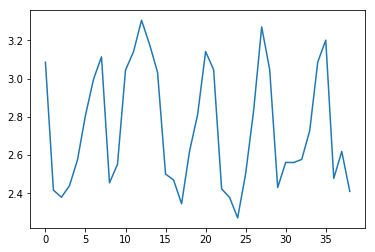

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.690392   
air_0164b9927d20bcc3_2017-04-23              1.353362   
air_0241aa3964b7f861_2017-04-23              2.461397   
air_0328696196e46f18_2017-04-23              1.792720   
air_034a3d5b40d5b1b1_2017-04-23              3.433270   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.421605  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.870418  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  10.721177  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   5.005767  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  29.977774

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/3002nb_lstm_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')